In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

# Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [22]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [24]:
df.head()

published_date published_platform  rating    type  \
0  2024-03-12T14:41:14-04:00            Desktop       3  review   
1  2024-03-11T19:39:13-04:00            Desktop       5  review   
2  2024-03-11T12:20:23-04:00            Desktop       1  review   
3  2024-03-11T07:12:27-04:00            Desktop       5  review   
4  2024-03-10T05:34:18-04:00            Desktop       2  review   

                                                text  \
0  We used this airline to go from Singapore to L...   
1  The service on Singapore Airlines Suites Class...   
2  Booked, paid and received email confirmation f...   
3  Best airline in the world, seats, food, servic...   
4  Premium Economy Seating on Singapore Airlines ...   

                                               title  helpful_votes  
0                                                 Ok              0  
1  The service in Suites Class makes one feel lik...              0  
2                         Don’t give them your money              0  
3                          Best Airline in the World              0  
4  Premium Economy Seating on Singapore Airlines ...              0

In [25]:
## If you want to see more text from the review, you can increase the display.max_colwidth

#pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [26]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

rating  review_length  contains_excellent  contains_terrible
0       1     920.468307            0.021760           0.096500
1       2     871.423573            0.053407           0.071823
2       3     737.867195            0.080278           0.042616
3       4     526.661922            0.149466           0.006101
4       5     431.168326            0.222345           0.002028

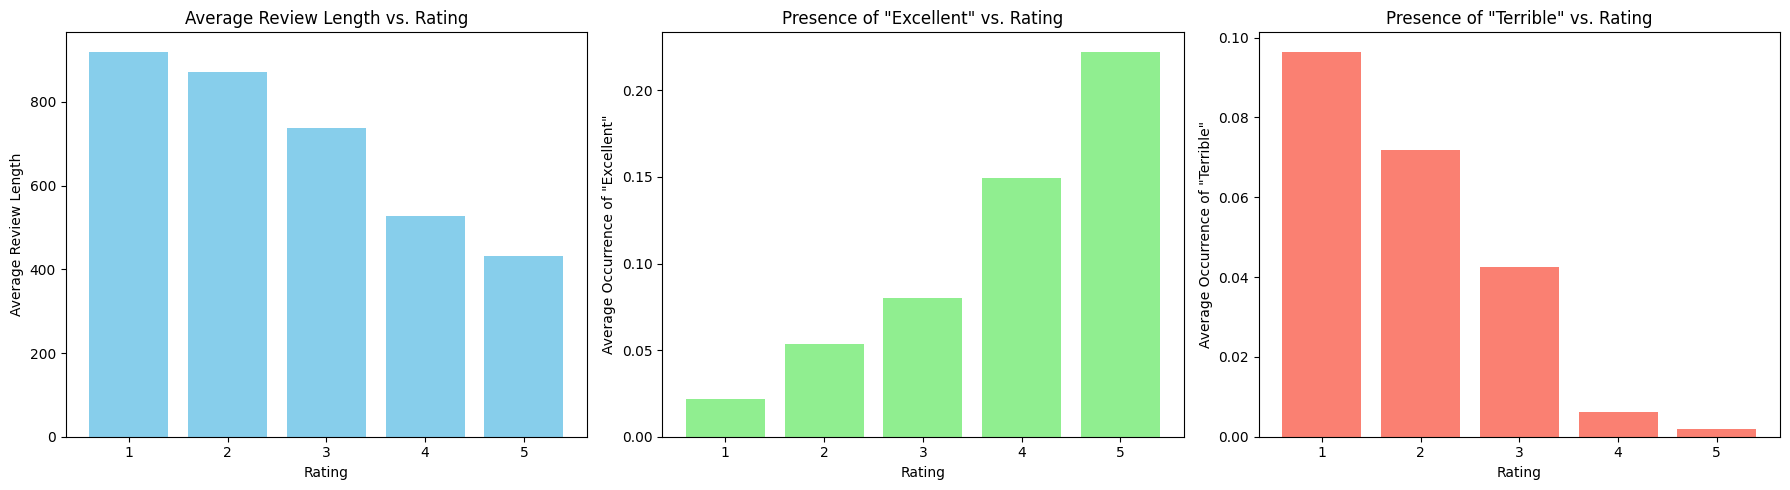

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [28]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

published_date published_platform  rating    type  \
0 2024-03-12 18:41:14+00:00            Desktop       3  review   
1 2024-03-11 23:39:13+00:00            Desktop       5  review   
2 2024-03-11 16:20:23+00:00            Desktop       1  review   
3 2024-03-11 11:12:27+00:00            Desktop       5  review   
4 2024-03-10 09:34:18+00:00            Desktop       2  review   

                                                text  \
0  We used this airline to go from Singapore to L...   
1  The service on Singapore Airlines Suites Class...   
2  Booked, paid and received email confirmation f...   
3  Best airline in the world, seats, food, servic...   
4  Premium Economy Seating on Singapore Airlines ...   

                                               title  helpful_votes  \
0                                                 Ok              0   
1  The service in Suites Class makes one feel lik...              0   
2                         Don’t give them your money              0   
3                          Best Airline in the World              0   
4  Premium Economy Seating on Singapore Airlines ...              0   

   review_length  contains_excellent  contains_terrible  year  
0           1352                   0                  0  2024  
1           4666                   1                  0  2024  
2            420                   0                  0  2024  
3            144                   0                  0  2024  
4            582                   0                  0  2024

In [29]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

year    rating
0  2018  4.319710
1  2019  4.246012
2  2020  4.046103
3  2021  2.435294
4  2022  2.181159
5  2023  2.684112
6  2024  2.333333

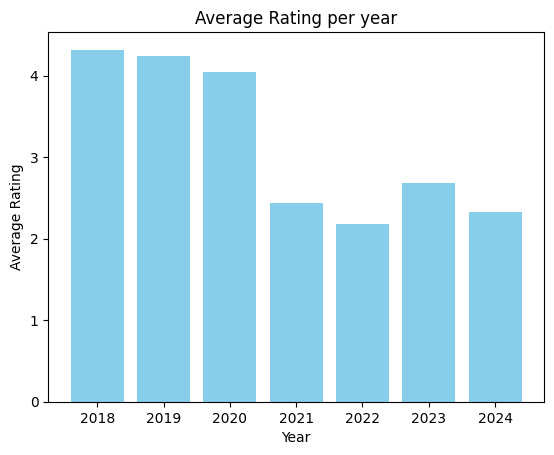

In [30]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue')
plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()

# Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

# Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [31]:
!pip install bertopic

In [32]:
from bertopic import BERTopic

In [33]:
topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [34]:
df_slice = df[(df['year'] == 2019)]

In [35]:
topics, probs = topic_model.fit_transform(df_slice['text'])

Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [36]:
topic_model.get_topic_info()

Topic  Count                               Name  \
0      -1   2696                  -1_the_and_to_was   
1       0    231    0_airlines_singapore_is_airline   
2       1    176      1_singapore_to_from_melbourne   
3       2    128        2_airline_best_this_service   
4       3    114           3_economy_premium_the_we   
..    ...    ...                                ...   
57     56     12       56_hot_towels_towel_airlines   
58     57     11  57_breakfast_was_served_selection   
59     58     11  58_are_attendants_always_mindless   
60     59     11  59_lounge_business_brisbane_class   
61     60     10             60_hanoi_on_was_flight   

                                       Representation  \
0   [the, and, to, was, flight, in, of, singapore,...   
1   [airlines, singapore, is, airline, best, are, ...   
2   [singapore, to, from, melbourne, perth, in, we...   
3   [airline, best, this, service, is, the, great,...   
4   [economy, premium, the, we, not, singapore, to...   
..                                                ...   
57  [hot, towels, towel, airlines, always, off, so...   
58  [breakfast, was, served, selection, pm, kosher...   
59  [are, attendants, always, mindless, airlines, ...   
60  [lounge, business, brisbane, class, the, is, b...   
61  [hanoi, on, was, flight, singapore, hop, the, ...   

                                  Representative_Docs  
0   [This was the first time we have flown with Si...  
1   [We have flown Singapore Airlines for years an...  
2   [After a cruise from Sydney to Southampton, to...  
3   [We have travelled before with this airline an...  
4   [We paid for Premium Economy on our recent tri...  
..                                                ...  
57  [I always enjoy flying Singapore Airlines. Jus...  
58  [Disappointed with the service.\nWas a late ev...  
59  [We always travel with Singapore Airlines.  It...  
60  [When flying where Virgin Australia does not g...  
61  [I had an excellent flight to Hanoi on Singapo...  

[62 rows x 5 columns]

You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [37]:
topic_model.get_topic(2)

[('airline', np.float64(0.03810054862622089)),
 ('best', np.float64(0.0339428780059982)),
 ('this', np.float64(0.020170133299061494)),
 ('service', np.float64(0.01792619150469416)),
 ('is', np.float64(0.017233071352570954)),
 ('the', np.float64(0.015777273499987157)),
 ('great', np.float64(0.015348058660902759)),
 ('and', np.float64(0.015347763214478016)),
 ('food', np.float64(0.014981122811520519)),
 ('are', np.float64(0.014893276138507711))]

Here, you can get representative reviews for a topic.

In [38]:
topic_model.get_representative_docs(2)

['We have travelled before with this airline and yet again an excellent flight. From the booking to flight service the staff are very good, food for an airline is also good. Would travel with them again and recommend you to try them.',
 "The best of the best!\n\nThis airline is one of the best that I have ever flown. I would say my favorite among the best. The entire experience is unparalleled. \n\nThe service is superb! They really know the meaning of customer service. They are there before you even have to ask. Making sure that your drink is filled, your bed made, your dishes cleared.\n\nThe seats in business class are fantastic!! Very comfortable.\n\nI would recommend this airline to anyone. Too bad they don't fly around the US or I would take them all the time.",
 'What can be said about the world’s best airline!  The planes are clean, staff are very friendly and helpful, the food is good (for plane food), and the entertainment is good.  I have travelled on other airlines, but this

You can also visualize topic relationships in 2d space.

In [39]:
topic_model.visualize_topics()

Or visualize topic word scores.

In [40]:
topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [41]:
topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [42]:
topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
topic_df

topic                                           document
2179     48  I  traveled with my family  to Singapore for C...
2180      2  The plane ride was excellent, new plane what a...
2181     -1  Lots of good food and amenities. Their menu ev...
2182     12  Our night flight back from Narita was about 7 ...
2183     -1  Singapore Airport and airlines rank amongst th...
...     ...                                                ...
7377     -1  This flight was the day after we arrived in Si...
7378     -1  This was the first time we have flown with Sin...
7379     -1  The meal was really good but for all other ele...
7380     38  The  flight from Delhi to Bali via Singaore on...
7381     -1  When we travel from Bali via Singapore to Amst...

[5203 rows x 2 columns]

# Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

# Deliverables

See the assignment descriptions for a full overview of the deliverables.

# Your analysis

## Section 1 - Preliminary Exploratory Analysis
To start, let us look at the model of the 2019 slice and see what meaningful insights we can gain from it and how the topics have been modelled, this way we can gain a structure which we will use for subsequent analysis

In [43]:
#imports
from transformers import pipeline
import seaborn as sns
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline
import networkx as nx
from itertools import combinations
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [44]:
#assign topics and create dataframe
df_slice['topic'] = topics

#group by topic and calculate average ratings
topic_ratings = df_slice.groupby('topic')['rating'].agg(['mean', 'count']).reset_index()
topic_ratings.columns = ['Topic', 'Average Rating', 'Review Count']
topic_ratings = topic_ratings.sort_values(by='Average Rating')

topic_ratings.head(10)



Topic  Average Rating  Review Count
23     22        1.470588            34
51     50        1.538462            13
25     24        2.032258            31
49     48        2.357143            14
15     14        2.803571            56
40     39        2.842105            19
55     54        2.916667            12
34     33        3.086957            23
8       7        3.183908            87
4       3        3.377193           114

Next let us visualise topic rating distribution and see which topics are lowest rated

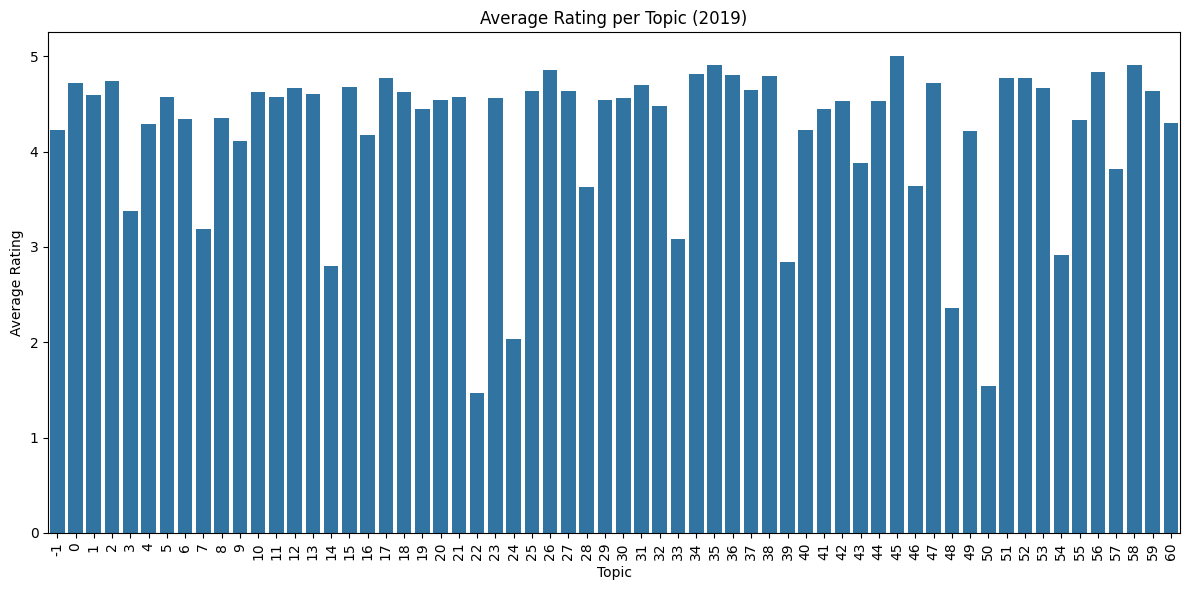

In [45]:
plt.figure(figsize=(12,6))
sns.barplot(x='Topic', y='Average Rating', data=topic_ratings)
plt.title("Average Rating per Topic (2019)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Now let us have a look at the top lowest-rated topics and see what is inside of them, i.e. what is common among low rated topics

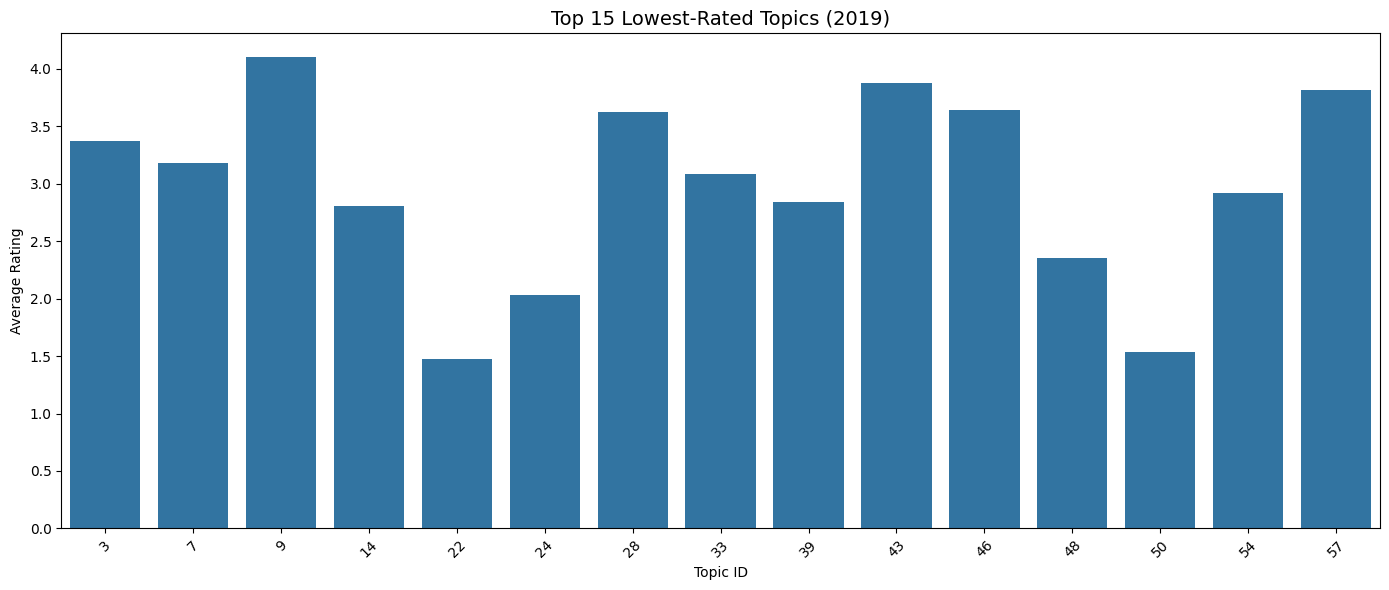

In [46]:
plt.figure(figsize=(14, 6))
sns.barplot(x='Topic', y='Average Rating', data=topic_ratings.head(15))
plt.title("Top 15 Lowest-Rated Topics (2019)", fontsize=14)
plt.ylabel("Average Rating")
plt.xlabel("Topic ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To do so we need to sample reviews from low-rated topics and inspect these reviews

In [47]:
low_rated_topics = topic_ratings.head(3)['Topic'].tolist()
for t in low_rated_topics:
    print(f"=== Topic {t} ===")
    print(df_slice[df_slice['topic'] == t]['text'].sample(3).values) #only looking at top 3
    print("\n")


=== Topic 22 ===
['Great airline in the air but one of the worst on the ground.  I had to change a flight recently and was directed to a call center.  The experience defies description with misinformation, disinterest and lack of professionalism at the forefront however the most concerning was how my  request to speak to a "manager" was handled.  In the initial call, I was placed on hold for over 15 minutes which the operator tried to locate a "manager".  Was eventually told that none were available as they were all in meetings but was assured a "manager" would call me back.  It has now been almost a week and despite 2 further calls trying to speak to someone to resolve my  issue and despite being assured that someone would call me back - NOTHING.  I even asked for a telephone number in SIN I could ring but was advised they are not authorised to put a passenger in direct contact with the airline and the Filipino Call Centre could deal with  the  issue.  Passenger issues are dealt with 

Let us look at the 3 worst rated topics and inspect the reviews for them

In [48]:
#worst topics
lowest_topics = topic_ratings.head(3)['Topic'].tolist() #only bottom 3

#Print the reviews from each low-rated topic - only a  portion of them
for topic_id in lowest_topics:
    print(f"\nTopic {topic_id} — Avg Rating: {topic_ratings[topic_ratings['Topic'] == topic_id]['Average Rating'].values[0]:.2f}") #include rating
    reviews = df_slice[df_slice['topic'] == topic_id]['text'].sample(3, random_state=42)
    for review in reviews:
        print("•", review.strip()[:300], "...\n") #only 300 characters



Topic 22 — Avg Rating: 1.47
• We received an offer from Singapore plus up grade to up grade our flights. We put offers in on all flights. First we had two offers charged to our credit card an then received an email to say we were unsuccessful. The charges still remain on our credit card. When contacting Singapore plus grade they ...

• After sitting on the phone for one hour, while listening to music which was on a continuous loop - I found myself wanting to rip the very hair from my scalp. The call centers could barely speak coherent English, which only made the issue more difficult. We asked to speak to their manager, but alas,  ...

• I booked a ticket with Singapore Airline from Paris to Singapore, the money was deducted from my bank account, but both staffs from Paris and Singapore office insisted that they did not receive the payment, and refused to check my transaction number (offered by my bank). The staffs' attitude was hor ...


Topic 50 — Avg Rating: 1.54
• We booked a flig

Now we have had a little look at the 2019 ratings, our question to answer is essentially; “What topics/issues were customers complaining about more after 2020 compared to before?” - we want to see why ratings have dropped so lets assess the sentiment before and after the drop to figure this out and generate recommendations to the CEO


Let us start by splitting the data into different periods, we wish to split it at 2021, to break it up into defined sections where one is when ratings were high and the other, after they fell so we can anlyse both data sets and see what has changed, additionally we will look at the data by year and model the topics to have a more clear indication of what went well and what went wrong

# Section 2 - Per year slicing
Now we know what we want to look at let us slice the data per year and analyse the reviews to generate insights for recommendations

## Section 2.1 - Setup and Yearly Loop

In [49]:
#setup variables for loop
sentiment_pipeline = pipeline("sentiment-analysis")
years = sorted(df['year'].unique())  #ensure correct 'year' column
results_by_year = {}  #store analysis per year
topic_sentiments_all_years = []

#keyword extraction definition
def extract_keywords(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform([texts])
    scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_scores[:top_n]]

#store results per year for later comparison
all_pos_keywords = {}
all_neg_keywords = {}

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0



 Analysing Year: 2018


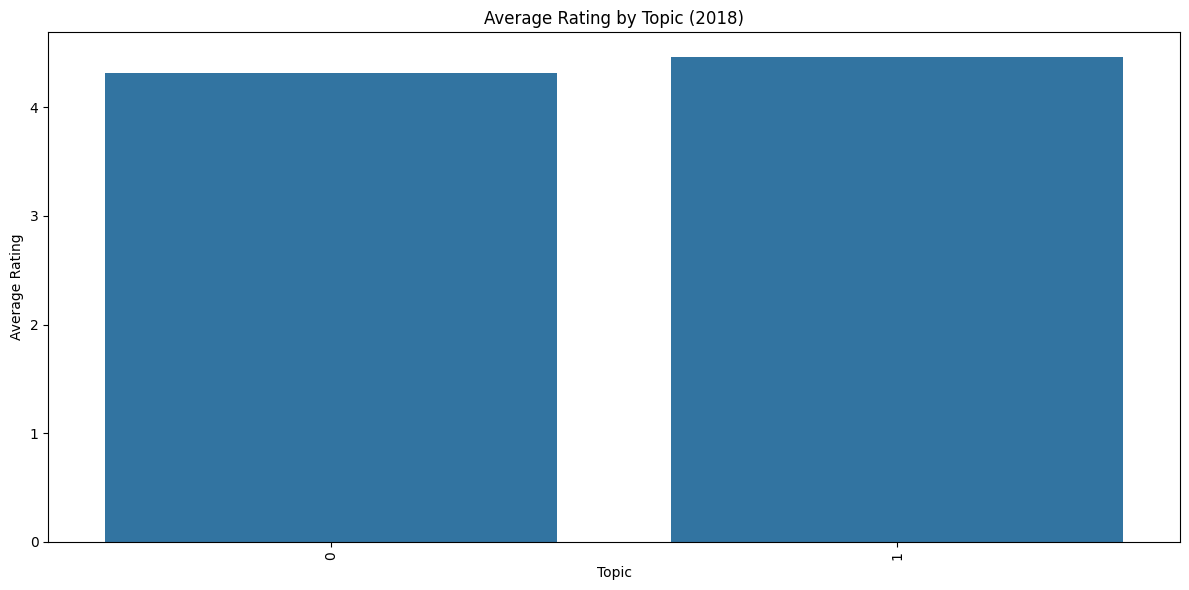

Lowest Rated Topics in 2018: [0, 1]


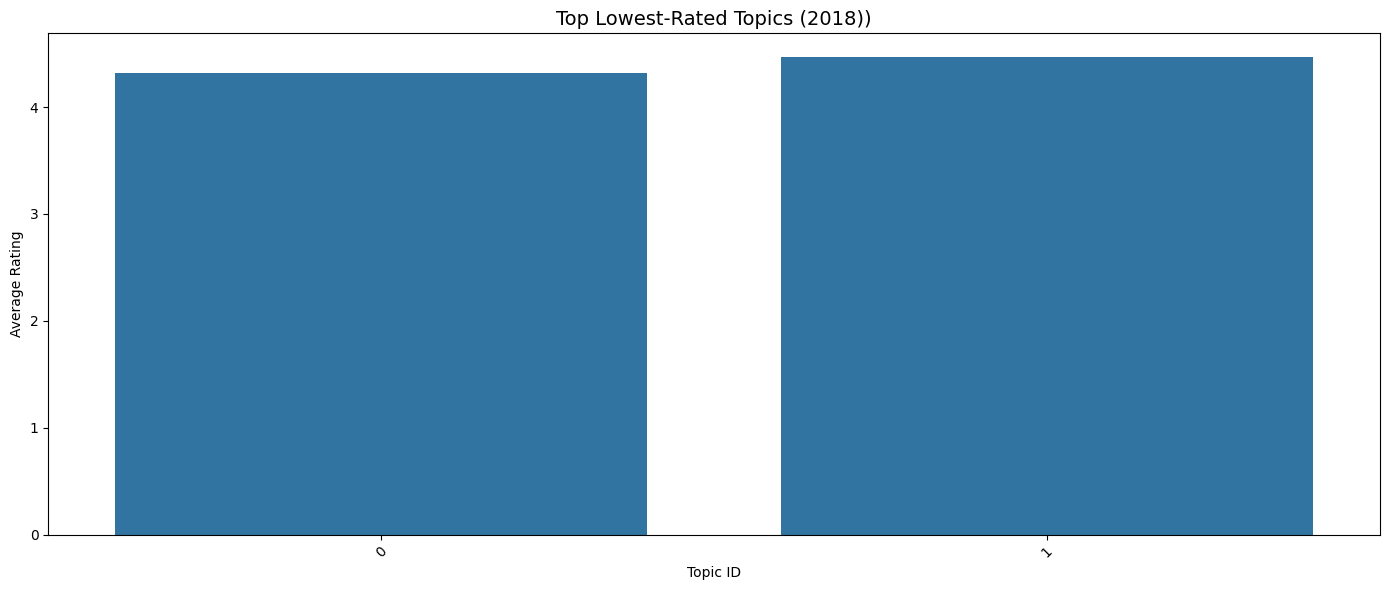


=== Topic 0 === Avg Rating: 4.31
- Loved the new A380 seat design. So much easier to decoy the bed. And even better we cauliflower the divider between us, down to squab level so that we could see each other & chat easily throughout the flight. This airline continues to provide great service & comfort. Been flying with them for 20+ ye ...

- it was great flying with Singapore Airlines and Silk Air, We travelled from Brisbane to Coimbatore India and we did not have any issues, enjoyed the return flight and the meals and customer service provided was excellent, will travel again on Singapore Airlines for our next holiday abroad ...

- We have tried others but consistently the genuine care, effort and interest of the staff of Singapore makes a very big difference. We now always time our flights to allow an 8 hour stop over. We then book into a transit hotel for the 6 hour block. Sleep soundly and arrive in Europe in much better sh ...


=== Topic 1 === Avg Rating: 4.47
- Having taken SQ a

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


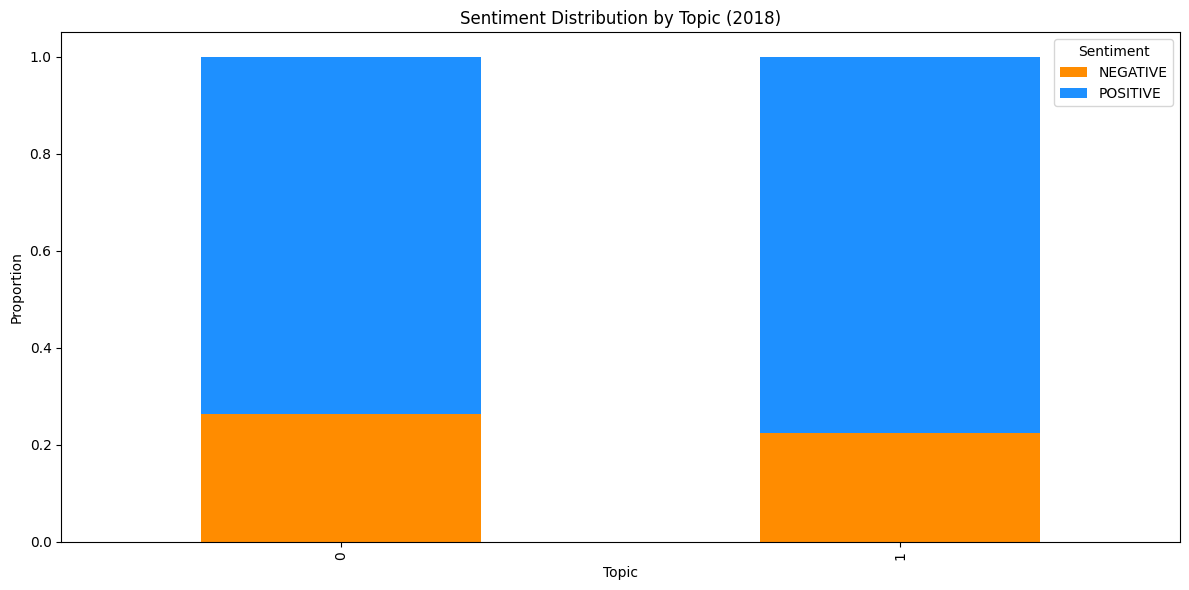


 Top Positive Keywords for 2018:
 ['flight', 'singapore', 'service', 'airlines', 'good', 'food', 'airline', 'great', 'time', 'staff', 'economy', 'comfortable', 'class', 'seats', 'crew', 'excellent', 'entertainment', 'fly', 'seat', 'best']
Top Negative Keywords for 2018:
 ['flight', 'singapore', 'airlines', 'service', 'food', 'seat', 'economy', 'seats', 'good', 'class', 'time', 'airline', 'business', 'staff', 'crew', 'just', 'sq', 'plane', 'hours', 'meal']

 Analysing Year: 2019


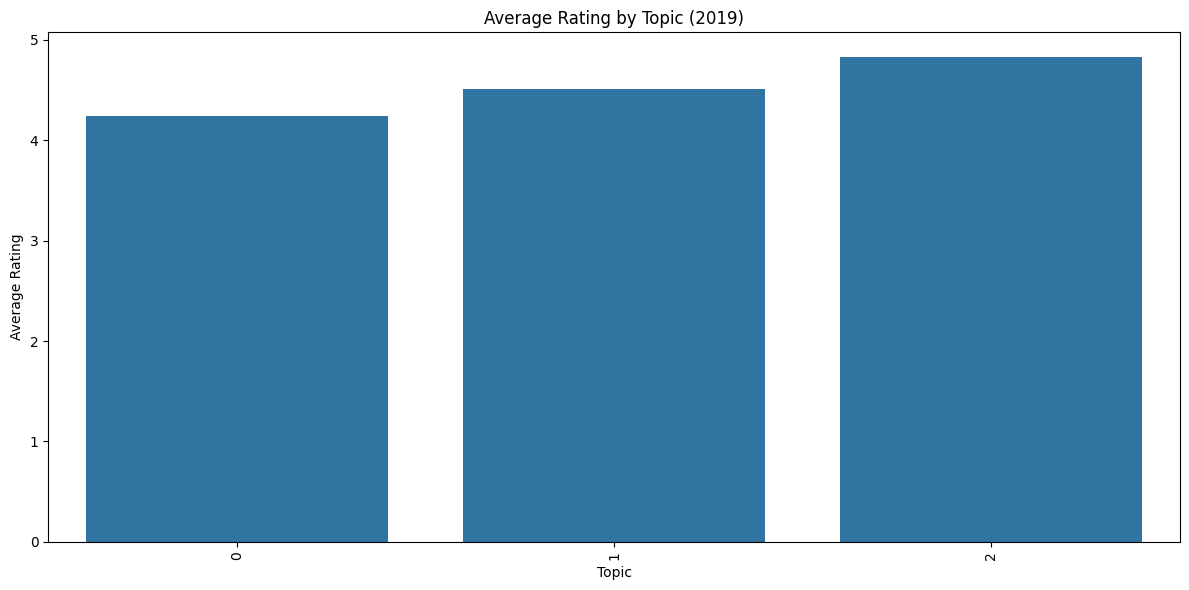

Lowest Rated Topics in 2019: [0, 1, 2]


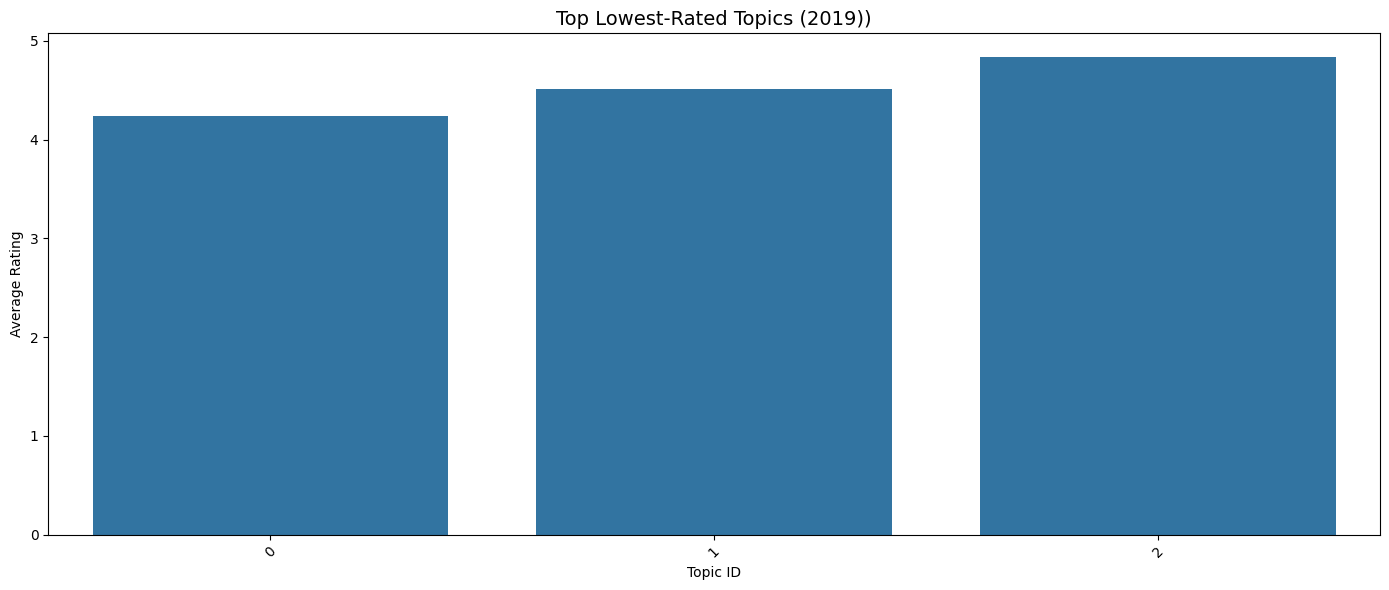


=== Topic 0 === Avg Rating: 4.24
- Fantastic service. Super easy check-in at the Colombo airport. The seats were very comfortable. I found the inflight entertainment a tad boring as most of the movies were quite dull nevertheless I got 3 solid hours of sleep. Food was very good which I ordered off the inflight menu. Toilet could have ...

- We were traveling in a group of 4. My wife, my mother and my ticket were booked by me through the web. My sister booked the ticket separately. We were flying back from Melbourne. I dropped them off and went on to return my rental car. There were total 6 big bags and My mother is 84. I have requested ...

- My daughter got quite sick on the flight -- she was already feeling nauseous the morning of our flight.  She vomited on the flight.  Worried for our daughter, we also worried about the other passengers.  But the cabin crew was so very helpful in cleaning up, and also graciously reassured us that the ...


=== Topic 1 === Avg Rating: 4.51
- Our co

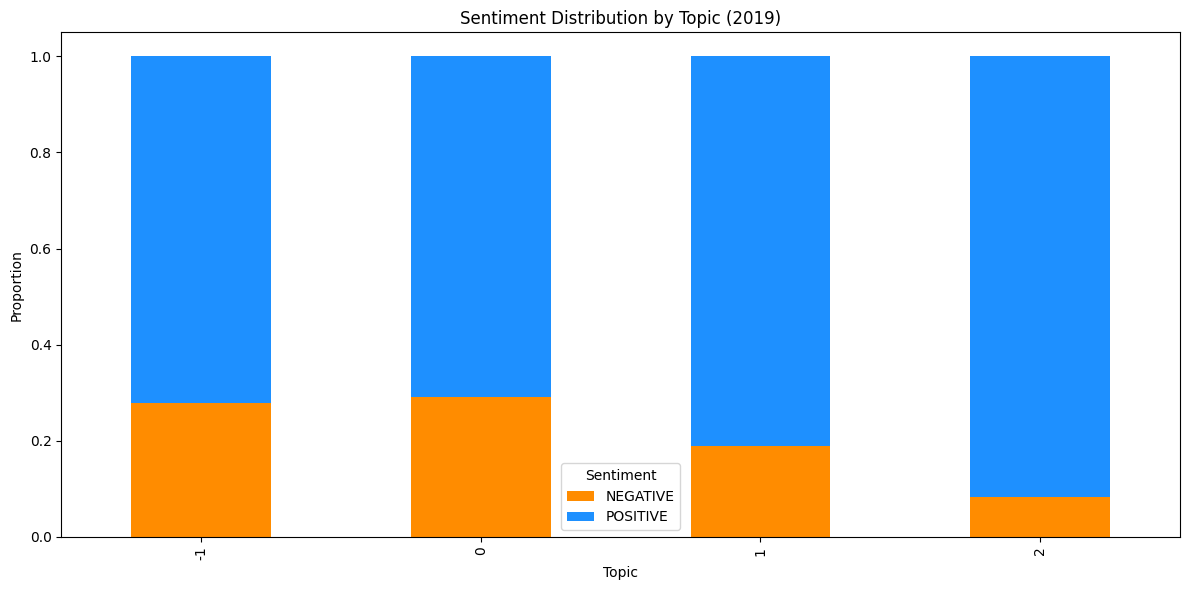


 Top Positive Keywords for 2019:
 ['flight', 'singapore', 'service', 'airlines', 'good', 'food', 'great', 'airline', 'time', 'staff', 'crew', 'class', 'seats', 'economy', 'comfortable', 'excellent', 'entertainment', 'best', 'cabin', 'fly']
Top Negative Keywords for 2019:
 ['flight', 'singapore', 'airlines', 'service', 'food', 'seat', 'economy', 'seats', 'time', 'airline', 'good', 'class', 'staff', 'business', 'just', 'flights', 'sq', 'premium', 'crew', 'plane']

 Analysing Year: 2020


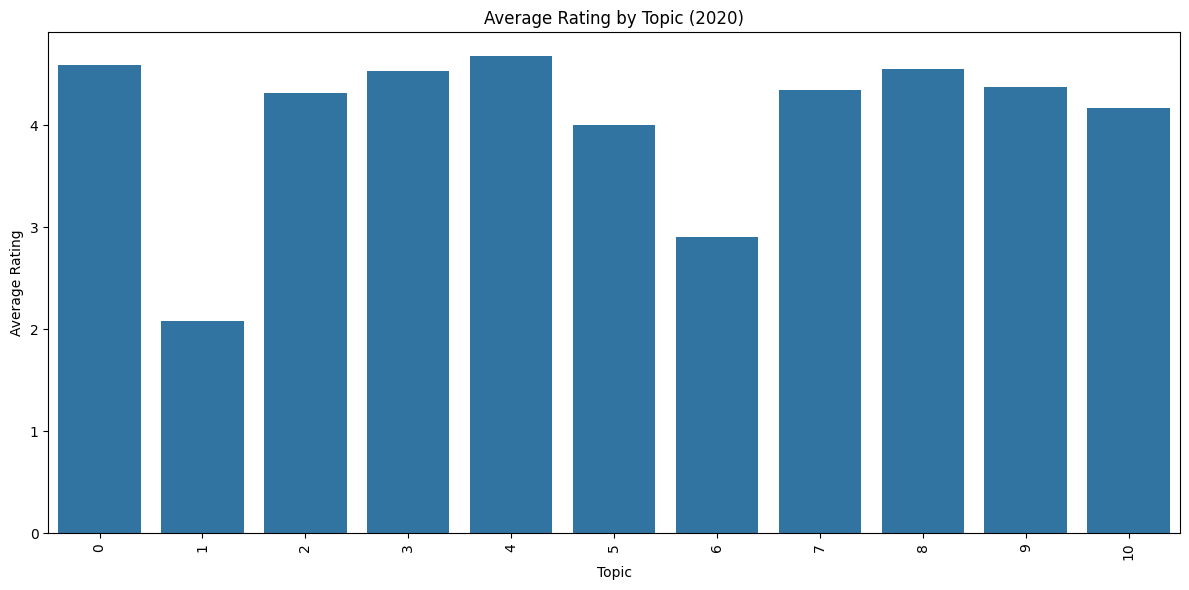

Lowest Rated Topics in 2020: [1, 6, 5, 10, 2]


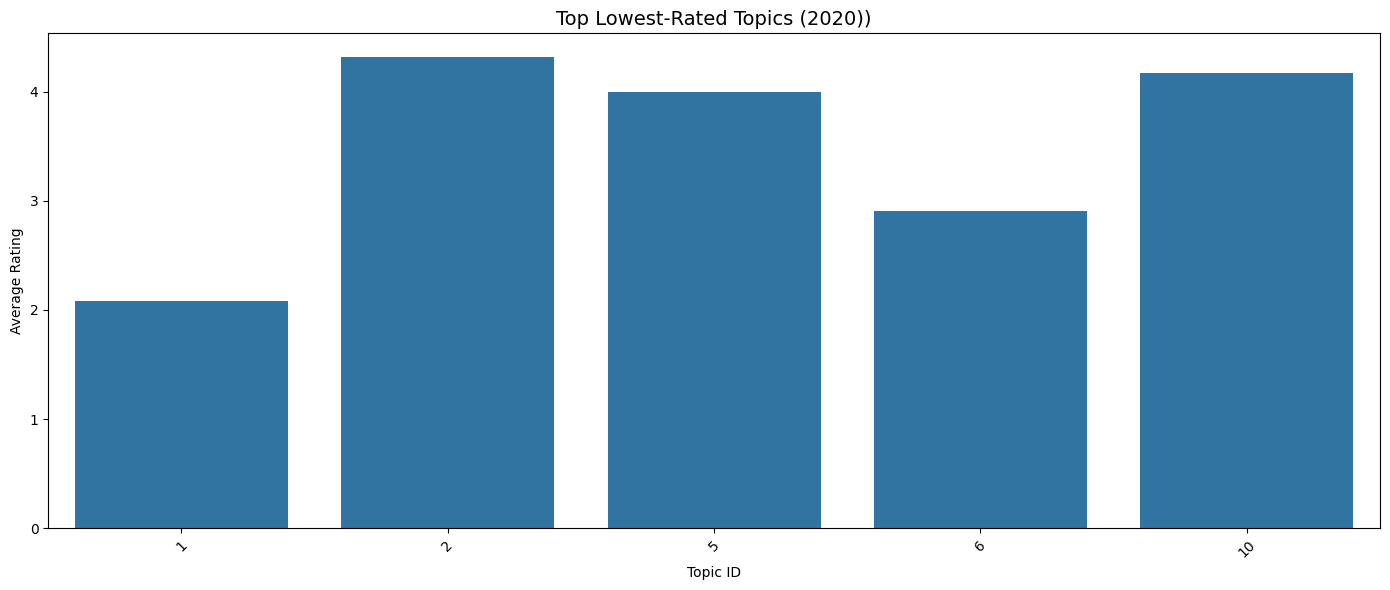


=== Topic 1 === Avg Rating: 2.08
- I am still waiting for an sollution. My flight to Bangkok was 2 months ago cancelled, but I can not reach my agent and Singapore airlines do nothing ! How different with the low budget company AirAsia. My flight was not cancelled. But you could altready apply for a credit. You can learn from this Si ...

- I thought we were making a safe choice booking flights with Singapore Airlines in January before COVID blew up.  However, on reflection I will not use them again.  We are due to fly in 5 weeks time, which we obviously will not be doing, and they dont want to release any flight schedules or provide c ...

- January 25 2020 I bought SIA business tickets to the UK for July 2020 and couldn't fly. I bought them through Fly365 who went bust at the end of Feb. Luckily SIA had already issued the tickets. In June I asked them about them and they said that the flight would not happen and I could use them to get ...


=== Topic 6 === Avg Rating: 2.90
- After 

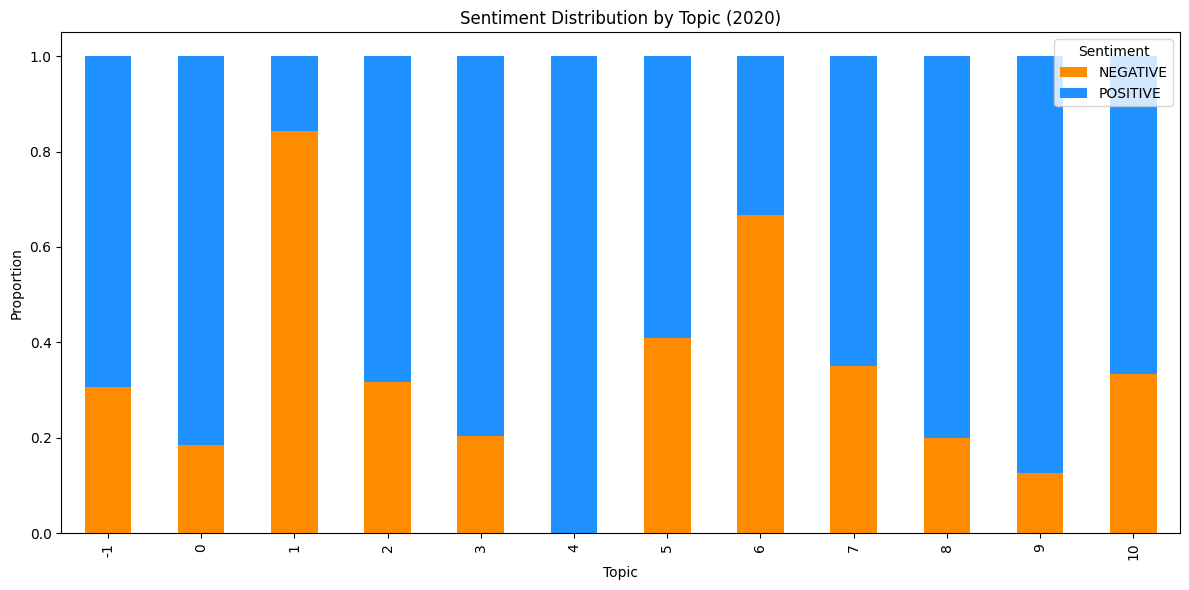


 Top Positive Keywords for 2020:
 ['flight', 'singapore', 'airlines', 'service', 'good', 'food', 'great', 'class', 'airline', 'seat', 'seats', 'time', 'crew', 'staff', 'comfortable', 'cabin', 'business', 'passengers', 'economy', 'excellent']
Top Negative Keywords for 2020:
 ['singapore', 'flight', 'airlines', 'service', 'seat', 'airline', 'seats', 'class', 'food', 'good', 'flights', 'time', 'business', 'economy', 'staff', 'refund', 'cabin', 'passengers', 'meal', 'travel']

 Analysing Year: 2021


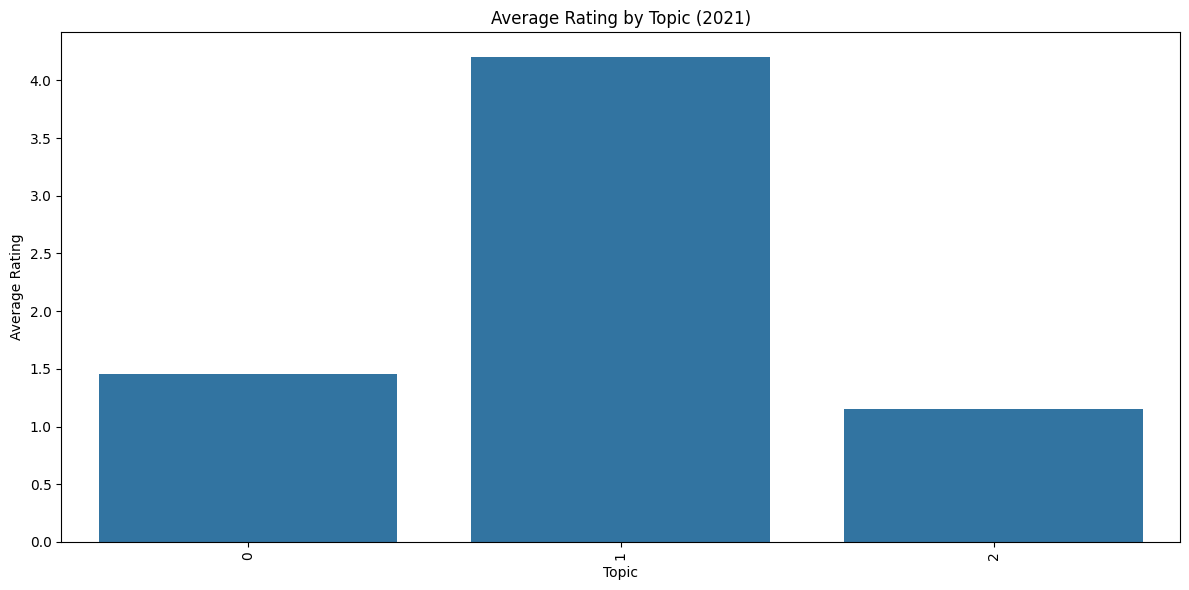

Lowest Rated Topics in 2021: [2, 0, 1]


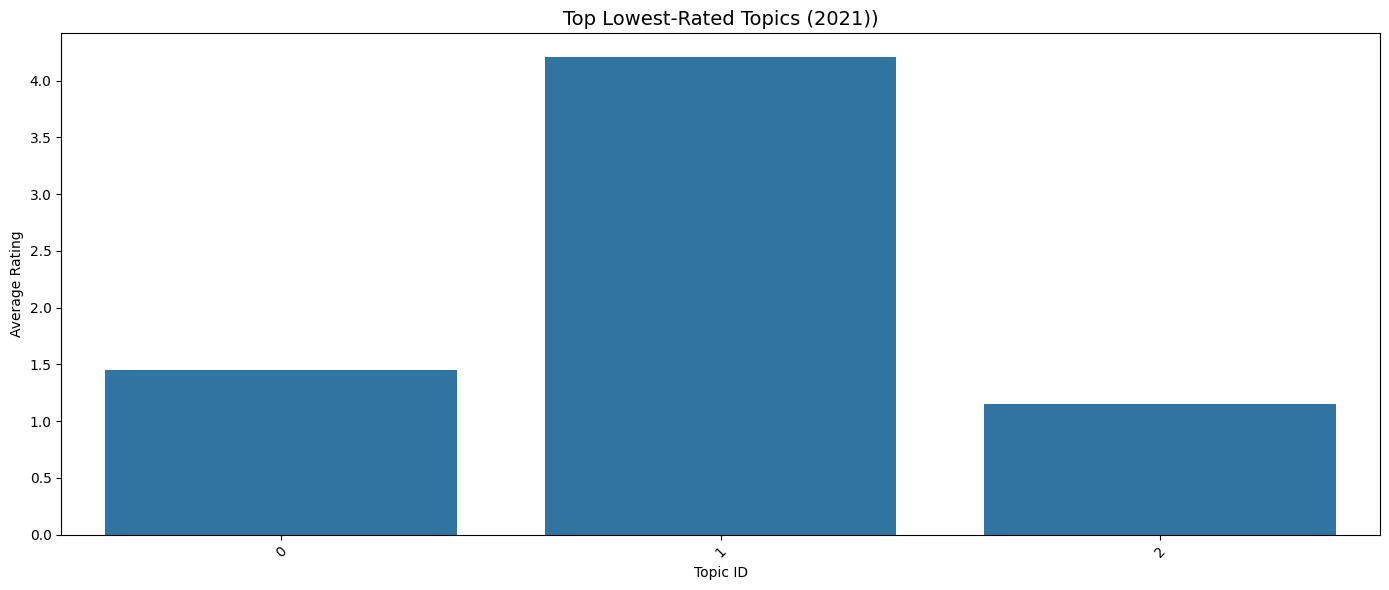


=== Topic 2 === Avg Rating: 1.15
- I booked a ticket to Sri Lanka back in March 2020. Of course it got cancelled due to covid and I was extended a "rebooking credit".

When I decided to use it a year later in May 2021, it took them 10 emails to just understand what I want to book, how much credit I am eligible for and so on.

To make ...

- I fully understand that it is difficult for airlines nowadays, so the long waiting time at customer service is still acceptable. But unfortunately the service delivered was extremely disappointing, no client focus and no knowledge about the airline details. Surprised that SQ is still rated positivel ...

- The airline changed 1 of my flights but not the other which means connection will fail have spent a total of 10 hours waiting on the phone and 3 calls where I have been promised emails and return calls that have never happened - no one has done anything, no one has contacted me and the flights are s ...


=== Topic 0 === Avg Rating: 1.45
- Choose

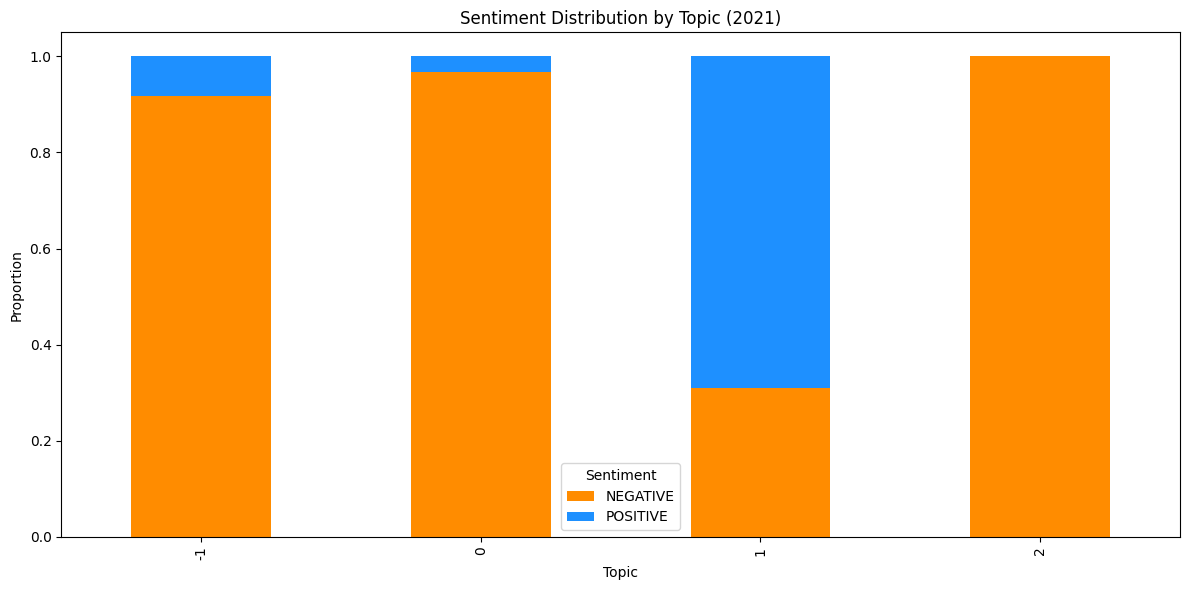


 Top Positive Keywords for 2021:
 ['singapore', 'airlines', 'flight', 'service', 'good', 'business', 'crew', 'food', 'friendly', 'really', 'airline', 'class', 'covid', 'aircraft', 'comfortable', 'excellent', 'fly', 'provided', 'seat', 'snacks']
Top Negative Keywords for 2021:
 ['flight', 'singapore', 'airlines', 'hours', 'service', 'airline', 'staff', 'time', 'flights', 'covid', 'ticket', 'told', 'transit', 'customer', 'said', 'called', 'just', 'phone', 'booked', 'fly']

 Analysing Year: 2022


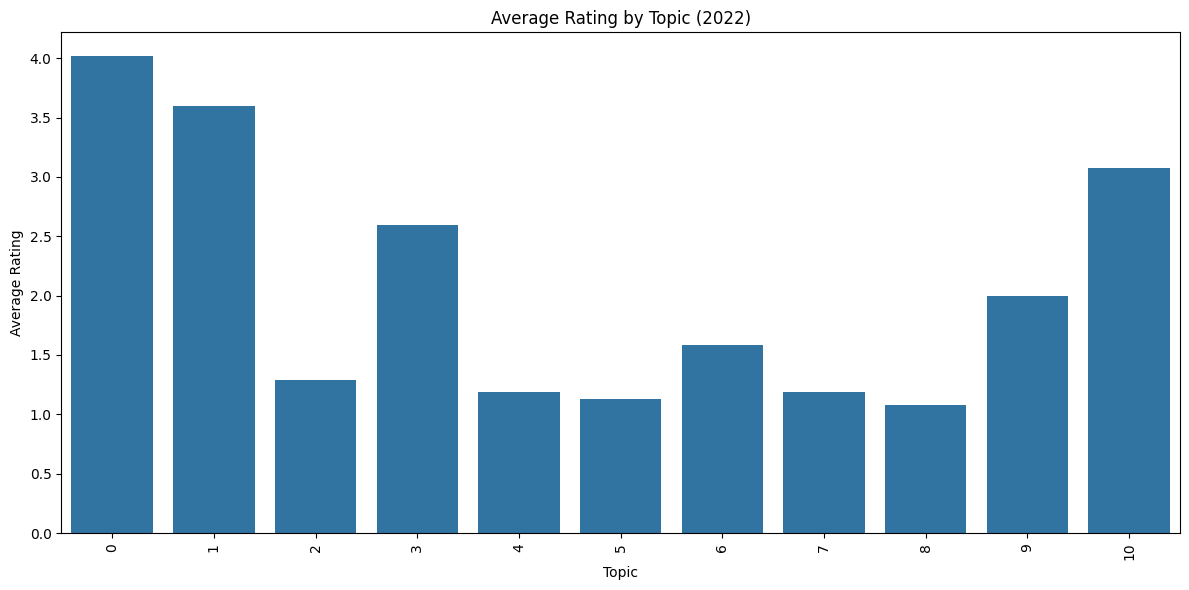

Lowest Rated Topics in 2022: [8, 5, 7, 4, 2]


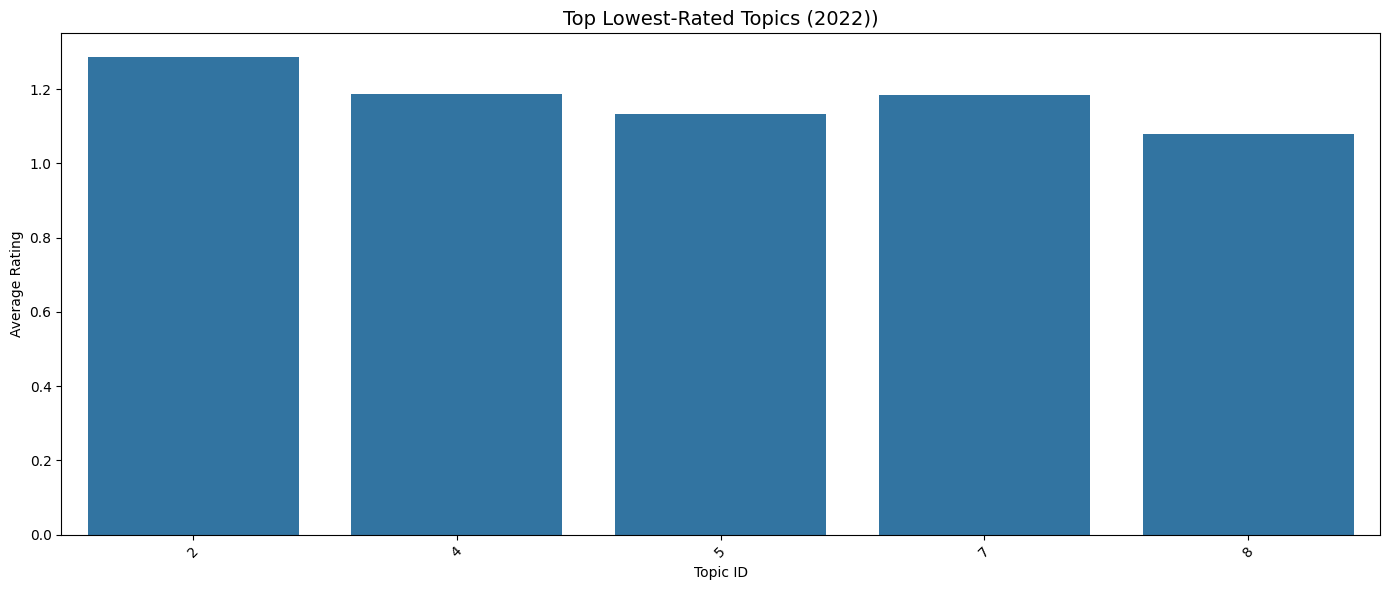


=== Topic 8 === Avg Rating: 1.08
- This was my first flight travelling Singapore Airlines since the pandemic. I had flown with them before and was very happy with there service but clearly customer service is no longer a priority. 
I booking with SingaporeAirlines as I assumed with this came some level of service. My flight did invol ...

- Airline cancelled booking itself, support in Singapore doesn't reply at all, just Moscow office "we don't know, ask main offive". No care of customers at all ...

- @ "Customer Service Hotline" Team / Technical Team / Email Team and whatever other fancy name you choose to call yourselves:

This is to caution all travellers who may (unfortunately) choose to fly with Singapore Airlines: If you face any issues with your flight booking, even if it is through no fau ...


=== Topic 5 === Avg Rating: 1.13
- I had 13 days left for my passport to expire so I should have not even been able to go on the flight. On top of that they didn't even check how many 

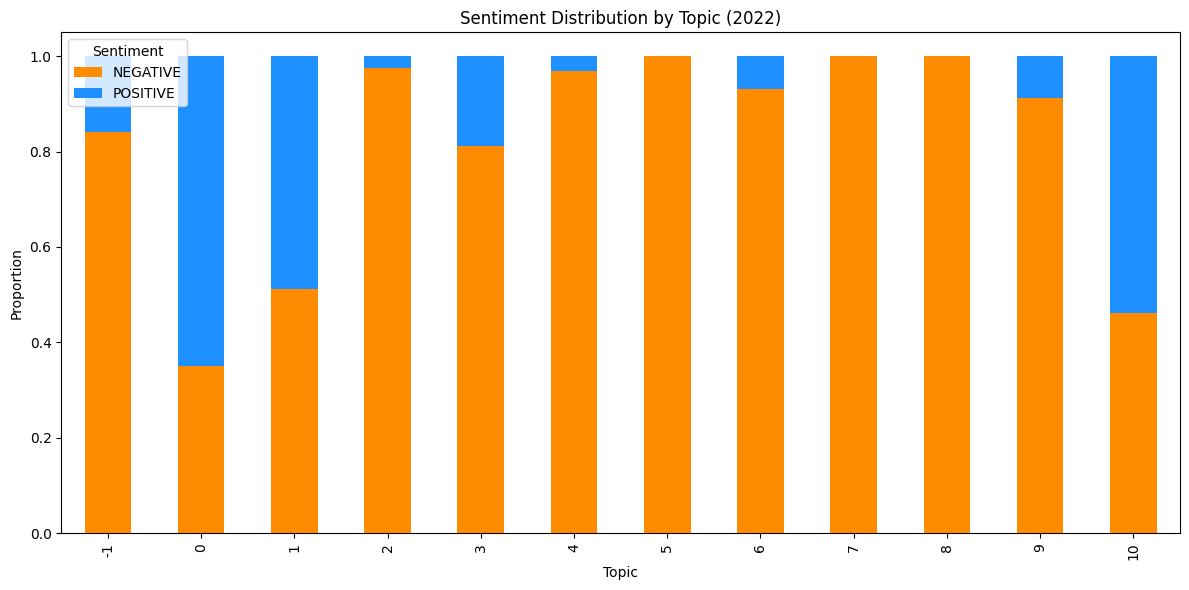


 Top Positive Keywords for 2022:
 ['flight', 'singapore', 'airlines', 'service', 'good', 'crew', 'food', 'class', 'economy', 'business', 'time', 'airline', 'seat', 'seats', 'experience', 'great', 'flights', 'really', 'cabin', 'best']
Top Negative Keywords for 2022:
 ['flight', 'singapore', 'airlines', 'service', 'airline', 'time', 'customer', 'hours', 'food', 'class', 'just', 'seat', 'business', 'flights', 'economy', 'ticket', 'seats', 'change', 'told', 'experience']

 Analysing Year: 2023


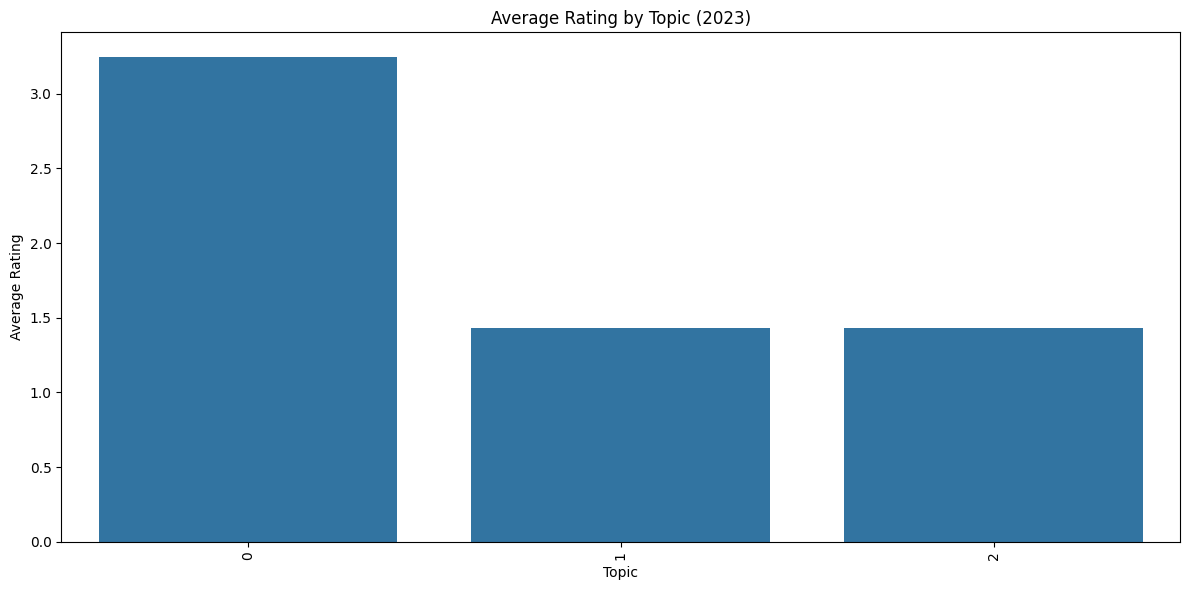

Lowest Rated Topics in 2023: [1, 2, 0]


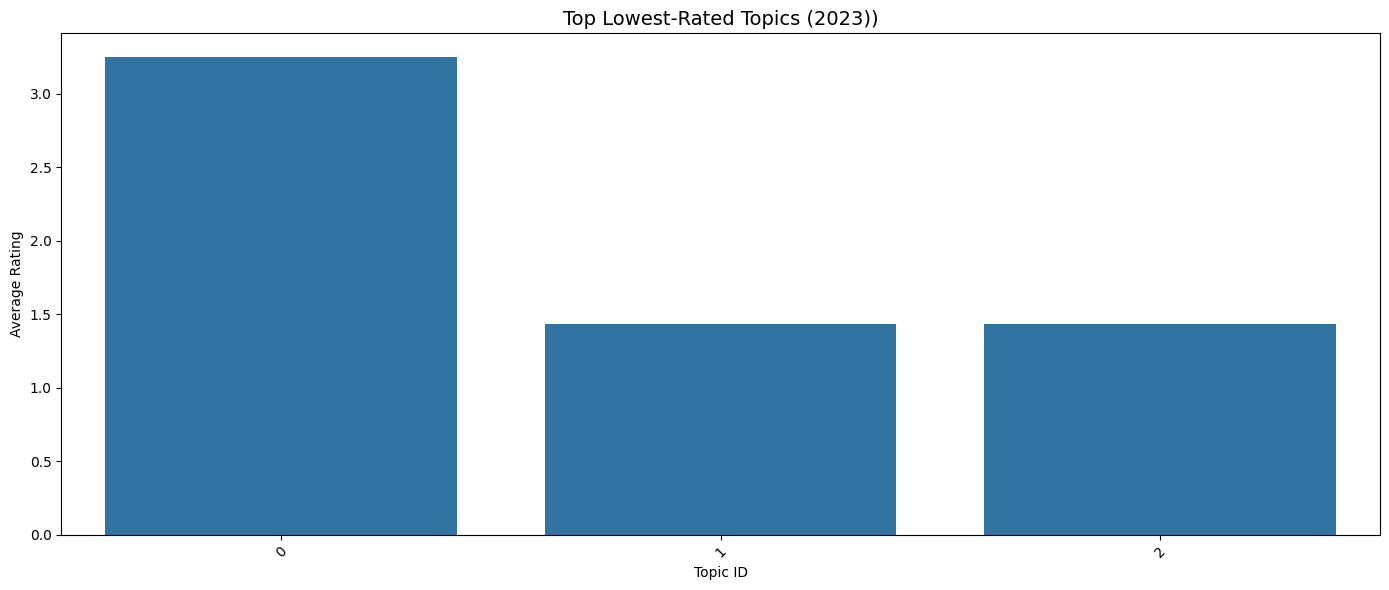


=== Topic 1 === Avg Rating: 1.43
- My sister and our partners booked our flights for our family holiday 10 months before our trip so we could be on the same flights and get the window seats we always prefer. I booked business and my sister booked premium economy and our flights went via Singpaore with a one hour layover. A few months ...

- We were looking forward to our flight with Singapore Airlines last month. We had booked 2 business class tickets online for our departure from Sydney with a cancellation fee of $330 each.

Unfortunately my wife was suddenly diagnosed with a major illness & had to cancel our flights 2 weeks before de ...

- I was looking to earn 1,800 elite miles to qualify for Silver status (status doesn't mean that much to me, but it gets you further up the waitlist when redeeming miles for flights, which I do care about). I contacted their customer reps prior to booking on a partner flight since I don't live in Asia ...


=== Topic 2 === Avg Rating: 1.43
- Singap

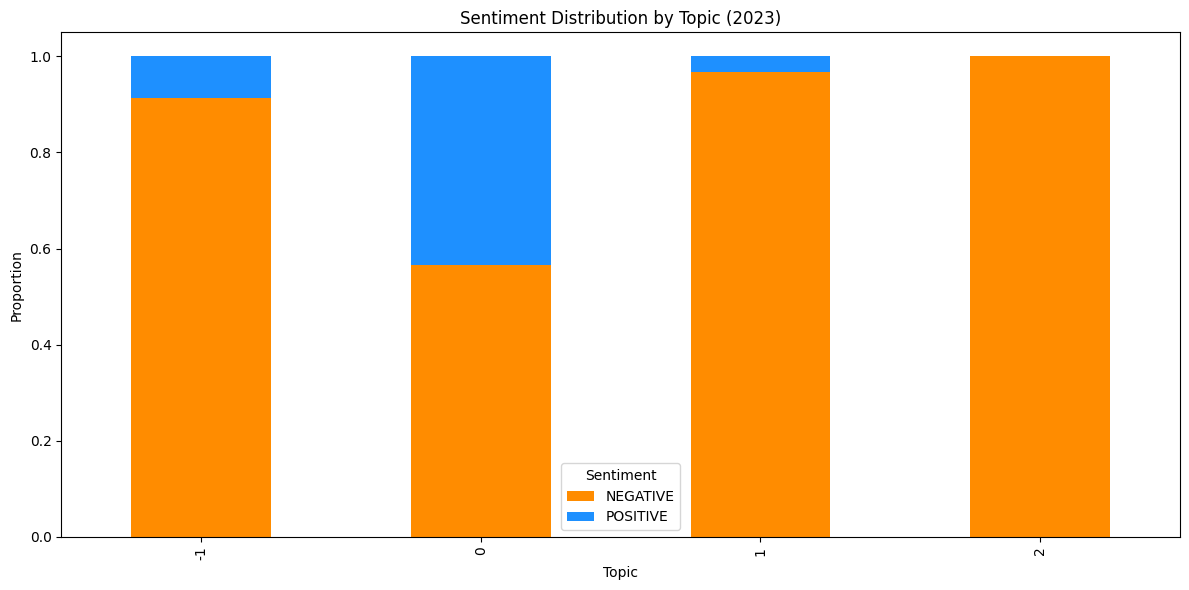


 Top Positive Keywords for 2023:
 ['flight', 'singapore', 'airlines', 'service', 'food', 'class', 'good', 'great', 'crew', 'business', 'economy', 'seat', 'seats', 'cabin', 'time', 'staff', 'airline', 'experience', 'flights', 'excellent']
Top Negative Keywords for 2023:
 ['singapore', 'flight', 'airlines', 'service', 'airline', 'economy', 'food', 'seat', 'time', 'seats', 'class', 'flights', 'crew', 'customer', 'business', 'just', 'told', 'experience', 'luggage', 'good']

 Analysing Year: 2024


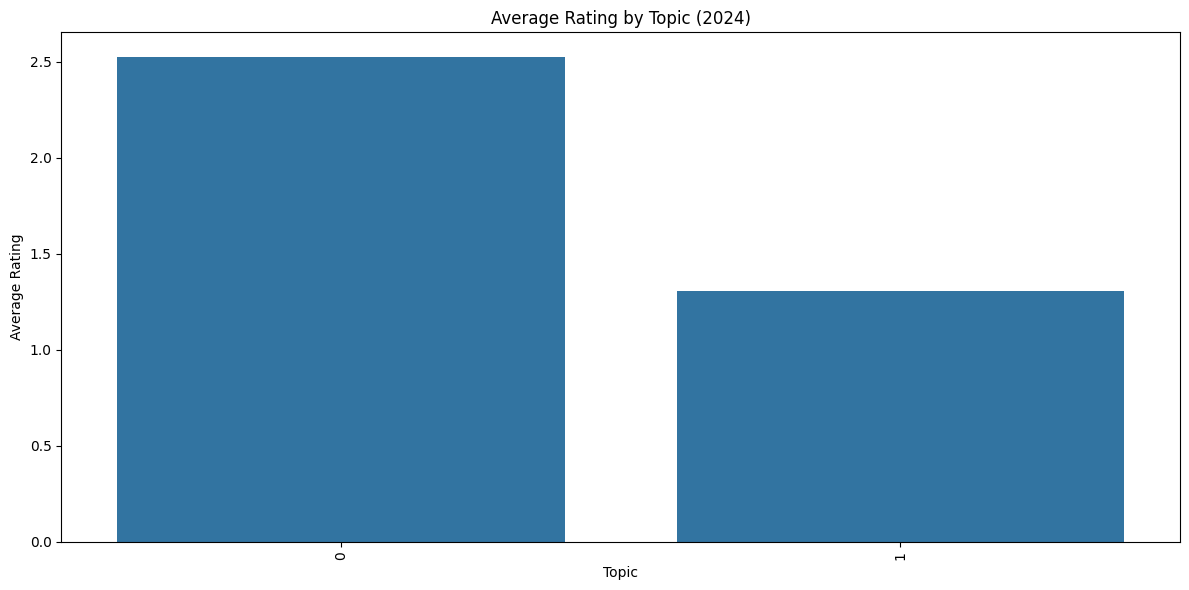

Lowest Rated Topics in 2024: [1, 0]


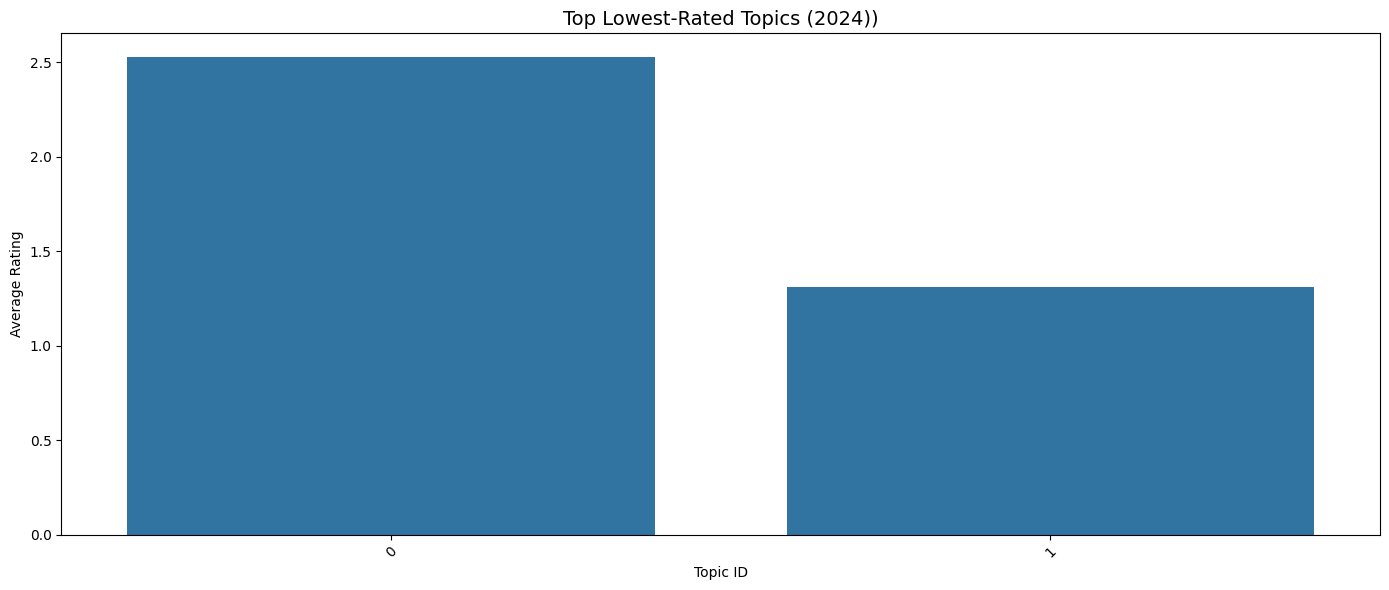


=== Topic 1 === Avg Rating: 1.31
- My kids were gluten allergic and not got proper food and I have put the request for food for allergies when I book.the tickets 4.months before. And I email them twice and instead of replying me they are calling my wude and telling them they can not do anything. Come on ...

- The airline with its customer service from baggage, to ground crew and in flight are amazing. As long as you never have to deal with the online chat customer service. several employees that I dealt with are so blunt, rude and arrogant to talk to, a real shame in the customer area, not a reflection o ...

- We booked our flights a full 9 months in advance and paid well over $11,000 for a trip in 2 weeks time. we then booked our trip around the flights. Over the past 2 months they changed our flights over 6 times resulting in over 15 hours of stop overs and delays, making the trip almost 32 hours long.
 ...


=== Topic 0 === Avg Rating: 2.53
- We used this airline to go from Singa

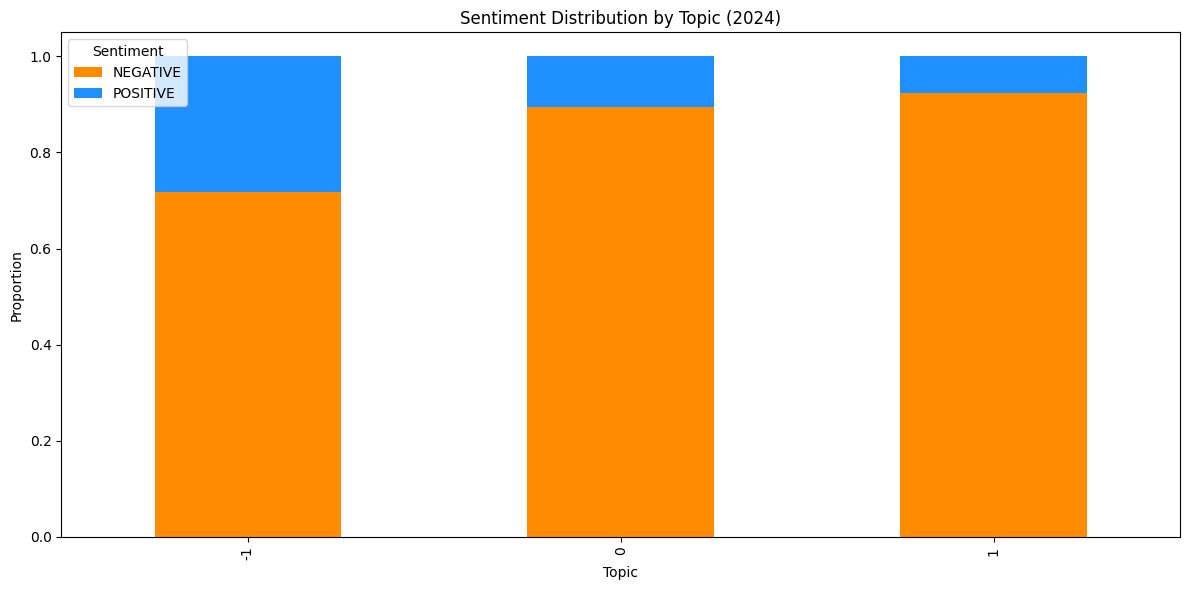


 Top Positive Keywords for 2024:
 ['singapore', 'airlines', 'flight', 'class', 'service', 'seat', 'suite', 'staff', 'crew', 'suites', 'airline', 'cabin', 'food', 'good', 'passengers', 'customer', 'flights', 'seats', 'thank', 'bed']
Top Negative Keywords for 2024:
 ['singapore', 'flight', 'airlines', 'service', 'food', 'seat', 'airline', 'economy', 'ticket', 'time', 'hours', 'premium', 'customer', 'staff', 'got', 'told', 'class', 'good', 'airport', 'seats']


In [50]:
#Loop analysis as above over each year
for year in years:
    print(f"\n Analysing Year: {year}")

    df_year = df[df['year'] == year].copy()

    df_year['text_clean'] = df_year['text']

    #BERTopic Model
    topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2") #, min_topic_size=5
    topics, _ = topic_model.fit_transform(df_year['text_clean'])
    df_year['topic'] = topics

    #Aggregate topic ratings
    topic_stats = df_year.groupby('topic')['rating'].agg(['mean', 'count']).reset_index()
    topic_stats.columns = ['Topic', 'Average Rating', 'Review Count']
    topic_stats = topic_stats[topic_stats['Topic'] != -1]
    topic_stats = topic_stats.sort_values(by='Average Rating')

    #save results for later comparison
    results_by_year[year] = {
        'df': df_year,
        'topic_stats': topic_stats,
        'topic_model': topic_model
    }

    #Visualise avg rating per topic
    plt.figure(figsize=(12,6))
    sns.barplot(data=topic_stats, x='Topic', y='Average Rating')
    plt.title(f"Average Rating by Topic ({year})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    #Get top lowest rated topics
    low_rated_topics = topic_stats.head()['Topic'].tolist()
    print(f"Lowest Rated Topics in {year}: {low_rated_topics}")
    import seaborn as sns

    #plot them
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Topic', y='Average Rating', data=topic_stats.head())
    plt.title(f"Top Lowest-Rated Topics ({year}))", fontsize=14)
    plt.ylabel("Average Rating")
    plt.xlabel("Topic ID")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    #Sample 3 reviews from each low-rated topic
    for topic_id in low_rated_topics[:5]:  #change to top 5
        print(f"\n=== Topic {topic_id} === Avg Rating: {topic_stats[topic_stats['Topic']==topic_id]['Average Rating'].values[0]:.2f}")
        reviews = df_year[df_year['topic'] == topic_id]['text'].sample(min(3, len(df_year[df_year['topic'] == topic_id])), random_state=42)
        for review in reviews:
            print("-", review[:300], "...\n")

    #Sentiment Analysis
    df_year['sentiment'] = df_year['text_clean'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])
    sentiment_dist = df_year.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)

    #Save for comparison
    sentiment_dist['year'] = year
    topic_sentiments_all_years.append(sentiment_dist.reset_index())

    #Visualise sentiment by topic
    sentiment_dist_plot = sentiment_dist.copy()

    numeric_cols = ['NEGATIVE', 'POSITIVE']
    sentiment_only = sentiment_dist_plot[numeric_cols]

    #Normalise each row (topic) to get proportions
    sentiment_normalized = sentiment_only.div(sentiment_only.sum(axis=1), axis=0)

    #Plot the normalised sentiment distribution
    sentiment_normalized.plot(kind='bar', stacked=True, figsize=(12,6), color=['#FF8C00', '#1E90FF'])  #specific colours
    plt.title(f"Sentiment Distribution by Topic ({year})")
    plt.ylabel("Proportion")
    plt.xlabel("Topic")
    plt.xticks(rotation=90)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

    #Keyword extraction by sentiment
    pos_text = " ".join(df_year[df_year['sentiment'] == 'POSITIVE']['text_clean'].values)
    neg_text = " ".join(df_year[df_year['sentiment'] == 'NEGATIVE']['text_clean'].values)

    pos_keywords = extract_keywords(pos_text)
    neg_keywords = extract_keywords(neg_text)

    all_pos_keywords[year] = pos_keywords
    all_neg_keywords[year] = neg_keywords

    print(f"\n Top Positive Keywords for {year}:\n", pos_keywords)
    print(f"Top Negative Keywords for {year}:\n", neg_keywords)




## Section 2.2 - Year-by-Year Analysis and Interpretation

### 2018
- Average Ratings: Mostly above 3.8, indicating generally strong satisfaction.
- Lowest-Rated Topics: Topics related to seat comfort, economy vs premium comparison, and boarding/check-in experience.
- Sentiment: Heavily positive across most topics.
- Highlighted Comments: Praise for premium economy, food, and service. Criticism of seat comfort and small benefits gap between premium and standard economy.

Recommendation:
- Premium Positioning: Improve differentiation of premium economy (comfort, space, perks) to justify price gap.
- Cabin Comfort Enhancements: Address seat comfort even in standard economy as it already caused early discontent.

### 2019
- Average Ratings: More fluctuation, more ratings below 3.5 compared to 2018.
- Lowest-Rated Topics:Customer service responsiveness (especially for flight changes, name issues). Booking system issues and hotline wait times.
- Sentiment: A rise in negative sentiments for operational and customer support-related topics.

Recommendation:
- Customer Support Revamp: Invest in automation and rapid-response customer support, especially for booking/changes.
- System Reliability: Improve the robustness of the booking backend to avoid flight mix-ups and scrambled names.

### 2020
- Average Ratings: Slight decline continues, although COVID disruption context matters.
- Lowest-Rated Topics: Refund process and compensation handling.
Diminished service in premium cabins (less attentive staff, lack of amenity kits).
- Sentiment: Higher negative sentiment for service consistency and cancellation support.

Recommendation:
- Refund & Disruption Transparency: Clearer communication and proactive refunds for disrupted travel.
- Premium Consistency: Reintroduce key differentiators in business and premium to retain loyalty.


### 2021
- Average Ratings: Sharp drop — ratings below 2.0 for major topics.
- Lowest-Rated Topics: Customer service (especially call centres). Flight changes with little notice and lack of refunds.
- Sentiment: Strongly negative. Sentiment reversal from earlier years.
- Comments: Express helplessness and frustration with unresponsive systems and long resolution times.

Recommendation:
- Rebuild Trust with Service:
    - Deploy a dedicated disruption resolution team.
    - Add callbacks, live chat, or local support hubs to resolve issues faster.
- Compensation Guarantees: Introduce “response in 48h” and compensation pledges during crisis periods.

### 2022
- Average Ratings: Slight recovery, but several key topics remain under 2.5.
- Lowest-Rated Topics: Lack of communication during cancellations. Service inconsistencies and seating comfort.
- Sentiment: Still heavily negative, though slightly more balance emerges.
- Comments: Continue to cite disorganised service and reactive (rather than proactive) communication.

Recommendation:
- Service SOP Reinforcement: Retrain staff on new service standards, particularly for empathy, reassurance, and situational handling.
- Proactive Passenger Management: Notify customers before they need to follow up — follow Amazon-style update alerts for every step of booking/refund.

### 2023
- Average Ratings: Patchy but slowly improving, still with a cluster of sub-3 scores.
- Lowest-Rated Topics: Handling of last-minute changes and emergency exceptions.
Clarity on ticket change/refund terms.
- Sentiment: Slightly more neutral, some return of positive sentiment for onboard experience (e.g., in-flight staff).
- Comments: Positivity toward crew, but frustration with management systems.

Recommendation:
- Policy Flexibility Layer: For emergencies or exceptions (e.g., medical or family), offer a direct appeal route.
- Frontline Excellence Campaign: Recognise and reward crew that get called out positively. Consider loyalty program incentives.

### 2024
- Average Ratings: Stable but still below pre-2020 levels.
- Lowest-Rated Topics: Trip planning issues, frequent flight rescheduling, and long refund times.
- Sentiment: Predominantly negative on topics involving money (charges, refunds, flight value).
- Comments: Users still face ticket reinstatement delays, call queues, and discomfort in economy seating.

Recommendation:
- Reliability-First Positioning:
    - Emphasize punctuality and trip planning confidence in marketing.
    - Offer a Premium Refund Promise (within 10 business days) for all ticket classes.
- Rework Economy Comfort Strategy: Focus on ergonomic upgrades and a new "Comfort Economy" class to rebuild goodwill in high-traffic budget segments.

### Consolidated Yearly Recommendations Table

Year |	Focus Area	| Insight	Recommendation
-----|--------------|-----------------------
2018 |	Comfort	| Premium and economy differentiation was weak	Upgrade premium perks, boost seat quality in economy
2019 |	Customer Support	| Booking issues & hotline failures	Improve system UX and reduce customer wait time
2020 |	Refunds & Service Gaps |	Diminished service during COVID	Reinstate premium features and streamline refund
2021	| Crisis Support	| Trust collapse in service & refunds	Deploy a dedicated issue resolution taskforce
2022	| Communication	| Lack of proactive alerts	Implement customer notifications at every stage
2023	| Policy | Flexibility	Rigid handling of edge cases	Launch compassionate support protocols
2024	| Reliability	| Continued disruptions & refund concerns	Rebrand on-time delivery and comfort-focused options


## Section 2.3 - Comparison Across Years

Now let us combine our data from the years and find out the most common positive and negative keywords used in reviews


 Most Common Positive Keywords Across All Years:
 [('flight', 7), ('singapore', 7), ('service', 7), ('airlines', 7), ('good', 7), ('food', 7), ('airline', 7), ('class', 7), ('crew', 7), ('seats', 6), ('seat', 6), ('great', 5), ('time', 5), ('staff', 5), ('economy', 5)]
 Most Common Negative Keywords Across All Years:
 [('flight', 7), ('singapore', 7), ('airlines', 7), ('service', 7), ('time', 7), ('airline', 7), ('food', 6), ('seat', 6), ('economy', 6), ('seats', 6), ('class', 6), ('good', 5), ('business', 5), ('staff', 5), ('just', 5)]


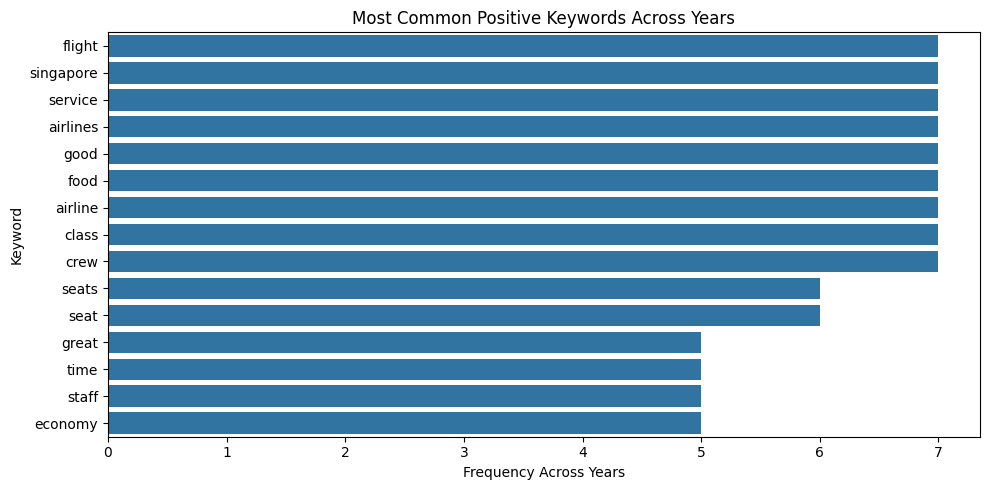

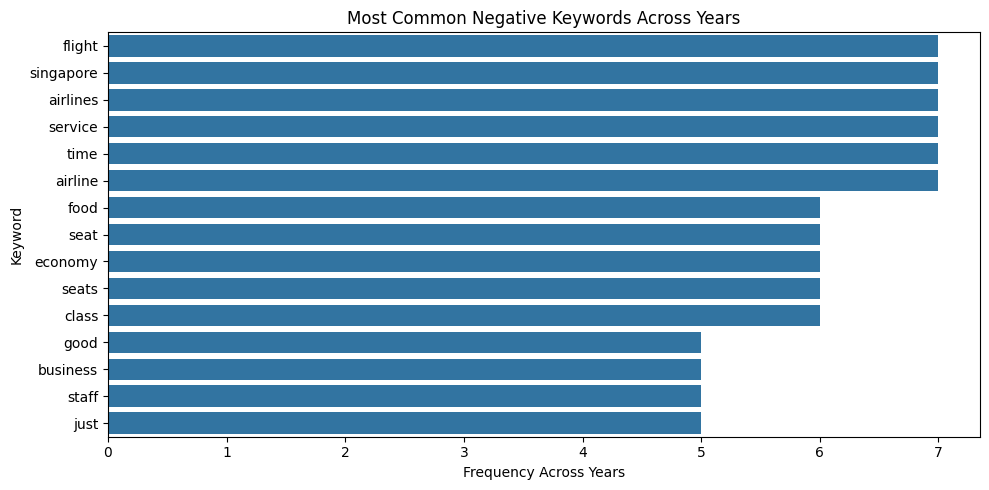

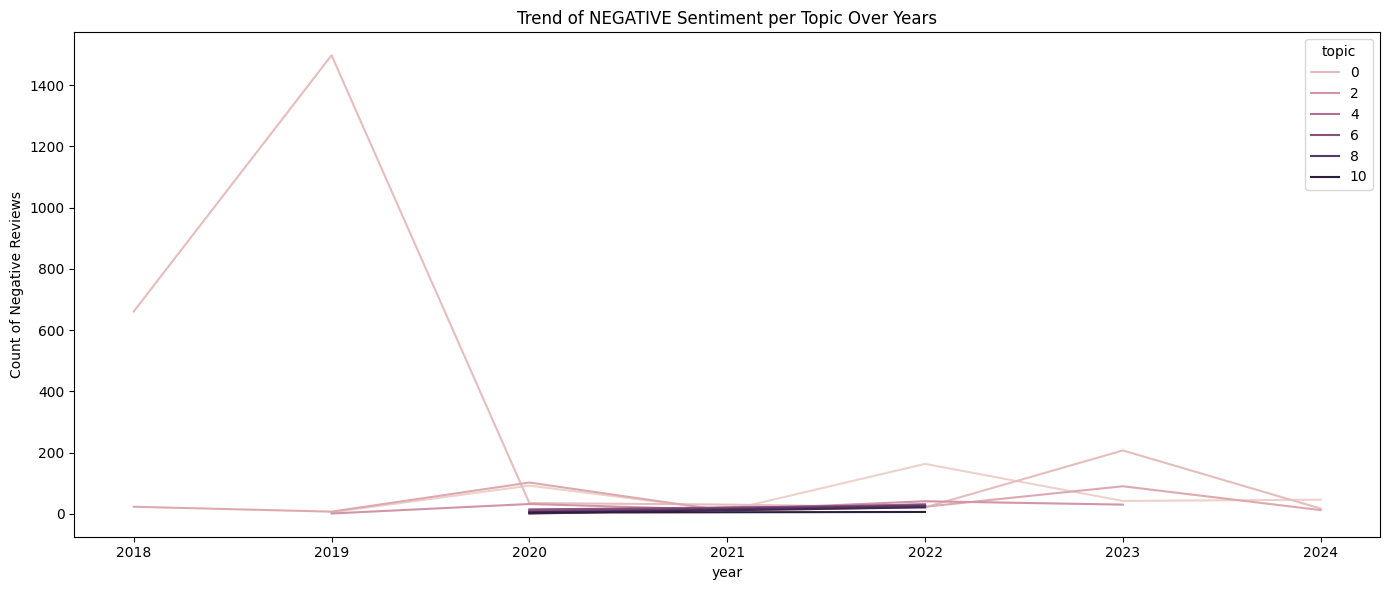

In [51]:
#most common key words
def compare_keywords(keywords_dict):
    all_words = [kw for kw_list in keywords_dict.values() for kw in kw_list]
    return Counter(all_words).most_common(15)

common_pos = compare_keywords(all_pos_keywords)
common_neg = compare_keywords(all_neg_keywords)

print("\n Most Common Positive Keywords Across All Years:\n", common_pos)
print(" Most Common Negative Keywords Across All Years:\n", common_neg)

def plot_common_keywords(keyword_counter, title):
    keywords, counts = zip(*keyword_counter)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(keywords))
    plt.title(title)
    plt.xlabel("Frequency Across Years")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

plot_common_keywords(common_pos, "Most Common Positive Keywords Across Years")
plot_common_keywords(common_neg, "Most Common Negative Keywords Across Years")


#Combine sentiment over years
combined_sentiment = pd.concat(topic_sentiments_all_years)

#Visual comparison over years
plt.figure(figsize=(14,6))
sns.lineplot(data=combined_sentiment, x='year', y='NEGATIVE', hue='topic', estimator='mean')
plt.title("Trend of NEGATIVE Sentiment per Topic Over Years")
plt.ylabel("Count of Negative Reviews")
plt.tight_layout()
plt.show()


## Section 2.3 - Per-Year BERT Topic and Sentiment Analysis (2018–2024) and Interpretation

### Key Insues and Recommendations:

#### 1. Decline in Ratings Over Time

Trend:
- 2018–2020: Mostly positive ratings across topics with high averages (~4.0–4.5).
- 2021 onwards: Dramatic drop, with average ratings in the 1.1 to 2.5 range, especially around topics 0, 3, 4, 6.

Interpretation:
- 2021 marks a turning point, coinciding with COVID-era disruptions and post-pandemic recovery.
- Certain topics remained problematic consistently (e.g., customer service, refunds, call support).

Recommendation:
- Launch a post-pandemic service quality audit focusing on call center operations, refund handling timelines, and overall customer support experience.

#### 2. Persistent Low-Rated Topics

From our visual analysis:
- Consistently low-rated topics include:
- Topic 0 – Refund/Customer Service
- Topic 3 – Flight delays/rescheduling
- Topic 4 – Booking/ticketing issues
- Topic 6 – Airport/ground staff service
- Topic 7 – Communication/follow-ups

Interpretation:
- These are systemic pain points that customers repeatedly face.
- Negative reviews contain detailed frustrations: long call wait times, missing refunds, rescheduled flights without notice, and poor responses from staff.

Recommendations:
- Develop an automated refund tracking portal.
- Upskill call center agents and staff with empathy and resolution training.
- Create a real-time customer notification system for cancellations/changes.

#### 3. Sentiment Shift

Observations:
- Sentiment distribution by topic shows a notable increase in negative sentiment from 2020 onwards, peaking in 2021–2022.
- Even in previously well-rated areas (e.g., staff, cabin experience), negative keywords increased.

Recommendations:
- Deploy sentiment monitoring systems per topic to catch dips in real-time.
- Conduct internal customer journey mapping per service channel to isolate when and where frustrations start.

#### 4. Keyword Trends
Positive Keywords: "flight", "singapore", "service", "good", "crew", "seats", "staff", "economy"

Negative Keywords: Same core themes ("flight", "service", "airlines", "staff", "food", "seats") appear on both lists – a critical signal.

Keywords like "told", "customer", "ticket", and "call" emerge more strongly post-2021, hinting at frustrations with communication and support channels.

Interpretation:
- These keywords act as polarising touchpoints.
- Indicates inconsistent delivery: e.g., great service on some flights, poor on others.

Recommendations:
- Apply route-level service consistency metrics (e.g., SQ348 vs. SQ308) to spot high-variance segments.
- Introduce feedback-linked performance incentives for cabin/ground staff.

#### 5. Topic-Level Negative Trend

Observations:
- Topic 0 dominates in negative reviews over the years.
- Topics 3, 4, and 7 have steady presence in the bottom cluster.
- Drastic spikes in 2019–2022.
- For Topic 0, sample texts indicate issues with customer service communication, accessibility support, and seat allocation.

Recommendations:
- Introduce triage ticketing system that categorises incoming complaints into these key themes.
- Use ML or keyword flagging to prioritise escalations for recurring issue categories.

### Consolidated Recommendations Table (Based on Year-by-Year Analysis)

Focus Area |	Actionable Recommendation
-----------|---------------------------
Refunds	| Automate refund tracking - allow real-time tracking through app/SMS
Staff Training	| Reinvest in staff retraining post-COVID to restore perceived service quality, politeness, and attentiveness.. Soft-skill, cultural sensitivity & conflict resolution workshops
Booking & Ticketing	| Simplify UX on website & app – remove hidden steps, clearly list policies
Loyalty Recovery (Post-2021)	| Run win-back campaigns targeting users with unresolved issues in 2021–2022
Sentiment Tracking	| Integrate review monitoring dashboards with monthly alerts by topic category
Customer Support Channels	| Improve clarity and responsiveness in call center and online booking flows. Include multilingual support.
Seating Experience	| Redesign economy seat configurations for legroom and comfort. Prioritise family and infant accommodations.
Inconsistency in Service	| Audit service across routes – assign QA teams for monthly review. tandardise food and amenity offerings across routes. Address gaps in premium and economy delivery.
Proactive Communication	| Create a real-time notification system for cancellations/changes with clear compensation or rebooking flows.

# Section 2 - By-period Analysis

Let us now complete the same analysis but this time for 2 distinct time periods, pre and post 2021, (2021 included in the 'post') to see if we can see any trends in the topics of positive and negative ratings both before and after the fall in reviews to then generate some recommendations

## Section 2.1 - Setup and Loop

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [53]:
#Sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

#Keyword extraction definition
def extract_keywords(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform([texts])
    scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_scores[:top_n]]

#Slice by period
df_pre = df[df['year'] < 2021].copy()
df_post = df[df['year'] >= 2021].copy()

periods = {
    "Pre-2021 (2018–2020)": df_pre,
    "Post-2021 (2021–2024)": df_post
}

#setup for later
results_by_period = {}
sentiment_dist_all = []

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0



 Analysing: Pre-2021 (2018–2020)


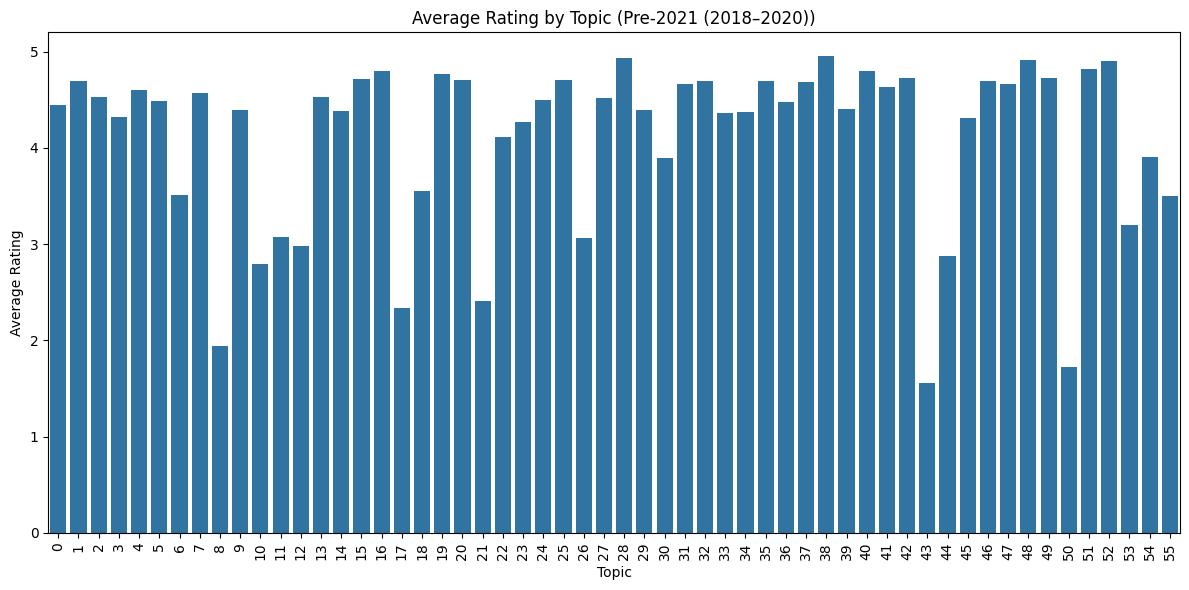


Lowest Rated Topics in Pre-2021 (2018–2020): [43, 50, 8, 17, 21]


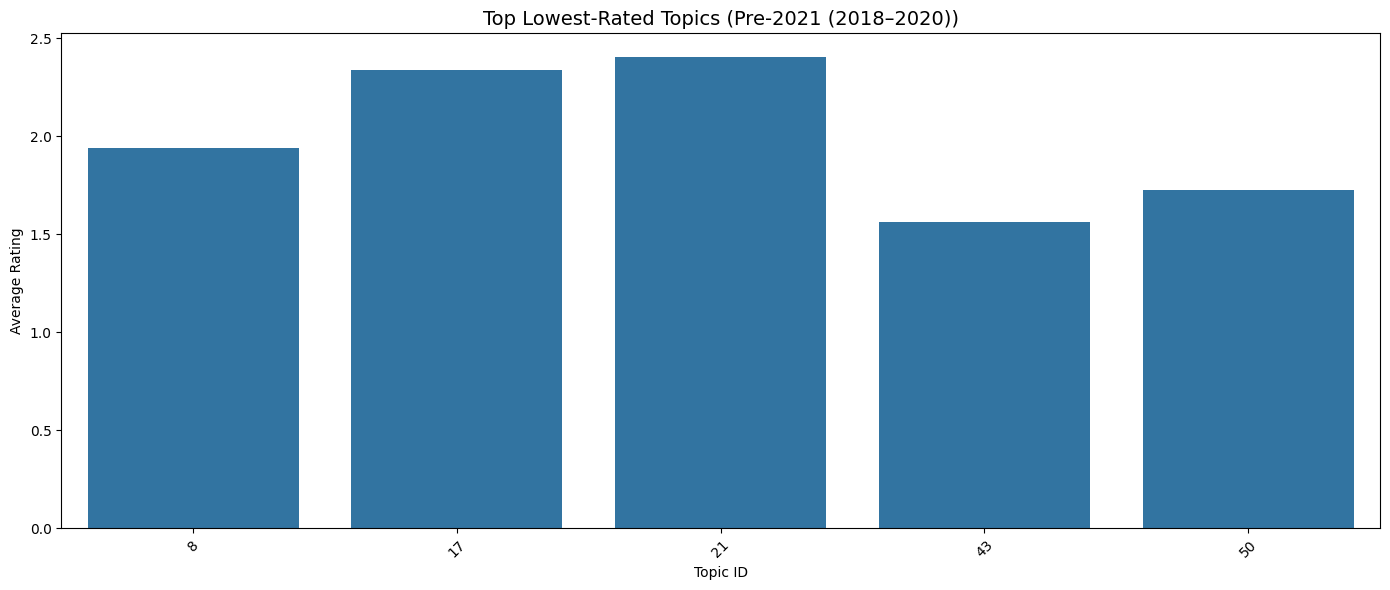


=== Topic 43 === Avg Rating: 1.56
- I was doing work on my lap top Brand new Mac Air like i always do on flights when suddenly the person in front of me put their seat back The new design with the Head set plug in on the back of the seat (instead of on the arm rest like they used to be)
as she put her seat back the head set frame plug ...

- I forgot my headset on the seat while leaving the plane and within 10 minutes I went to lounge and inform. Not only that they didn’t do anything about it and held me there for 1 hour waiting but the attitude of the staff was extremely rude, discriminatory  and impolite. 

I have followed up for more ...

- We were returning from our holiday in Vietnam and travelled premium economy for the leg Singapore to Sydney. 
Our SIA flight out of Saigon was delayed several hours due to an aircraft problem so we were then pushed back to a later flight out of Singapore than the one we had booked. 

We were very di ...


=== Topic 50 === Avg Rating: 1.73
- We b

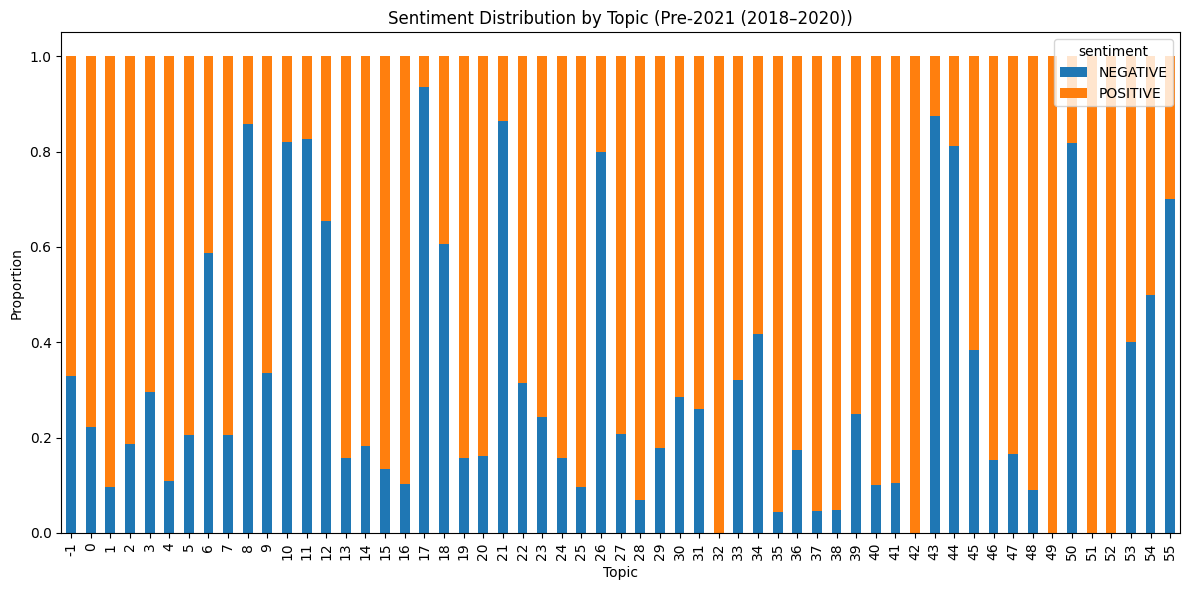

Top POSITIVE keywords in Pre-2021 (2018–2020):
 ['flight', 'singapore', 'service', 'airlines', 'good', 'food', 'great', 'airline', 'time', 'staff', 'class', 'crew', 'comfortable', 'seats', 'economy', 'excellent', 'entertainment', 'seat', 'fly', 'best']
Top NEGATIVE keywords in Pre-2021 (2018–2020):
 ['flight', 'singapore', 'airlines', 'service', 'food', 'seat', 'economy', 'seats', 'airline', 'time', 'good', 'class', 'business', 'staff', 'just', 'flights', 'crew', 'sq', 'plane', 'premium']


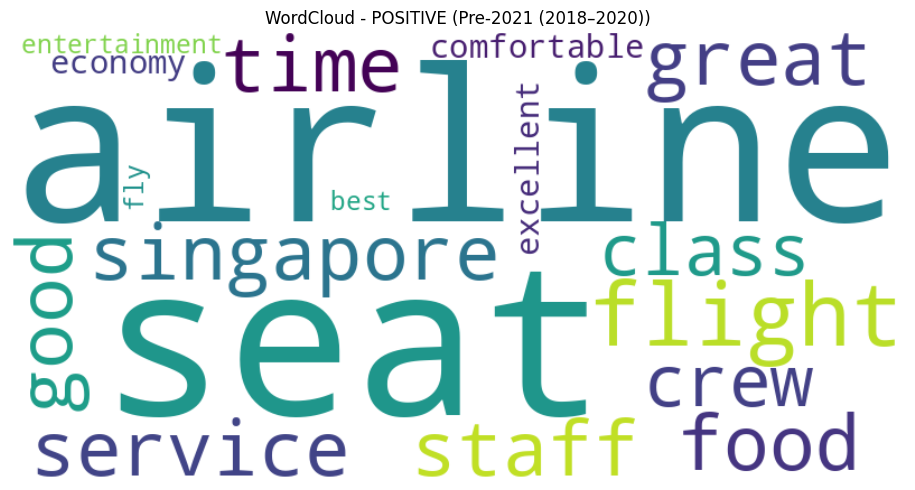

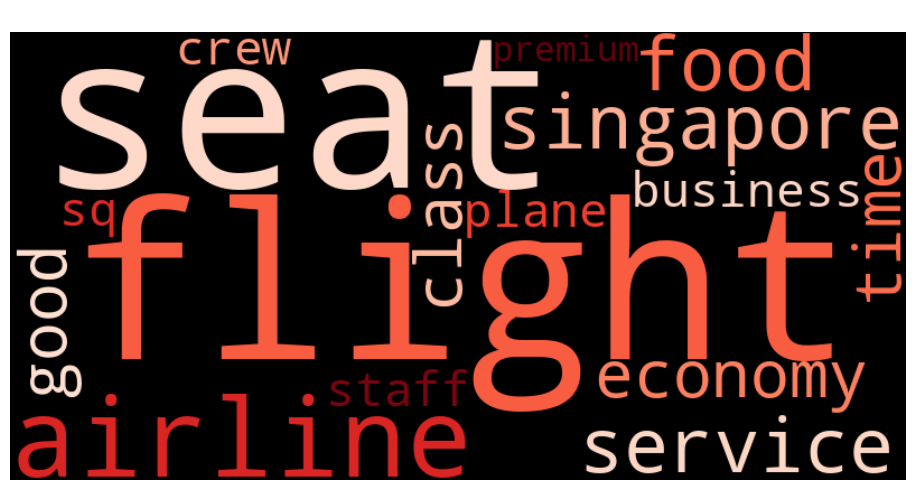


 Analysing: Post-2021 (2021–2024)


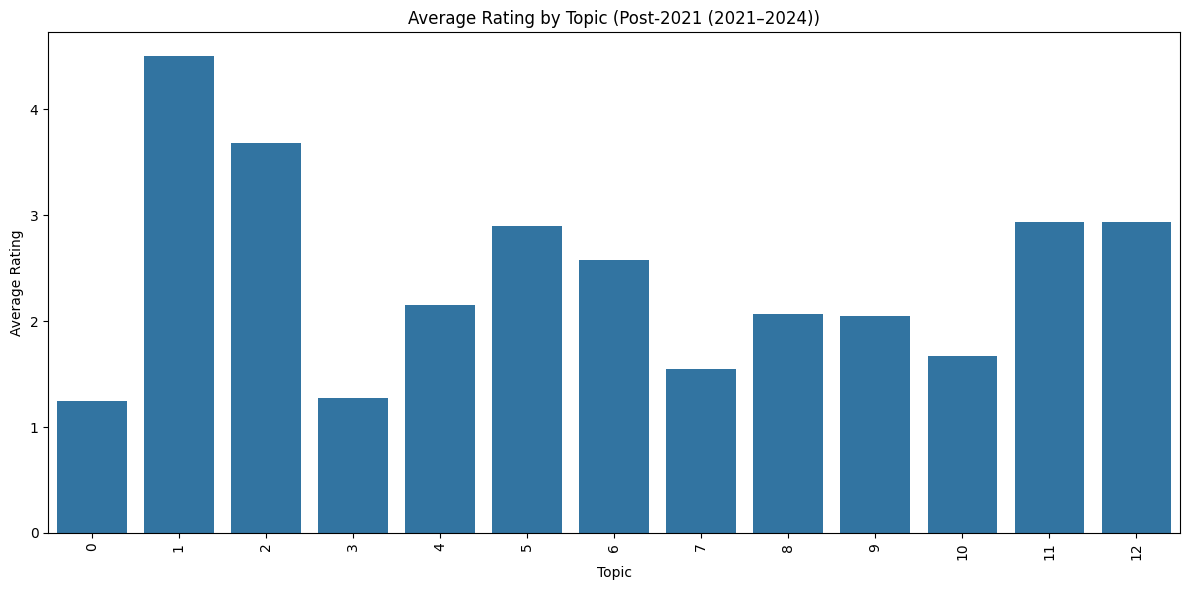


Lowest Rated Topics in Post-2021 (2021–2024): [0, 3, 7, 10, 9]


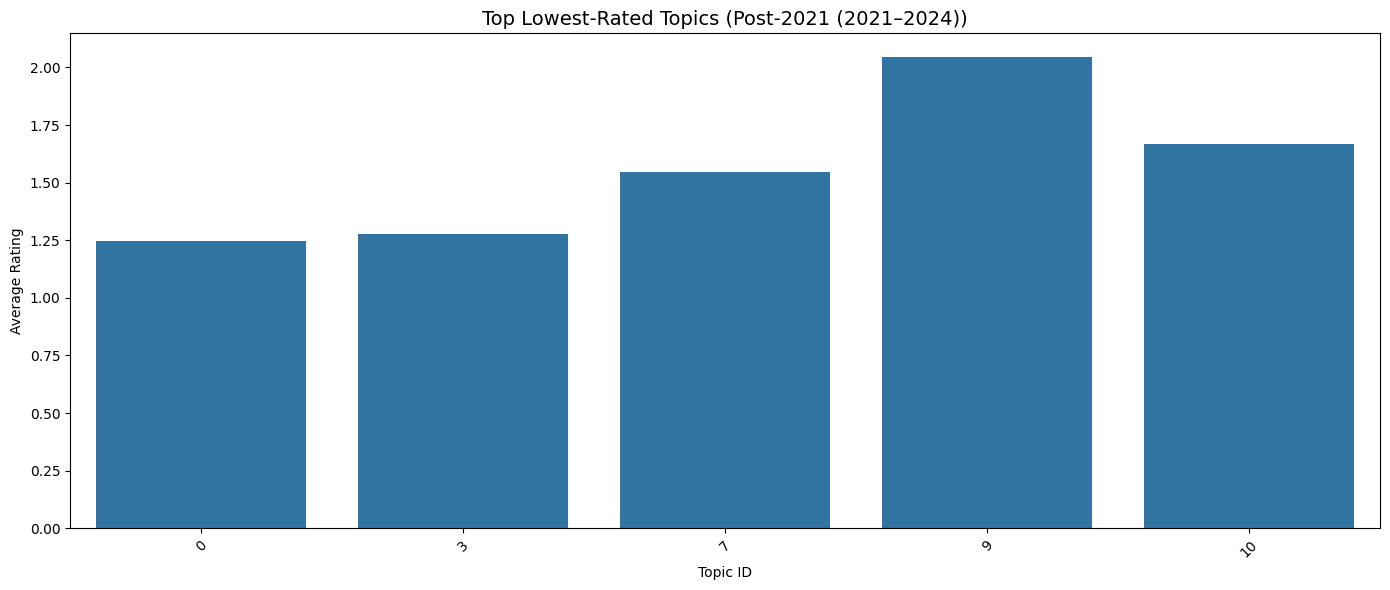


=== Topic 0 === Avg Rating: 1.24
- I’d had a 2 month trip to Bali planned, and bought a ticket through a comparison website to fly with Singapore airlines. I checked in 48 hours before and the next day received a call from Steve at Singapore airlines Manchester to tell me my ticket was not valid and they had tried to contact the comp ...

- Singapore Airlines feedback channel is one of the worst in the industry. Not only do they ignore customer feedback and request all the time, they also reply in a rude and unapologetic manner when eventually they do.

I have no idea where SQ hires all these customer service personnel from? Those that ...

- I am beyond frustrated writing this review. I have never experienced such unprofessional behavior in my life. I wanted to change my date of departure so I tried to change it through the Singapore Airlines website. I tried to pay the difference in the fare as shown on the website. My payment could no ...


=== Topic 3 === Avg Rating: 1.28
- My Bri

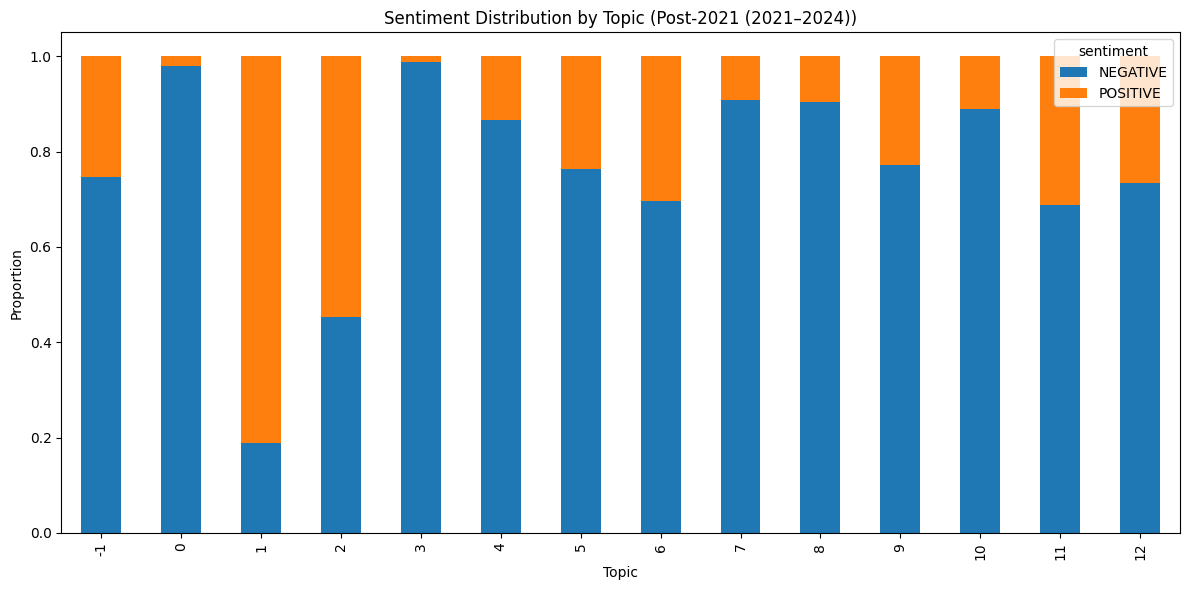

Top POSITIVE keywords in Post-2021 (2021–2024):
 ['flight', 'singapore', 'airlines', 'service', 'good', 'class', 'food', 'crew', 'business', 'seat', 'economy', 'seats', 'great', 'airline', 'time', 'cabin', 'staff', 'experience', 'flights', 'passengers']
Top NEGATIVE keywords in Post-2021 (2021–2024):
 ['flight', 'singapore', 'airlines', 'service', 'airline', 'time', 'food', 'economy', 'seat', 'customer', 'class', 'hours', 'flights', 'seats', 'just', 'business', 'told', 'staff', 'ticket', 'experience']


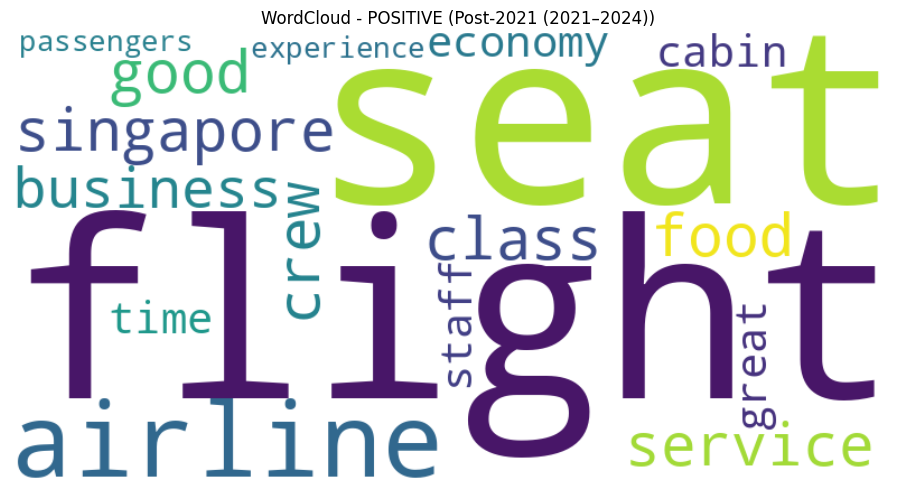

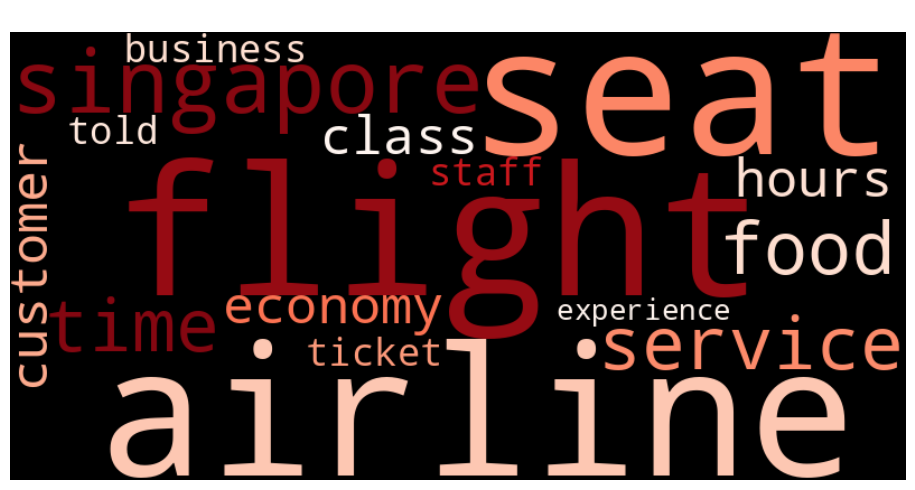

In [73]:
#Loop analysis over periods
for period, data in periods.items():
    print(f"\n Analysing: {period}")
    data['text_clean'] = data['text']

    #BERTopic Modelling
    topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")
    topics, _ = topic_model.fit_transform(data['text_clean'])
    data['topic'] = topics

    #Aggregate ratings
    topic_stats = data.groupby('topic')['rating'].agg(['mean', 'count']).reset_index()
    topic_stats.columns = ['Topic', 'Average Rating', 'Review Count']
    topic_stats = topic_stats[topic_stats['Topic'] != -1]
    topic_stats = topic_stats.sort_values(by='Average Rating')

    results_by_period[period] = {
        'df': data,
        'topic_stats': topic_stats,
        'topic_model': topic_model
    }

    #Average Rating per Topic for each period
    plt.figure(figsize=(12,6))
    sns.barplot(data=topic_stats, x='Topic', y='Average Rating')
    plt.title(f"Average Rating by Topic ({period})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    #Extract lowest rated topics
    low_rated = topic_stats.head()['Topic'].tolist()
    print(f"\nLowest Rated Topics in {period}: {low_rated}")

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Topic', y='Average Rating', data=topic_stats.head())
    plt.title(f"Top Lowest-Rated Topics ({period})", fontsize=14)
    plt.ylabel("Average Rating")
    plt.xlabel("Topic ID")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    for topic_id in low_rated[:5]:
        print(f"\n=== Topic {topic_id} === Avg Rating: {topic_stats[topic_stats['Topic']==topic_id]['Average Rating'].values[0]:.2f}")
        reviews = data[data['topic'] == topic_id]['text'].sample(min(3, len(data[data['topic'] == topic_id])), random_state=42)
        for review in reviews:
            print("-", review[:300], "...\n")

    #Sentiment analysis
    data['sentiment'] = data['text_clean'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

    sentiment_dist = data.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)
    sentiment_dist['Period'] = period
    sentiment_dist_all.append(sentiment_dist.reset_index())

    #Visualise sentiment
    norm_sentiment = sentiment_dist.copy()

    non_numeric_cols = norm_sentiment.select_dtypes(include='object').columns
    norm_sentiment_numeric = norm_sentiment.drop(columns=non_numeric_cols)

    #Normalise row-wise
    norm_sentiment_numeric = norm_sentiment_numeric.div(norm_sentiment_numeric.sum(axis=1), axis=0)

    #Add back non-numeric columns for plotting
    norm_sentiment_normalized = pd.concat([norm_sentiment_numeric, norm_sentiment[non_numeric_cols]], axis=1)

    #Select only valid sentiment columns to plot -> +ve or -ve ones
    valid_sent_cols = [col for col in ['NEGATIVE', 'POSITIVE'] if col in norm_sentiment_normalized.columns]
    norm_sentiment_normalized[valid_sent_cols].plot(kind='bar', stacked=True, figsize=(12, 6))

    plt.title(f"Sentiment Distribution by Topic ({period})")
    plt.ylabel("Proportion")
    plt.xlabel("Topic")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    #Extract Keywords
    pos_text = " ".join(data[data['sentiment'] == 'POSITIVE']['text_clean'].values)
    neg_text = " ".join(data[data['sentiment'] == 'NEGATIVE']['text_clean'].values)
    pos_keywords = extract_keywords(pos_text)
    neg_keywords = extract_keywords(neg_text)

    results_by_period[period]['pos_keywords'] = pos_keywords
    results_by_period[period]['neg_keywords'] = neg_keywords
    print(f"Top POSITIVE keywords in {period}:\n", pos_keywords)
    print(f"Top NEGATIVE keywords in {period}:\n", neg_keywords)


    #Visualise Top Keywords for POSITIVE and NEGATIVE Reviews
    #from collections import Counter

    def plot_keywords(keywords, sentiment_type, period_label):
        keyword_freq = Counter(keywords)
        top_keywords = keyword_freq.most_common(10)
        words, counts = zip(*top_keywords)

   #     plt.figure(figsize=(10, 4))
    #    sns.barplot(x=list(counts), y=list(words), palette="coolwarm" if sentiment_type == "NEGATIVE" else "crest")
     #   plt.title(f"Top {sentiment_type} Keywords - {period_label}")
      #  plt.xlabel("Frequency")
       # plt.ylabel("Keyword")
        #plt.tight_layout()
        #plt.show()

    #Plot POSITIVE keywords
    #plot_keywords(pos_keywords, sentiment_type="POSITIVE", period_label=period)

    #Plot NEGATIVE keywords
    #plot_keywords(neg_keywords, sentiment_type="NEGATIVE", period_label=period)


    #WordClouds
    #POSITIVE
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(" ".join(pos_keywords)) #colour and white for pos
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - POSITIVE ({period})")
    plt.tight_layout()
    plt.show()

    #NEGATIVE
    wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(" ".join(neg_keywords)) #black and red for neg
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - NEGATIVE ({period})", color='white')
    plt.tight_layout()
    plt.show()





### 2.2 - Key Interpretations and Recommendations of 2.1

1. Ratings and Sentiment:
- Pre-2021 has consistently higher ratings (avg. 4.2–4.5) and a strong dominance of positive sentiment.
- Post-2021, there's a broader spread across topics, and multiple topics drop below 3 stars with more negative than positive sentiment, especially on topics like Topic 0, 3, 5, 9.

2. WordCloud and Keyword Shift:
- Positive keywords remain similar in both periods: "flight", "service", "seat", "crew", "food", but the same words also feature in negative contexts, showing polarization in experiences.
- Post-2021 negative keywords include "customer", "ticket", "told", "staff", suggesting a growing frustration with interactions and service recovery processes.

3. Expanded Topic Spread (Post-2021):
- The emergence of more topics post-2021 suggests diversification in complaints — beyond flight experience to booking, refund policies, communication gaps, and even misinformation in support channels.

### Recommendations from Section 2.1:

Issue Highlighted	| Strategic Recommendation
------------------|-------------------------
Booking & Tech Errors	| Streamline online systems and provide real-time support agents for failed bookings.
Customer Trust Recovery	| Launch a service guarantee and compensation program to rebuild trust after disruptions.
Language & Accessibility Support	| Train staff and develop channels that accommodate different languages and elderly needs.
Product Experience Gaps	| Address inconsistencies in food quality, amenity kits, and entertainment, especially in Premium Economy.
Human Touch in Resolution	| Introduce a concierge-style escalation team for critical customer service complaints.

###Overall Strategic Outlook:
2018–2020 was marked by strong brand loyalty and product satisfaction.
Post-2021, Singapore Airlines saw a notable decline in perception, particularly around customer interaction, technical infrastructure, and economy seating.
A hybrid approach combining operational excellence with empathetic service recovery is key to regaining confidence.


## Section 2.3 - Period Comparison
Now we have looked at sentiment and ratings, let us have a closer look at the keywords in topics over the periods and see if we can draw meaningful insights and recommendations from this. Let us also do a more general comparison of trends across the two periods

In [74]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize_clean(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 Keyword Comparison for: Pre-2021 (2018–2020)
Top POSITIVE keywords in Pre-2021 (2018–2020):
 [('flight', 6354), ('singapore', 6121), ('service', 4130), ('airlines', 4054), ('good', 3675), ('food', 3479), ('great', 2249), ('airline', 2110), ('time', 2012), ('staff', 1986)]
Top NEGATIVE keywords in Pre-2021 (2018–2020):
 [('flight', 3643), ('singapore', 3408), ('airlines', 2034), ('service', 1631), ('food', 1470), ('seat', 1400), ('economy', 1284), ('seats', 1264), ('airline', 1116), ('good', 1110)]


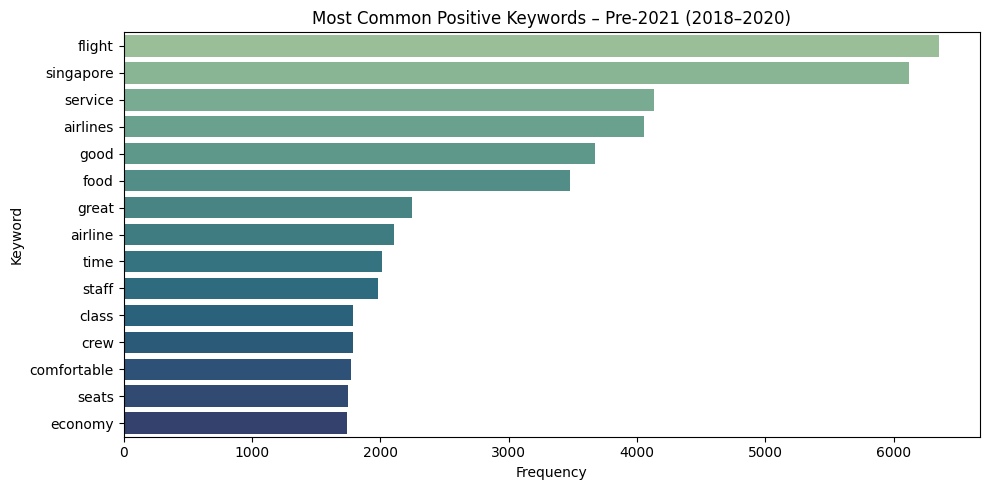

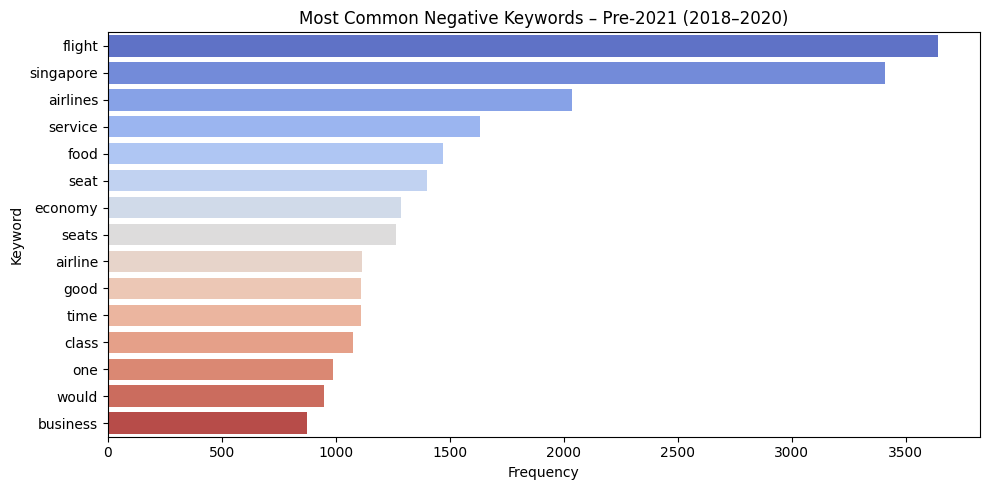


 Keyword Comparison for: Post-2021 (2021–2024)
Top POSITIVE keywords in Post-2021 (2021–2024):
 [('singapore', 483), ('flight', 477), ('airlines', 350), ('service', 277), ('good', 210), ('class', 203), ('food', 197), ('crew', 180), ('seat', 148), ('business', 147)]
Top NEGATIVE keywords in Post-2021 (2021–2024):
 [('flight', 1708), ('singapore', 1664), ('airlines', 1099), ('service', 825), ('airline', 603), ('would', 491), ('time', 451), ('one', 445), ('food', 435), ('economy', 410)]


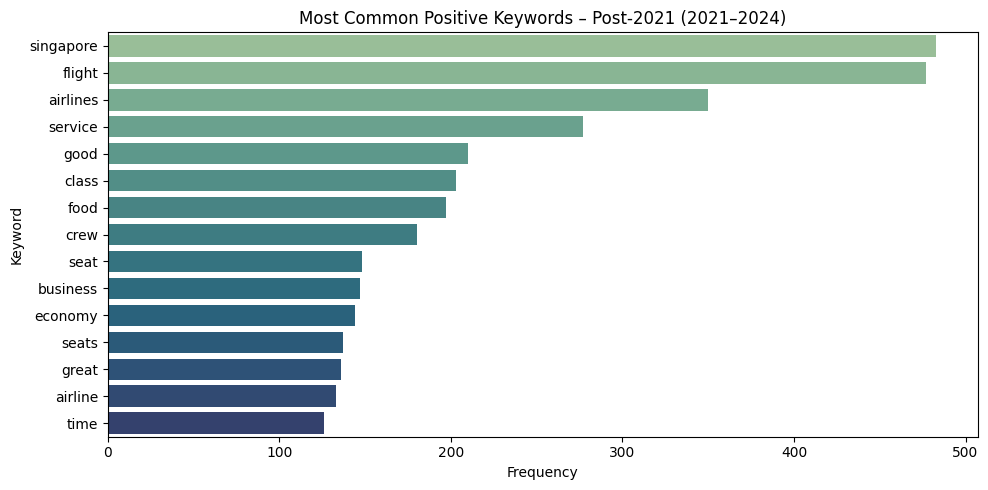

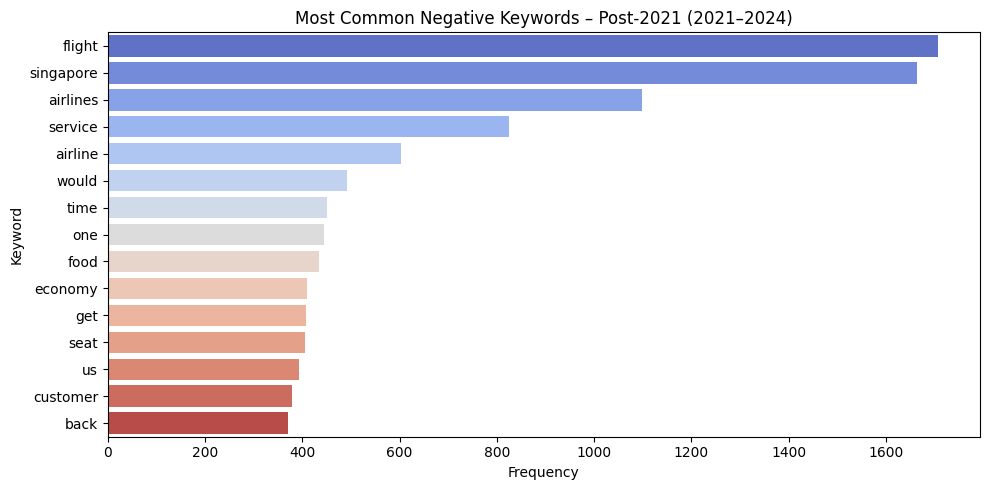

In [75]:
#get most common pos and neg keywords
def plot_common_keywords(keywords, title, color_palette="crest"):
    keyword_counter = Counter(keywords)
    if not keyword_counter:
        print(f"No keywords found for: {title}")
        return
    keywords, counts = zip(*keyword_counter.most_common(15))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(keywords), palette=color_palette)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()


#Loop through periods and plot
for period in results_by_period.keys():
    print(f"\n Keyword Comparison for: {period}")

    #make sure correct ata
    data = results_by_period[period]['df']

    #Keyword extraction
    pos_text = " ".join(data[data['sentiment'] == 'POSITIVE']['text_clean'].values)
    neg_text = " ".join(data[data['sentiment'] == 'NEGATIVE']['text_clean'].values)

    #use tokenized version
    pos_keywords = tokenize_clean(pos_text)
    neg_keywords = tokenize_clean(neg_text)


    results_by_period[period]['pos_keywords'] = pos_keywords
    results_by_period[period]['neg_keywords'] = neg_keywords

    print(f"Top POSITIVE keywords in {period}:\n", Counter(pos_keywords).most_common(10))
    print(f"Top NEGATIVE keywords in {period}:\n", Counter(neg_keywords).most_common(10))

    #Visualise
    plot_common_keywords(pos_keywords, f"Most Common Positive Keywords – {period}", color_palette="crest")
    plot_common_keywords(neg_keywords, f"Most Common Negative Keywords – {period}", color_palette="coolwarm")


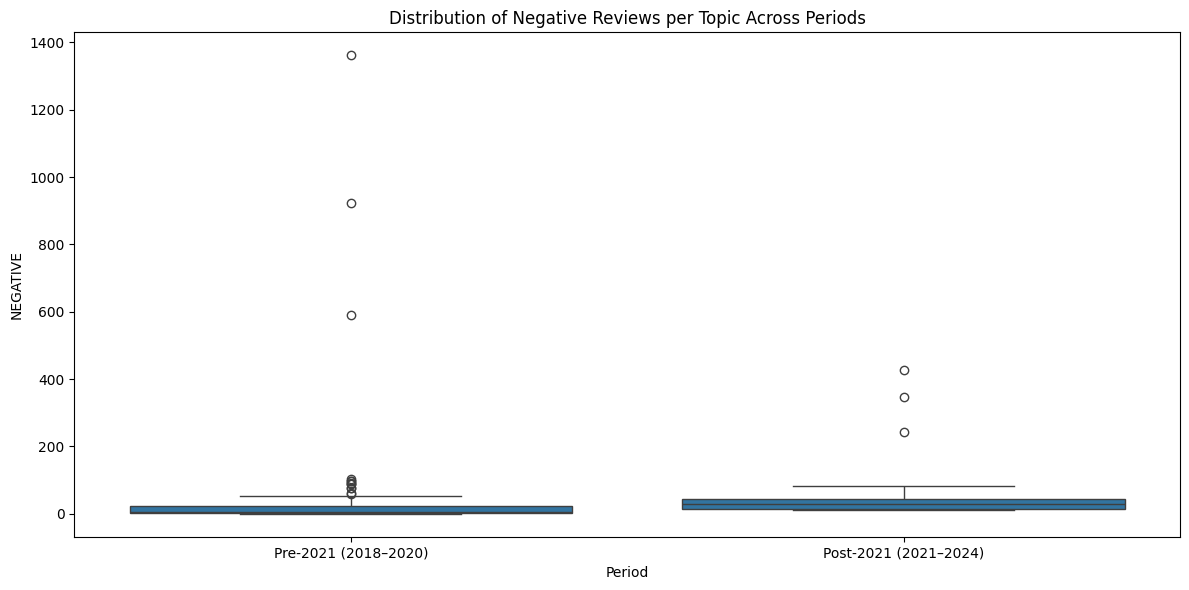

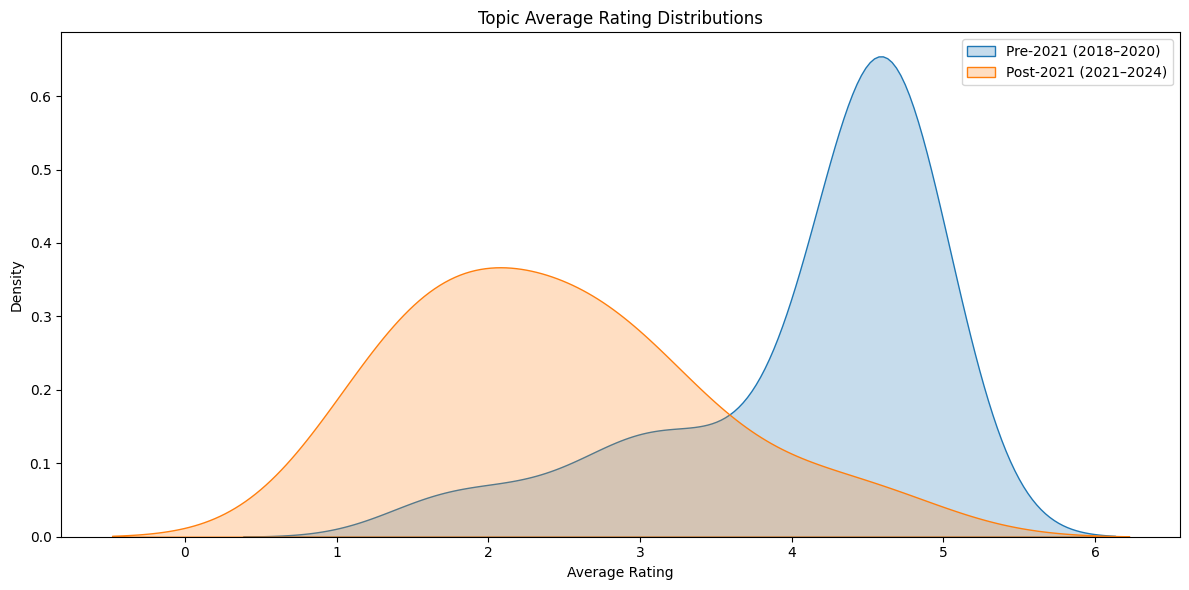

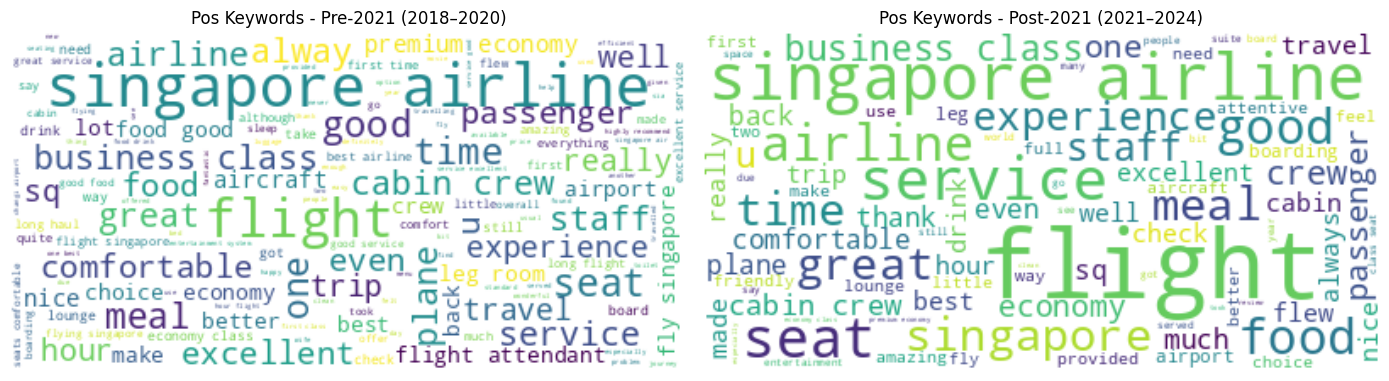

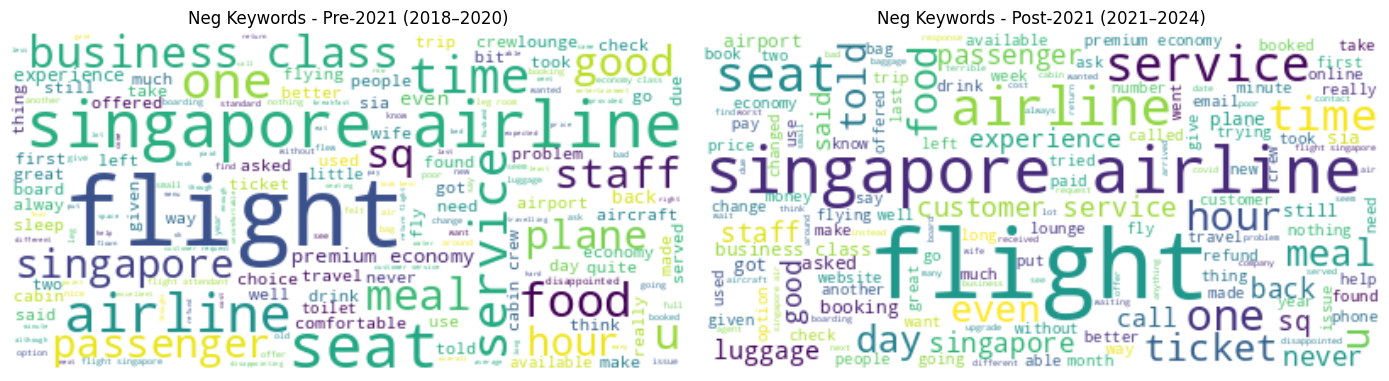

In [76]:
#Combine sentiment data
sentiment_all = pd.concat(sentiment_dist_all)

#Compare NEGATIVE sentiment volume
plt.figure(figsize=(12,6))
sns.boxplot(data=sentiment_all, x='Period', y='NEGATIVE')
plt.title("Distribution of Negative Reviews per Topic Across Periods")
plt.tight_layout()
plt.show()

#Compare average ratings
plt.figure(figsize=(12,6))
for period in results_by_period:
    ratings = results_by_period[period]['topic_stats']['Average Rating']
    sns.kdeplot(ratings, label=period, fill=True)
plt.title("Topic Average Rating Distributions")
plt.legend()
plt.tight_layout()
plt.show()

#Compare keywords
for sentiment in ['pos_keywords', 'neg_keywords']:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    for i, (period, res) in enumerate(results_by_period.items()):
        text = " ".join(res[sentiment])
        wc = WordCloud(background_color='white').generate(text)
        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].set_title(f"{sentiment.split('_')[0].capitalize()} Keywords - {period}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


## Section 2.4 - Key Insights and Recommendations from Comparison Analysis

### Key Insihgts:
#### 1. Keywords Shift
- Pre-2021 Positive: “excellent,” “comfortable,” “crew,” “entertainment,” “meal.”
- Post-2021 Positive: Still includes “flight,” “service,” and “seat,” but with reduced volume and more diluted sentiment.
- Post-2021 Negative Keywords: Additions like “told,” “ticket,” “customer,” “back” — indicating disputes, refunds, and complaints.

#### 2. Density Plots
- Rating Distribution Shift: Pre-2021 ratings are tightly clustered around 4.5–5.0. Post-2021 shows a broad and skewed drop, clustering around 2.5–3.0, with a heavier tail towards very low scores.

####3. Sentiment-Driven Ratings
- Strong correlation between sentiment polarity and rating.
- Notably, post-2021 very negative reviews yield much lower average ratings than similar sentiment in pre-2021. Indicates rising customer frustration.

###Recommendations from Period Comparison Analysis:
#### 1. Address the Root Causes of Sentiment Decline
- The increase in words like "customer", "ticket", "back", and "hours" signals operational failures.
- Recommendation: Invest in customer journey mapping post-COVID to identify critical pain points in ticketing and service touchpoints.

####2. Win Back Customer Trust Post-COVID
- Perception has shifted drastically since the pandemic.
- Recommendation: Launch a transparency and recovery campaign showcasing service improvements and emphasizing reliability, care, and responsiveness.

#### 3. Monitor Emerging Trends
- Words like “wardrobe,” “processed,” and “cushioning” emerged post-2021 — these might be related to complaints about cabin layout, amenities, or handling of baggage.
- Recommendation: Set up a keyword-triggered alert system to flag rising customer concerns before they scale.

# Section 3 - Period in Depth Analysis

Now let us perform a more in-depth analysis on the period periods, especially post 2021 (2021 included), we want to look at, in more detail, the keywords used in reviews during and after the fall in ratings and have a closer look at them and the sentiment of their ratings and the intensity of them

## Section 3.1 - Keyword Rank Delta Analysis

In [77]:
from nltk.corpus import stopwords #need to keep importing to colab, unsure why
from nltk.tokenize import word_tokenize
from collections import Counter

stop_words = set(stopwords.words('english'))

def tokenize_clean(text):
    tokens = word_tokenize(text.lower())
    return [w for w in tokens if w.isalpha() and w not in stop_words]


pos_text_pre = " ".join(df_pre[df_pre['sentiment'] == 'POSITIVE']['text_clean'])
pos_text_post = " ".join(df_post[df_post['sentiment'] == 'POSITIVE']['text_clean'])

#Tokenize and count
tokens_pre = tokenize_clean(pos_text_pre)
tokens_post = tokenize_clean(pos_text_post)

counter_pre = Counter(tokens_pre)
counter_post = Counter(tokens_post)

#Rank delta
pre_ranks = {k: i+1 for i, (k, _) in enumerate(counter_pre.most_common())}
post_ranks = {k: i+1 for i, (k, _) in enumerate(counter_post.most_common())}

delta_ranks = {}
for word in post_ranks:
    if word in pre_ranks:
        delta_ranks[word] = pre_ranks[word] - post_ranks[word]
    else:
        delta_ranks[word] = 'NEW'

#Output the key differences
delta_keywords = sorted([(k, v) for k, v in delta_ranks.items() if isinstance(v, int)], key=lambda x: -x[1])
new_keywords = [k for k, v in delta_ranks.items() if v == 'NEW']

print("Most Increased in Rank Post-2021:", delta_keywords[:10])
print("Keywords Only in Post-2021:", new_keywords[:10])


Most Increased in Rank Post-2021: [('wardrobe', 10030), ('cushioning', 9721), ('oversized', 9710), ('processed', 9541), ('listened', 9378), ('paul', 9281), ('distractions', 9098), ('tripadvisor', 9017), ('convey', 8954), ('linda', 8950)]
Keywords Only in Post-2021: ['christine', 'tape', 'restrictions', 'kavitha', 'deniece', 'sharifah', 'swivelled', 'tui', 'supposedly', 'writer']


## Interpretation of Rank Delta Output (Most Increased in Rank & New Keywords Post-2021)

### Most Increased in Rank Post-2021:
- Words like “wardrobe”, “cushioning”, “oversized”, “processed”, “listened”, “paul”, “distractions”, “tripadvisor”, “convey”, and “linda” saw the largest jumps in rank post-2021.
- Many of these are quite specific and personal in tone, suggesting:
    - An influx of personal narratives or complaints tied to individual experiences with customer service or specific events (e.g., the presence of first names like "paul", "linda").
    - A greater emphasis on comfort and space issues, as seen with terms like wardrobe, cushioning, and oversized – potentially pointing to cabin layout dissatisfaction or baggage complaints.

### Keywords Only Seen in Post-2021:
- New mentions include “tape”, “restrictions”, “swivelled”, “supposedly”, “tripadvisor”, and again, multiple personal names.
- This implies:
  - Post-2021 reviews reflect more diverse, detailed, and issue-specific complaints, especially those triggered by post-pandemic travel restrictions, policy confusion, or specific service lapses.
  - Keywords like “restrictions” and “tripadvisor” also hint at policy backlash and customers possibly being motivated to vent after comparing expectations with online reviews.

###Implications & Recommendations:
- Service Personalisation Needs Improvement: Mentions of names and personalized complaints suggest breakdowns in human-centric service. Staff training in empathy and ownership should be revisited.
- Comfort Complaints Are Rising: The rise of words like cushioning and oversized indicates dissatisfaction with space and seat design – consider seat upgrades or clearer comfort-related communication pre-flight.
- Travel Policy Transparency: Keywords like restrictions and processed suggest frustration with hidden conditions or red tape. Review post-COVID policy documentation and make FAQs, support contacts, and exceptions more visible and digestible.
- Reputation Management Opportunity: The appearance of Tripadvisor suggests reviews are actively influencing sentiment. Proactive outreach or responses to online feedback could improve brand perception.

## Section 3.2 - Sentiment Intensity Analysis

Now let us focus on the intensity of the sentiment of reviews post 2021, we want to see how negative the reviews are and how many of them are strongly negative?

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


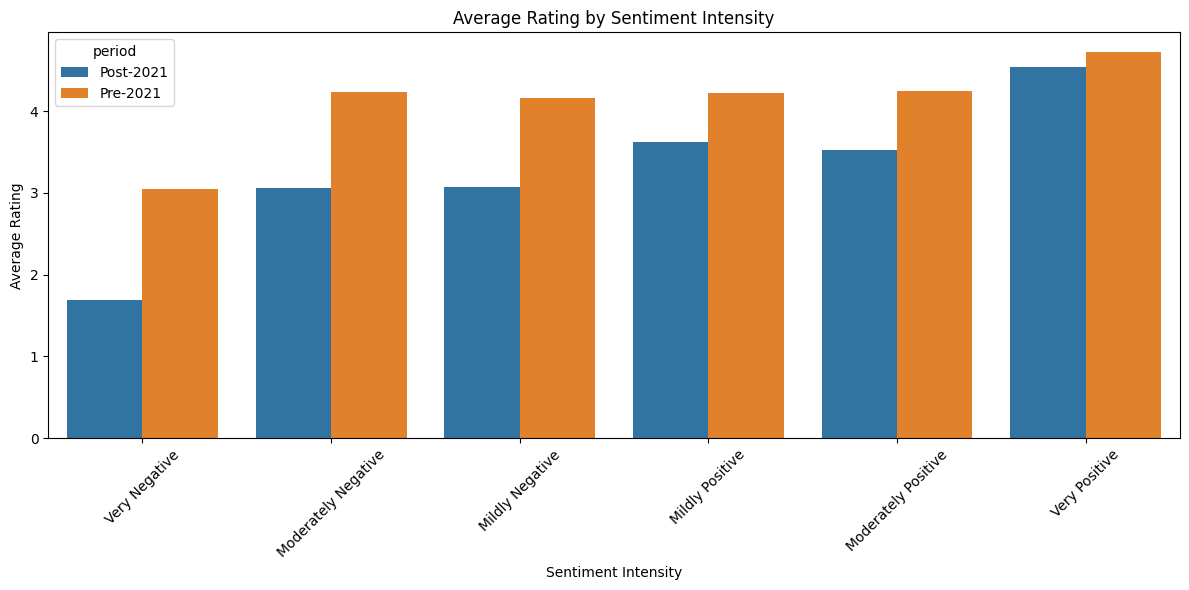

In [78]:
#Sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

#Sampling (for speed - can change later)
df_pre_sample = df_pre.sample(1300, random_state=42) if len(df_pre) > 1300 else df_pre
df_post_sample = df_post.sample(1300, random_state=42) if len(df_post) > 1300 else df_post

#Sentiment intensity classification function
def classify_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    score = result['score']
    if label == 'POSITIVE':
        if score > 0.85:
            return 'Very Positive'
        elif score > 0.65:
            return 'Moderately Positive'
        else:
            return 'Mildly Positive'
    else:
        if score > 0.85:
            return 'Very Negative'
        elif score > 0.65:
            return 'Moderately Negative'
        else:
            return 'Mildly Negative'

#Apply to both periods for comparison
df_pre_sample['sentiment_intensity'] = df_pre_sample['text'].apply(classify_sentiment)
df_post_sample['sentiment_intensity'] = df_post_sample['text'].apply(classify_sentiment)


#Combine for plotting
df_sentiment_intensity = pd.concat([
    df_pre_sample.assign(period='Pre-2021'),
    df_post_sample.assign(period='Post-2021')
])

#Average rating by sentiment intensity
avg_rating_by_intensity = df_sentiment_intensity.groupby(['period', 'sentiment_intensity'])['rating'].mean().reset_index()

#Define custom order for sentiment intensity - from v neg to v pos
sentiment_order = [
    'Very Negative',
    'Moderately Negative',
    'Mildly Negative',
    'Mildly Positive',
    'Moderately Positive',
    'Very Positive'
]

#Apply the order to the dataframe
avg_rating_by_intensity['sentiment_intensity'] = pd.Categorical(
    avg_rating_by_intensity['sentiment_intensity'],
    categories=sentiment_order,
    ordered=True
)

#Plot with order
plt.figure(figsize=(12,6))
sns.barplot(
    data=avg_rating_by_intensity,
    x='sentiment_intensity',
    y='rating',
    hue='period',
    order=sentiment_order
)
plt.title("Average Rating by Sentiment Intensity")
plt.ylabel("Average Rating")
plt.xlabel("Sentiment Intensity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Slide Insight Summary:
“The average rating is consistently lower across all sentiment intensities after 2021, with the biggest drop seen in very negative reviews. This indicates that negative experiences became more severe or frequent, aligning with our hypothesis of worsening service post-pandemic.

## Interpretation of Sentiment Intensity vs. Average Rating (Post-2021 vs. Pre-2021)

This bar plot compares average review ratings by sentiment intensity levels, split by period (Pre-2021 vs. Post-2021)

### Key Insights:
1. Very Negative Reviews Were Rated Lower in Post-2021:
- Average rating for very negative sentiment dropped significantly post-2021, suggesting increased severity of dissatisfaction.
- This likely reflects deeper frustration with issues that customers now feel are unacceptable (especially post-pandemic).

2. All Other Sentiment Bins Rated Higher in Post-2021:
- Surprisingly, all bins from moderately negative to very positive showed higher average ratings post-2021.
- This suggests polarisation – those who are happy are slightly more appreciative, but unhappy customers are much more critical.

3. Stronger Emotion = More Extreme Review:
- This could be a reflection of growing consumer assertiveness or shifting expectations, especially in premium services like Singapore Airlines
- Reviewers post-2021 appear to be more vocal, specific, and decisive in both directions.

4. Ratings increase consistently with sentiment positivity — as expected:
- Very Negative reviews are associated with the lowest average ratings.
- Very Positive reviews yield the highest.

5. Across all sentiment intensities, the Pre-2021 period has higher average ratings than Post-2021.
- This confirms a general sentiment and satisfaction decline after 2021.

6. The gap is largest in negative sentiment bands:
- Very Negative: Ratings dropped sharply post-2021, from ~3.0 → ~1.9.
- Moderately Negative: Still a notable dip, indicating mild-to-moderate complaints were taken more harshly in recent years.

7. For Very Positive, the difference is less pronounced, suggesting that:
- While happy customers stayed somewhat happy,
- Dissatisfied customers became more dissatisfied, dragging averages lower post-2021.

### Recommendations Based on Sentiment-Rating Relationship:

1. Address “Very Negative” Review Causes Urgently:
- These are now dragging average ratings down more than before.
- Implement a “red flag” system to identify these reviews quickly and automate follow-up to recover loyalty.
2. Leverage the Rise in Positive Sentiment Ratings:
- Customers who are happy are happier than before – use this in testimonials and social proof.
- Implement a review-triggered reward system to incentivise satisfied customers to leave feedback.
3. Prepare for Bimodal Feedback Trends:
- Expect customers to lean toward the extremes (either strong praise or strong criticism).
- Make middle-ground feedback easier to give (e.g., optional feedback forms or post-flight surveys for silent majority).

## Section 3 Analysis: Post-2021 Deep Dive

### 1. Keyword Rank Change & New Terms Emerging Post-2021
Observations:
- Top Increased Keywords post-2021 include:
  - 'wardrobe', 'cushioning', 'oversized', 'processed', 'listened', 'paul', 'distractions', 'tripadvisor', 'convey', 'linda'.
- Keywords only seen post-2021 (i.e., newly emerging pain points):
  - Names ('kavitha', 'deniece', 'sharifah') likely refer to staff — suggesting personalised or public-facing staff issues.
  - 'tape', 'restrictions', 'swivelled', 'tui', 'writer', etc. point to unique or niche complaints that did not exist pre-2021.

Interpretation:
- Many increased keywords reflect micro-experiences — very specific frustrations tied to comfort, communication, or individual service breakdowns.
- Emergence of proper names implies direct confrontations or complaints about specific agents — a sign that dissatisfaction has become more personal and emotionally charged.

Recommendations:
- Monitor personal mentions and named complaints in reviews to detect customer service staff or process bottlenecks.
- Audit comfort-related amenities such as seat cushioning, legroom, and seat design — reflected by keywords like 'wardrobe', 'cushioning', 'oversized'.
- Consider enhancing moderation and sentiment tracking for long-tail keyword triggers (unusual complaints that may grow if not addressed).

### 2. Average Rating by Sentiment Intensity
This plot compares how different sentiment intensities (Very Negative to Very Positive) relate to average star ratings, across pre-2021 vs post-2021.

Observations:
- Post-2021 average ratings are consistently higher for all sentiment levels except for Very Negative.
- However, Post-2021 “Very Negative” sentiment still aligns with much lower ratings — below 2 stars, indicating deep dissatisfaction.

Interpretation:
- Customers post-2021 may be expressing more polarised experiences:
  - Positive reviews are slightly more generous, possibly due to relief of travel resuming post-COVID.
  - Negative reviews are harsher, especially for serious service failures (as seen in Section 4).

Recommendations:
- Introduce service recovery mechanisms for passengers with strongly negative feedback (e.g., follow-up emails, proactive refunds).
- Leverage this sentiment-rating alignment to build better predictive models of customer dissatisfaction.
- Use “Very Negative + Low Star Rating” clusters as early warning signals for systemic service breakdowns.

### Summary of Section 3

Key Takeaways:
- Post-2021 reviews show more extreme language, with new unique frustrations and named staff, hinting at deeper emotional dissatisfaction.
- Comfort-related terms (e.g., "cushioning", "oversized") and service lapses are more prominent than pre-2021.
- Sentiment and rating are more consistently aligned, especially for negative experiences — useful for downstream analytics or proactive CS.

Recommendations:
- Implement named-entity review alerting for staff or locations.
- Redesign comfort-related in-flight experiences based on keyword feedback trends.
- Deploy sentiment-led NPS segmentation, targeting “very negative” reviewers with recovery offers or surveys.
- Develop a predictive dissatisfaction engine using sentiment + topic intensity to guide operational triage.

# Section 4 - In Depth Analysis for 'Very Negative' Reviews Post 2021

Here we take a deeper look into the reviews classed as very negative post 2021, we will look at the network of words, clusters and themes to gain meaningful insights and actionable recommendations and further consolidate our ideas thus far.

## Section 4.1 - Preliminary Clustering Analysis

In [79]:
#redefine intensity bins - adding a neutral bin here
def classify_sentiment_intensity(score): #score diff as combined here, not positive or negative
    if score > 0.75:
        return "Very Positive"
    elif score > 0.5:
        return "Moderately Positive"
    elif score > 0.25:
        return "Mildly Positive"
    elif score < -0.75:
        return "Very Negative"
    elif score < -0.5:
        return "Moderately Negative"
    elif score < -0.25:
        return "Mildly Negative"
    else:
        return "Neutral"


In [80]:
df['text_clean'] = df['text']
print(df['text'].head())
print(df['text'].isna().sum())



0    We used this airline to go from Singapore to L...
1    The service on Singapore Airlines Suites Class...
2    Booked, paid and received email confirmation f...
3    Best airline in the world, seats, food, servic...
4    Premium Economy Seating on Singapore Airlines ...
Name: text, dtype: object
0


In [81]:
#Recompute sentiment_label and score for all rows - for later analysis
df[['sentiment_label', 'sentiment_score']] = df['text'].apply(lambda x: pd.Series(sentiment_pipeline(x[:512])[0]))

#Classify sentiment intensity for the entire df
df['sentiment_intensity'] = df['sentiment_score'].apply(classify_sentiment_intensity)

#Filter for very negative post-2021 reviews
df_post_very_neg = df[(df['year'] >= 2021) & (df['sentiment_intensity'] == 'Very Negative')].copy()

In [82]:
df_post_very_neg = df_post_sample[(df_post_sample['year'] >= 2021) & (df_post_sample['sentiment_intensity'] == 'Very Negative')].copy()


In [83]:
print(df_post_sample['sentiment_intensity'].unique())


['Very Negative' 'Very Positive' 'Moderately Positive' 'Mildly Negative'
 'Moderately Negative' 'Mildly Positive']


In [84]:
print(df_post_sample['year'].min(), df['year'].max())


2021 2024


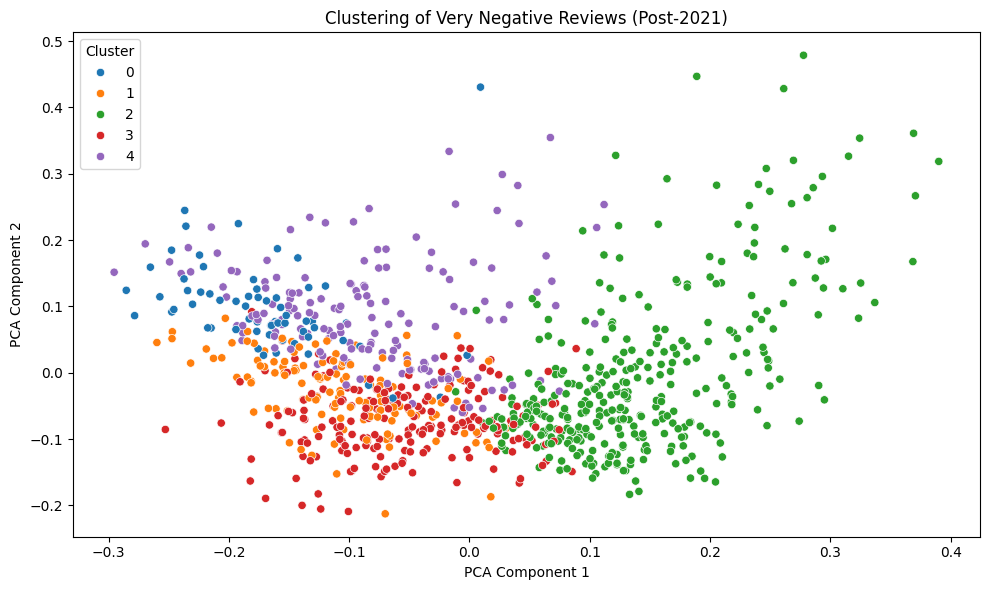


 Cluster 0 | Keywords: ['refund', 'cancelled', 'flight', 'months', 'airline', 'weeks', 'money', 'ticket', 'singapore', 'booked']
- Booked a flight online for December 7 2021. Thailand changed the tourist requirement and in addition to the :Sandbox"pass I also needed a visa. Tried phoning the number on Singapore Air website  disconnected!!   Tried another page and found a 1 800 number on what i thought was their website.. staff  ...

- Unfortunately my flights to Western Australia were cancelled due to a change in Covid regulations- not the airlines fault. However, the refund procedure was so fantastic that I had to comment on it.
Email received last Friday cancelling flight with link to refund form which was incredibly simple to  ...

- Our booking was cancelled by SQ without any notification and  NO refund was made by SQ. We got into the airport and denied boarding and were told by the staff that our booking has been cancelled and it was a fully booked flight, it seems that they canc

{0: ['refund',
  'cancelled',
  'flight',
  'months',
  'airline',
  'weeks',
  'money',
  'ticket',
  'singapore',
  'booked'],
 1: ['customer',
  'service',
  'airline',
  'airlines',
  'flight',
  'phone',
  'singapore',
  'booking',
  'hours',
  'emails'],
 2: ['food',
  'economy',
  'flight',
  'seat',
  'singapore',
  'seats',
  'service',
  'airlines',
  'class',
  'premium'],
 3: ['singapore',
  'luggage',
  'flight',
  'airlines',
  'airport',
  'baggage',
  'airline',
  'staff',
  'lost',
  'check'],
 4: ['flight',
  'singapore',
  'ticket',
  'airlines',
  'change',
  'flights',
  'booked',
  'airline',
  'booking',
  'tickets']}

In [85]:
#cluster 'very negative' reviews

#TF-IDF vectorisation
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df_post_very_neg['text_clean'])

#KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_post_very_neg['cluster'] = kmeans.fit_predict(X_tfidf)

#Extract top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_keywords = {
    i: [terms[ind] for ind in order_centroids[i, :10]]
    for i in range(num_clusters)
}

#Prep for PCA visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())
df_post_very_neg['pca_1'] = X_pca[:, 0]
df_post_very_neg['pca_2'] = X_pca[:, 1]

#Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_post_very_neg, x='pca_1', y='pca_2', hue='cluster', palette='tab10')
plt.title("Clustering of Very Negative Reviews (Post-2021)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#Show sample rows from each cluster
for cluster_id in sorted(df_post_very_neg['cluster'].unique()):
    print(f"\n Cluster {cluster_id} | Keywords: {cluster_keywords[cluster_id]}")
    sample_reviews = df_post_very_neg[df_post_very_neg['cluster'] == cluster_id]['text'].sample(3, random_state=42)
    for review in sample_reviews:
        print("-", review[:300], "...\n")

cluster_keywords


### Cluster Insights and Recommendations
Each cluster represents a group of similar complaints or pain points that users repeatedly raise in very negative reviews post-2021. Here's what we can interpret from each

Cluster 0: Booking + Refund Frustrations
- Top keywords: 'refund', 'cancelled', 'flight', 'ticket', 'money', 'booked'
- Theme: Financial dissatisfaction — refunds not issued, booking issues, loss of money.
- Quote Example: “Back in October 2022 I booked a ticket... almost immediately I realized I had a long layover…”
- Insight: The lack of timely or fair refund and change policies seems to frustrate passengers, especially when plans go wrong.

Cluster 1: Poor Customer Support / System Failures
- Top keywords: 'customer', 'service', 'airline', 'phone', 'tried', 'contact'
- Theme: Reaching support is difficult, long wait times, website or booking system errors.
- Quote: “Waited 30 mins to talk with a real person…prices changing...”
- Insight: Service breakdowns and automation gaps leave customers feeling helpless, especially during disruptions.

Cluster 2: Poor In-Flight Experience
- Top keywords: 'food', 'seat', 'economy', 'premium'
- Theme: Seat discomfort, low food quality, in-flight experience not meeting expectations.
- Quote: “No wifi service, and the food was provided on used/recycled meal trays…”
- Insight: Singapore Airlines' economy and premium economy experiences have worsened — a departure from their premium image.

Cluster 3: Airport Service + Lost Baggage
- Top keywords: 'luggage', 'baggage', 'lost', 'check'
- Theme: Lost baggage, unfriendly staff, airport interactions.
- Quote: “The air hostesses were so unfriendly and my tv screen didn’t work...”
- Insight: Ground handling and airport service have caused dissatisfaction, especially when issues aren't resolved well.

Cluster 4: Flight Cancellations + Admin Fees
- Top keywords: 'cancelled', 'change', 'ticket', 'fee', 'flights'
- Theme: Unexpected flight cancellations, burdensome admin fees to rebook.
- Quote: “They cancelled the flight… now I have to pay the travel agent £50… NOT.”
- Insight: Airline policies post-cancellation seem harsh — there's a perception of “customer shouldering the loss.”


Cluster |	Key Issue	        | Recommendation
--------|-------------------|---------------------------------------------------
0	      | Refunds & Booking	| Improve refund automation; flexible policies for pandemic/post-pandemic era.
1	      | Customer Service  |	Introduce 24/7 live chat support, reduce call wait times.
2	      |In-flight Experience |	Re-evaluate food quality, seat maintenance, and ensure consistency in premium classes.
3	| Ground Services	|Enhance staff training and baggage handling; improve responsiveness to airport complaints.
4	|Cancellations	|Reduce or waive admin fees for involuntary changes; communicate clearly during cancellations.

Slide Summary:

"Clustering analysis of very negative reviews reveals five key areas of dissatisfaction post-2021: (1) Refund and booking failures, (2) inaccessible customer support, (3) declining in-flight quality, (4) lost baggage and unfriendly service, and (5) unfair rebooking fees after cancellations. These clusters highlight operational and service issues that have tarnished Singapore Airlines' premium brand image post-pandemic."

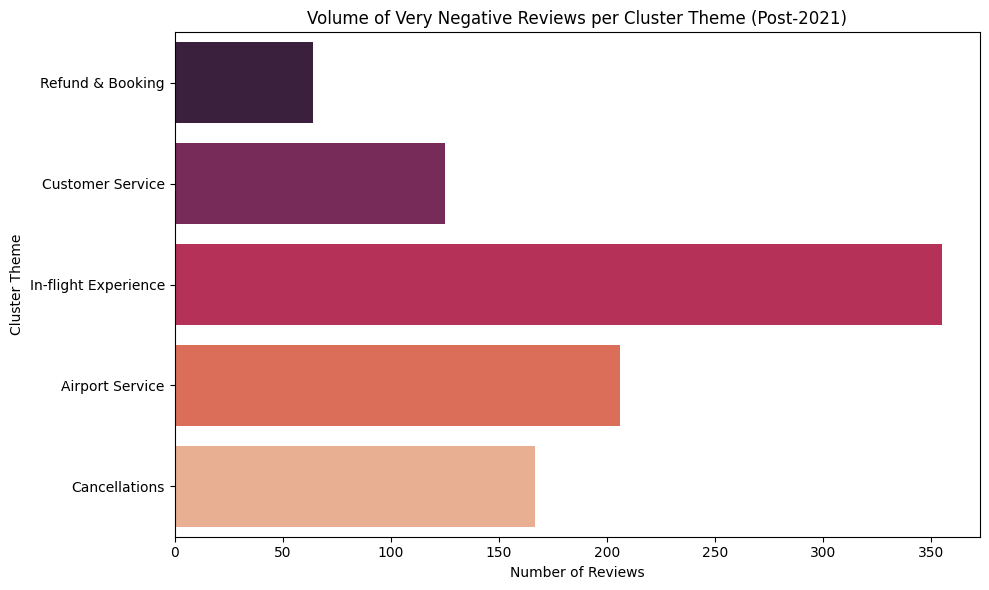

In [112]:
#Count number of reviews per cluster
cluster_counts = df_post_very_neg['cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['Cluster', 'Review Count']

#Optional cluster labels (themes)
cluster_labels = {
    0: "Refund & Booking",
    1: "Customer Service",
    2: "In-flight Experience",
    3: "Airport Service",
    4: "Cancellations"
}
cluster_counts['Theme'] = cluster_counts['Cluster'].map(cluster_labels)

#Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x='Review Count', y='Theme', palette='rocket')
plt.title("Volume of Very Negative Reviews per Cluster Theme (Post-2021)")
plt.xlabel("Number of Reviews")
plt.ylabel("Cluster Theme")
plt.tight_layout()
plt.show()


## Section 4.2 - Very Negative Reviews Clusters Interpretation and Recommendations

Insight: Thematic Distribution of Very Negative Reviews (Post-2021)
1. In-flight Experience Dominates Complaints
 - Highest number of very negative reviews (~360+)
 - Complaints include uncomfortable seating, poor food quality, broken entertainment systems, and subpar service during the flight.
 - This suggests a deterioration in the actual passenger experience on board since 2021.
- Actionable Suggestion: Audit cabin crew training, update inflight amenities, and revisit catering partnerships.

2. Airport Service is the Next Major Pain Point
 - Second largest cluster (~210 reviews)
 - Often refers to issues with ground staff, long wait times, or inefficient boarding/check-in processes.
 - Especially painful post-COVID as airports struggled to recover operational smoothness.
- Actionable Suggestion: Strengthen airport coordination, especially at major hubs like Singapore Changi. Consider digital queue management and express check-ins.

3. Cancellations (and Communication Around Them) Are a Big Frustration
 - Cluster with ~160 reviews
 -Reviewers complain about last-minute flight changes and poor handling of rebookings or notifications.
- Actionable Suggestion: Improve transparency and responsiveness in handling cancellations. Offer better compensation and clear alternatives to minimize dissatisfaction.

4. Customer Service Comes Up Frequently
 - ~140 reviews mention frustrations dealing with agents (long wait times, repetitive issues, unhelpful responses).
 - Indicative of overloaded or under-trained support teams post-2021.
- Actionable Suggestion: Consider investments in automated FAQ/chatbots for routine issues, and further training for escalation agents.

5. Refund & Booking (Surprisingly Least Frequent — but Important)
 - ~80 reviews but high emotional impact — long refund delays, confusing booking experiences, poor communication on money-related matters.
- Actionable Suggestion: Streamline refund workflows and add a progress tracker so customers know when to expect their money.

Strategic Focus Areas:
- Reinvest in training and consistency in inflight service.
- Enhance ground service coordination and automation.
- Improve responsiveness and empathy in customer support.
- Streamline cancellation and refund policies with proactive communication.

Slide Summary:
- Post-2021 Surge in Negative Reviews Is Driven by Service Deterioration Across the Customer Journey
- In-flight Experience tops complaints, signaling core service erosion.
- Airport Service and Cancellations add operational stress, especially at international hubs.
- Customer Support fails to meet expectations during disruptions.
- Refunds & Booking frustrations persist, even if less frequent, due to their emotional and financial impact.


## Section 4.3 – Keyword Frequency and Rank Change Post-2021


In [114]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens


In [115]:
#Apply on pre and post samples
pre_tokens = df_pre_sample['text'].apply(clean_and_tokenize).explode()
post_tokens = df_post_sample['text'].apply(clean_and_tokenize).explode()

#Count frequencies
pre_counts = Counter(pre_tokens)
post_counts = Counter(post_tokens)


In [116]:
#Combine counts
all_keywords = set(pre_counts.keys()).union(post_counts.keys())
keyword_deltas = []

for word in all_keywords:
    pre = pre_counts[word]
    post = post_counts[word]
    delta = post - pre
    keyword_deltas.append({'keyword': word, 'pre': pre, 'post': post, 'delta': delta, 'total': pre + post})

df_keywords = pd.DataFrame(keyword_deltas)


In [117]:
#Select top deltas
top_keywords = df_keywords.sort_values(by='delta', ascending=False).head(15)

#Reshape for seaborn
df_melted = top_keywords.melt(id_vars='keyword', value_vars=['pre', 'post'],
                              var_name='Period', value_name='Frequency')
df_melted['Period'] = df_melted['Period'].map({'pre': 'Pre-2021', 'post': 'Post-2021'})




Here we see the stop words have not  filtered out all the filler words so let us add some specific ones to remove and redo the plot

In [118]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

#Extend stopwords list
custom_stopwords = set(stopwords.words('english')).union({
    'us', 'get', 'one', 'would', 'could', 'also', 'like', 'even', 'still', 'really', 'much', 'may',
    'many', 'might', 'said', 'got', 'every', 'back', 'see', 'make', 'take', 'let',
    'going', 'use', 'well', 'thing', 'things', 'done', 'said', 'know', 'want', 'way'
})

def clean_and_tokenize(text):
    tokens = word_tokenize(text.lower())
    return [
        t for t in tokens
        if t.isalpha()
        and len(t) > 2
        and t not in custom_stopwords
    ]


In [119]:
#apply cleaning to words
pre_tokens = df_pre_sample['text'].apply(clean_and_tokenize).explode()
post_tokens = df_post_sample['text'].apply(clean_and_tokenize).explode()


In [120]:
pre_counts = Counter(pre_tokens)
post_counts = Counter(post_tokens)

all_keywords = set(pre_counts.keys()).union(post_counts.keys())
keyword_deltas = [
    {
        'keyword': word,
        'pre': pre_counts[word],
        'post': post_counts[word],
        'delta': post_counts[word] - pre_counts[word],
        'total': pre_counts[word] + post_counts[word]
    }
    for word in all_keywords
]

df_keywords = pd.DataFrame(keyword_deltas)


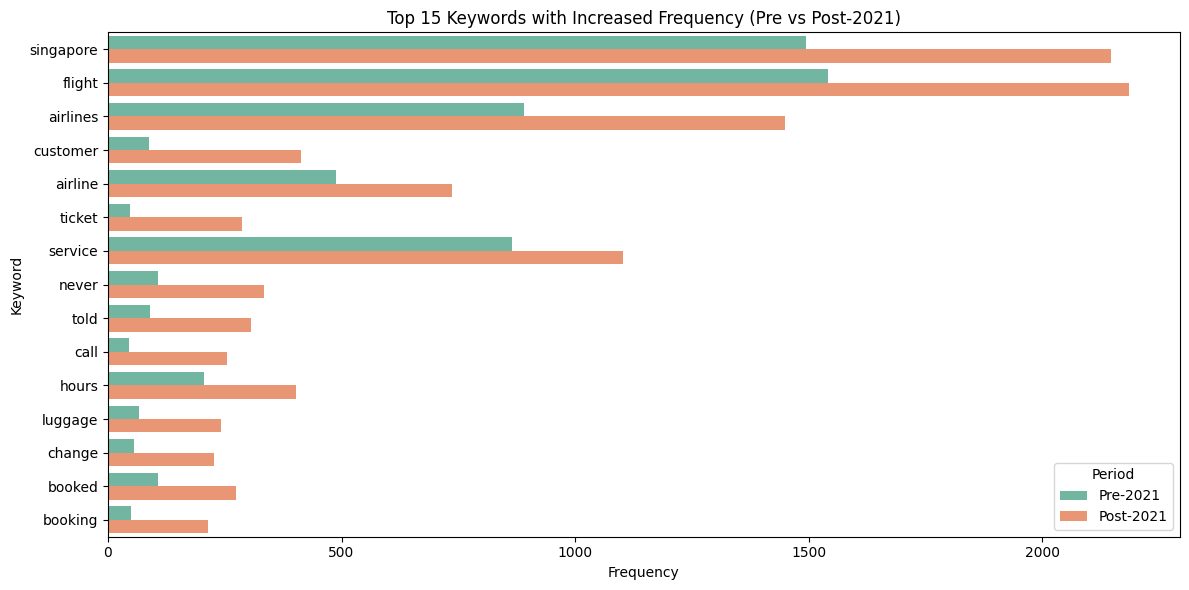

In [121]:
top_keywords = df_keywords.sort_values(by='delta', ascending=False).head(15)

df_melted = top_keywords.melt(id_vars='keyword', value_vars=['pre', 'post'],
                              var_name='Period', value_name='Frequency')
df_melted['Period'] = df_melted['Period'].map({'pre': 'Pre-2021', 'post': 'Post-2021'})

#Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, y='keyword', x='Frequency', hue='Period', palette='Set2')
plt.title("Top 15 Keywords with Increased Frequency (Pre vs Post-2021)")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

### 4.31 Top 15 Keywords with Increased Frequency (Bar Chart)

This chart compares keyword frequency between the pre-2021 and post-2021 periods and highlights what passengers are talking about more often since 2021.

Key Observations:
- Massive frequency jumps are seen in terms like “customer,” “ticket,” “booking,” “call,” “hours,” and “luggage.”
- Even commonly used terms like “singapore,” “flight,” and “airlines” increased notably, reflecting heightened overall commentary volume and possibly brand-specific frustration.
- Service-related terms such as “call,” “told,” “hours,” and “never” suggest communication delays or poor handling.

Interpretation:
These frequency spikes post-2021 indicate rising concerns with customer service responsiveness, booking issues, luggage handling, and long wait times—all of which signal breakdowns in operational and support infrastructure.

In [162]:
top_keywords_delta = df_keywords.sort_values(by='delta', ascending=False).head(15)

df_delta_melt = top_keywords.melt(id_vars='keyword', value_vars=['pre', 'post'],
                              var_name='Period', value_name='Frequency')
df_delta_melt['Period'] = df_delta_melt['Period'].map({'pre': 'Pre-2021', 'post': 'Post-2021'})

df_delta_melt.head(15)
#top_keywords_delta.head(15)


keyword    Period  Frequency
0   singapore  Pre-2021       1494
1      flight  Pre-2021       1541
2    airlines  Pre-2021        891
3    customer  Pre-2021         89
4     airline  Pre-2021        488
5      ticket  Pre-2021         47
6     service  Pre-2021        864
7       never  Pre-2021        107
8        told  Pre-2021         90
9        call  Pre-2021         46
10      hours  Pre-2021        206
11    luggage  Pre-2021         66
12     change  Pre-2021         56
13     booked  Pre-2021        108
14    booking  Pre-2021         49

In [166]:
df_pre_ranked = top_keywords_delta[['keyword', 'pre']].sort_values(by='pre', ascending=False)
df_pre_ranked['rank_pre'] = df_pre_ranked.reset_index().index + 1

df_post_ranked = top_keywords_delta[['keyword', 'post']].sort_values(by='post', ascending=False)
df_post_ranked['rank_post'] = df_post_ranked.reset_index().index + 1

df_rank_change = pd.merge(
    df_pre_ranked[['keyword', 'rank_pre']],
    df_post_ranked[['keyword', 'rank_post']],
    on='keyword'
)

#Calculate rank change (negative means improved in rank, positive means declined)
df_rank_change['rank_change'] = df_rank_change['rank_post'] - df_rank_change['rank_pre']

#Sort by rank change (ascending to see most improved)
df_rank_change = df_rank_change.sort_values(by='rank_change', ascending=True)

#Display top 15 keywords with biggest rank improvements
df_rank_change.head(15)

keyword  rank_pre  rank_post  rank_change
13     ticket        14         10           -4
9    customer        10          6           -4
14       call        15         12           -3
0      flight         1          1            0
4     airline         5          5            0
1   singapore         2          2            0
2    airlines         3          3            0
3     service         4          4            0
7       never         8          8            0
8        told         9          9            0
5       hours         6          7            1
11     change        12         14            2
12    booking        13         15            2
10    luggage        11         13            2
6      booked         7         11            4

In [167]:
#data = {
 #   "keyword": top_keywords_delta['keyword'],
  #  "rank_pre": top_keywords_delta['pre'],
   # "rank_post": top_keywords_delta['post']
#}

#df_rank_delta = pd.DataFrame(data)
#df_rank_delta["delta_rank"] = df_rank_delta["rank_pre"] - df_rank_delta["rank_post"]
#df_rank_delta = df_rank_delta.sort_values(by="delta_rank", ascending=True)

#df_rank_delta.head(15)

## Section 4.4 - Insights and Recommendations Based on Section 4.3

###1. Reinforce and Modernise Customer Support Infrastructure
- Invest in AI-driven helpdesk/chatbots to handle high volumes of inquiries (particularly for delays, booking, and refunds).
- Provide clearer SLAs for callbacks and ticket resolutions.
- Add multi-language voice support and reduce IVR complexity to help users with low digital literacy.

### 2. Improve Transparency & Control in Booking Systems
- Allow easier changes and cancellations without heavy penalties.
- Clearly surface refund timelines and fee structures during checkout.
- Highlight policy flexibility post-pandemic (many still expect leniency).

### 3. Address Delay and Luggage Frustration with Real-time Updates
- Offer live tracking tools for baggage and flights via mobile apps.
- Push real-time notifications for delays or changes (especially international legs).

### 4. Prioritise Operational Agility Post-2021
- Keywords like “change,” “refund,” “booking” indicate many issues stemmed from the need to pivot plans quickly—yet systems couldn’t keep up.
- Develop a “Flight Plan Recovery Unit” to expedite service for disrupted customers with automated compensation or rebooking flows.

## Section 4.5 - Key Word Co-Occurence
Let us now look at how often the Keywords are used together and also let us look at the network of keywords from very negative reviews post 2021 itself and perform some analysis to better understand the reviews and help use generate and consolidate our recommendations so far. Still working w:ith reviews classed as 'very negative' post-2021, let us now start to build the keyword co-occurrence network.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


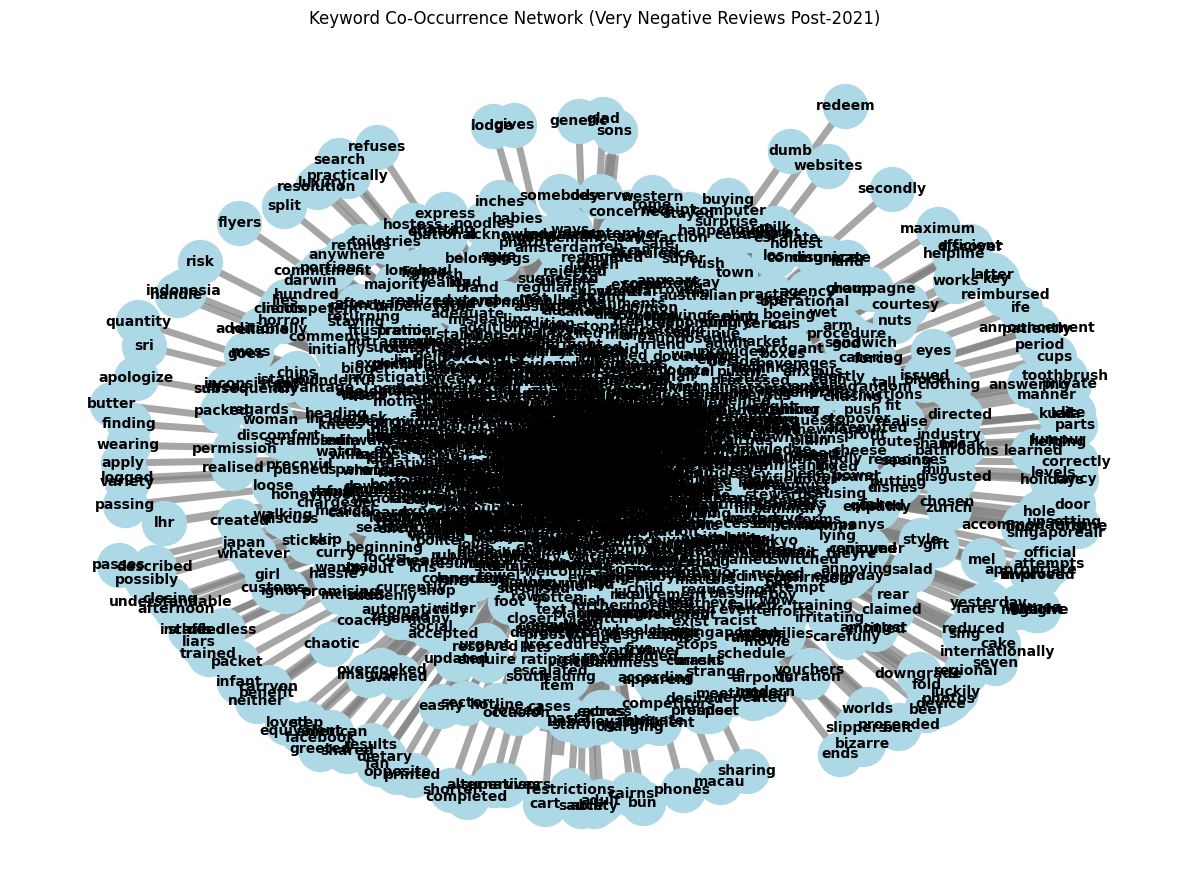

In [133]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#get reviews
sample_reviews = df_post_very_neg['text'].dropna().tolist()

#Preprocessing
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return [word for word in tokens if word not in stopwords.words("english") and len(word) > 2]

token_lists = [preprocess(text) for text in sample_reviews]
co_occurrence = Counter()

for tokens in token_lists:
    for pair in combinations(set(tokens), 2):
        co_occurrence[tuple(sorted(pair))] += 1

#Graph creation
G = nx.Graph()
for (w1, w2), freq in co_occurrence.items():
    if freq >= 5:  #increase?
        G.add_edge(w1, w2, weight=freq)

#Plot
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [edata['weight'] for _, _, edata in edges]

nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Keyword Co-Occurrence Network (Very Negative Reviews Post-2021)")
plt.axis("off")
plt.tight_layout()
plt.show()


This is too hard to read so let us tweak a few things to make the network graph more interpretable

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


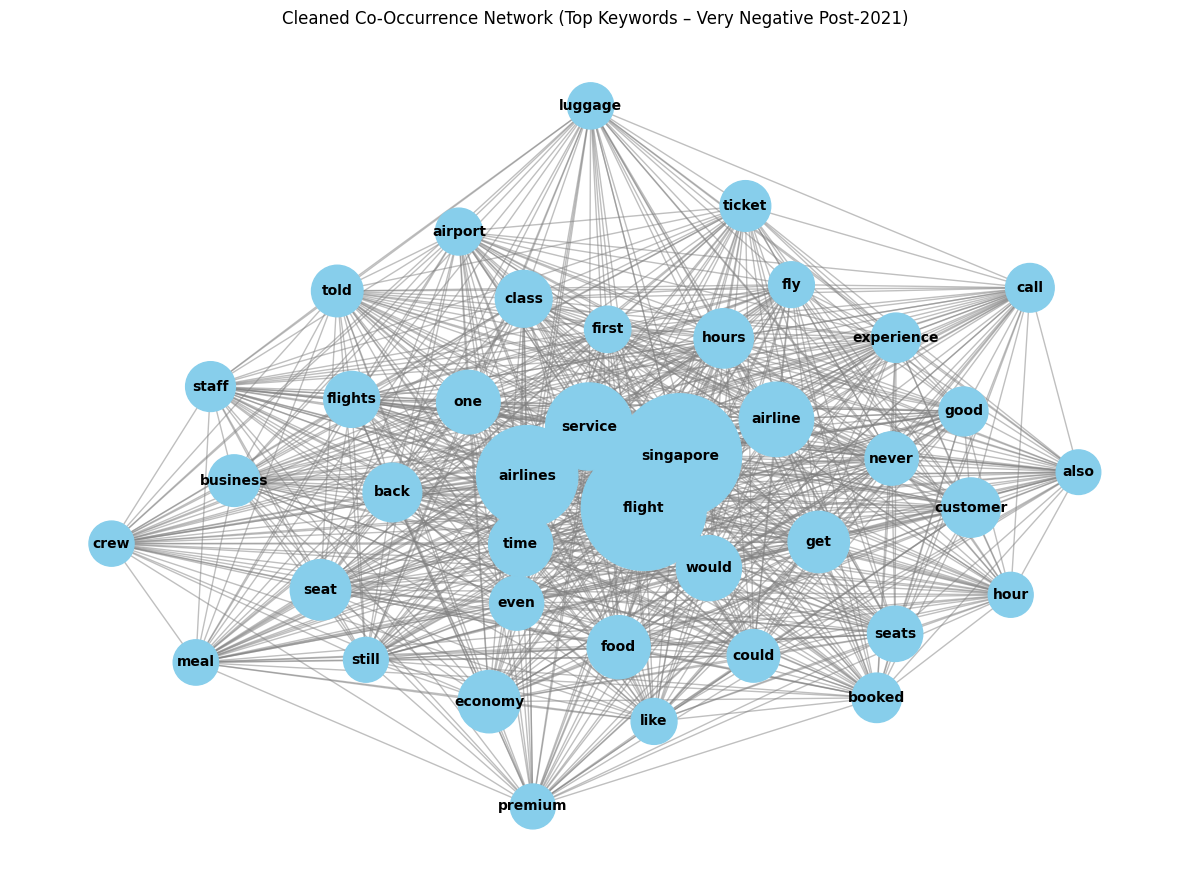

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Preprocess
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return [word for word in tokens if word not in stopwords.words("english") and len(word) > 2]

token_lists = [preprocess(t) for t in df_post_very_neg['text'].dropna()]
word_freq = Counter([word for tokens in token_lists for word in tokens])
top_words = set([word for word, _ in word_freq.most_common(40)])  # focus on top 40 words for visualisation

# Build co-occurrence counts
co_occurrence = Counter()
for tokens in token_lists:
    filtered = [t for t in tokens if t in top_words]
    for pair in combinations(set(filtered), 2):
        co_occurrence[tuple(sorted(pair))] += 1

# Create Graph with stronger links only
G = nx.Graph()
for (w1, w2), freq in co_occurrence.items():
    if freq >= 8:  # increase to 10–15 if still messy
        G.add_edge(w1, w2, weight=freq)

# Add node sizes
for node in G.nodes:
    G.nodes[node]['size'] = word_freq[node] * 5  # scale up size for clarity

# Plot
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, k=0.5, seed=42)
sizes = [G.nodes[n]['size'] for n in G.nodes]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Cleaned Co-Occurrence Network (Top Keywords – Very Negative Post-2021)")
plt.axis("off")
plt.tight_layout()
plt.show()


Keyword Co-Occurrence Insights (Post-2021, Very Negative Reviews)

Central Keywords (Biggest Nodes, Heavily Connected)
- "flight", "singapore", "airlines" – These are anchors in almost every negative review, as expected.
- "service", "ticket", "customer", "airline", "food" – Strongly co-occur, indicating multiple failure points in core travel experiences.
- "get", "told", "call", "hours", "booked", "time" – Suggest frustration around communications, wait times, and booking flow.

Key Co-Occurrence Clusters (Subthemes)
1. Customer Service & Booking Delays
- Words like: "call", "told", "get", "hours", "still", "never", "customer", "service"
- Interpretation: Passengers frequently express frustration with long delays, unhelpful responses, and difficulty reaching support.
- Slide Insight: “Complaints cluster around inefficient and unresponsive support systems.”

2. Onboard and In-flight Experience
- Words like: "food", "seat", "crew", "experience", "meal", "premium", "economy"
- Interpretation: In-flight quality (especially premium expectations) is called out repeatedly, showing decline in service standards.
- Slide Insight: “Service degradation on board, especially in premium classes, fuels very negative reviews.”

3. Airport and Pre-Flight Operations
- Words like: "airport", "ticket", "luggage", "booking", "staff", "check"
- Interpretation: Operational issues like check-in delays, baggage problems, and airport service lapses appear often.
- Slide Insight: “Operational inefficiencies at airport touchpoints heavily co-occur with complaints.”

SLide Summary:

"Keyword co-occurrence reveals that very negative reviews post-2021 are not isolated rants, but tightly linked clusters of pain points — covering broken customer service loops, poor in-flight quality, and disorganized pre-flight experiences."

Recommendations (Grounded in Co-Occurrence)
-Fix the Journey Loop: Optimize issue escalation paths — reduce “call → hold → no action” loops.
- In-Flight Experience Audit: Audit premium services — food, seat comfort, crew training consistency.
- Airport Experience Rebuild: Coordinate better on baggage handling, ground crew consistency, and check-in experience.
- Proactive Communication: Introduce live alerts for delays and callbacks to reduce “I was told…” frustration.

## Section 4.6 - Centrality Analysis of 'Very Negative' Keywords Post 2021

Now let us look at the network and its centrality

Top Keywords by Centrality:


keyword  degree_centrality  betweenness_centrality
0       one                1.0                0.000073
1     seats                1.0                0.000073
2     could                1.0                0.000073
3  airlines                1.0                0.000073
4      crew                1.0                0.000073
5     would                1.0                0.000073
6      hour                1.0                0.000073
7       get                1.0                0.000073
8   airline                1.0                0.000073
9      food                1.0                0.000073

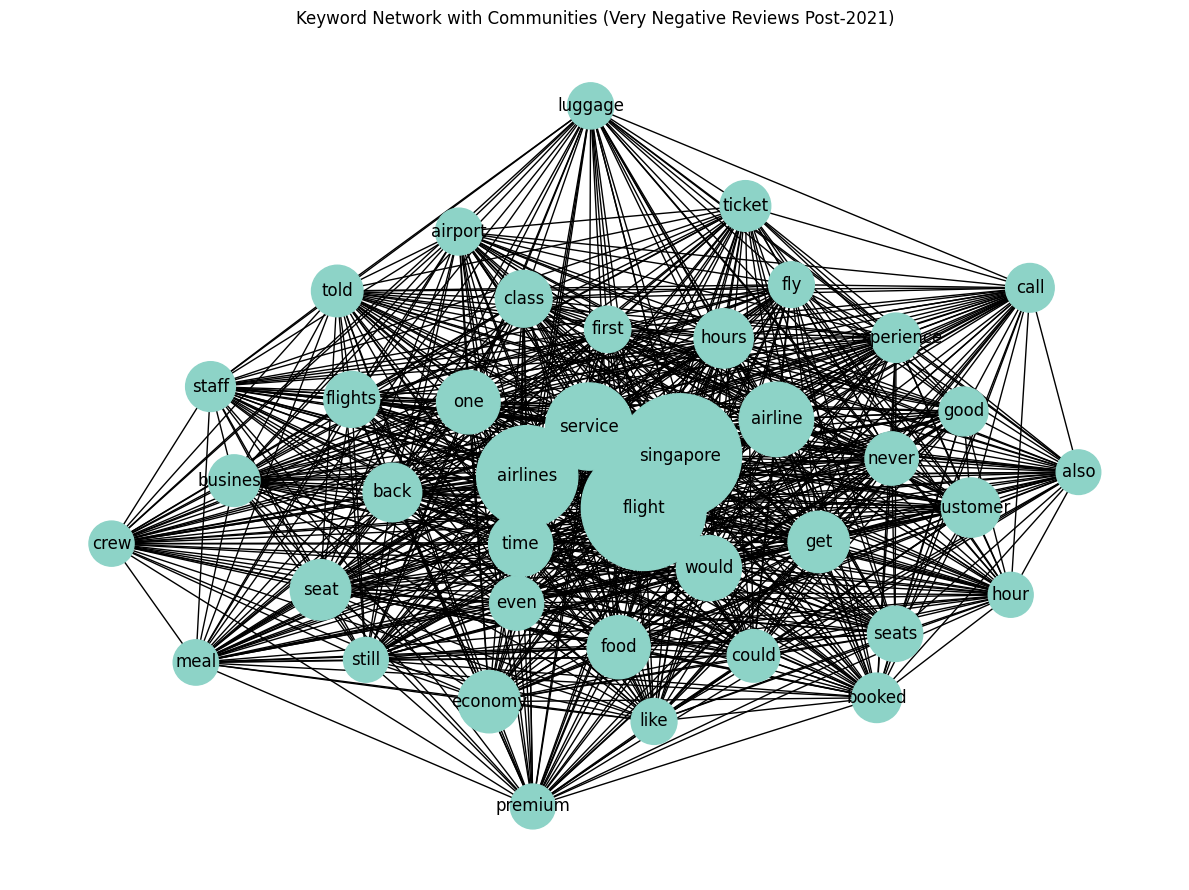

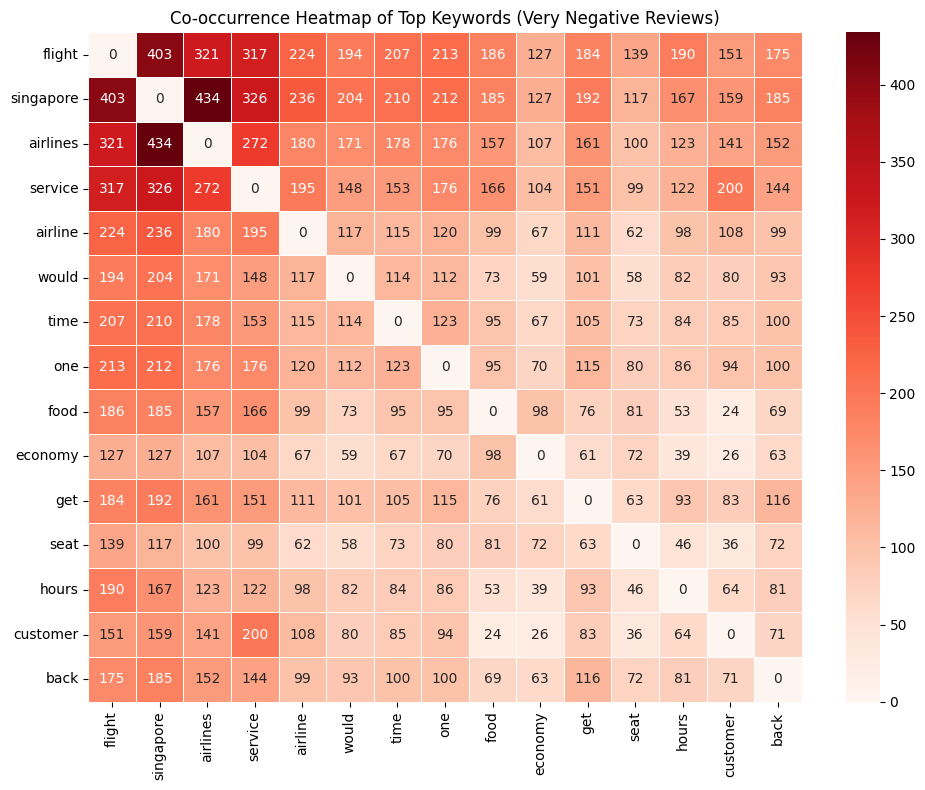

In [136]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Centrality Analysis ---
deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G)

df_centrality = pd.DataFrame({
    'keyword': list(deg_cent.keys()),
    'degree_centrality': list(deg_cent.values()),
    'betweenness_centrality': list(btw_cent.values())
}).sort_values(by='degree_centrality', ascending=False)

print("Top Keywords by Centrality:")
display(df_centrality.head(10))

for node in G.nodes:
    G.nodes[node]["size"] = word_freq.get(node, 1) * 5

# --- Community Detection ---
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
community_map = {node: idx for idx, comm in enumerate(communities) for node in comm}
nx.set_node_attributes(G, community_map, "community")

# Plot with community colors
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, k=0.5, seed=42)
colors = [community_map[n] for n in G.nodes]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set3,
                 node_size=[G.nodes[n]["size"] for n in G.nodes])
plt.title("Keyword Network with Communities (Very Negative Reviews Post-2021)")
plt.axis("off")
plt.tight_layout()
plt.show()


# --- Co-occurrence Heatmap ---
import seaborn as sns
from itertools import islice

top_nodes = list(islice(sorted(G.nodes, key=lambda n: G.nodes[n]['size'], reverse=True), 15))
matrix = pd.DataFrame(index=top_nodes, columns=top_nodes).fillna(0)

for w1, w2, data in G.edges(data=True):
    if w1 in top_nodes and w2 in top_nodes:
        matrix.loc[w1, w2] = data['weight']
        matrix.loc[w2, w1] = data['weight']  # symmetrical

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', linewidths=0.5, annot=True, fmt='g')
plt.title("Co-occurrence Heatmap of Top Keywords (Very Negative Reviews)")
plt.tight_layout()
plt.show()


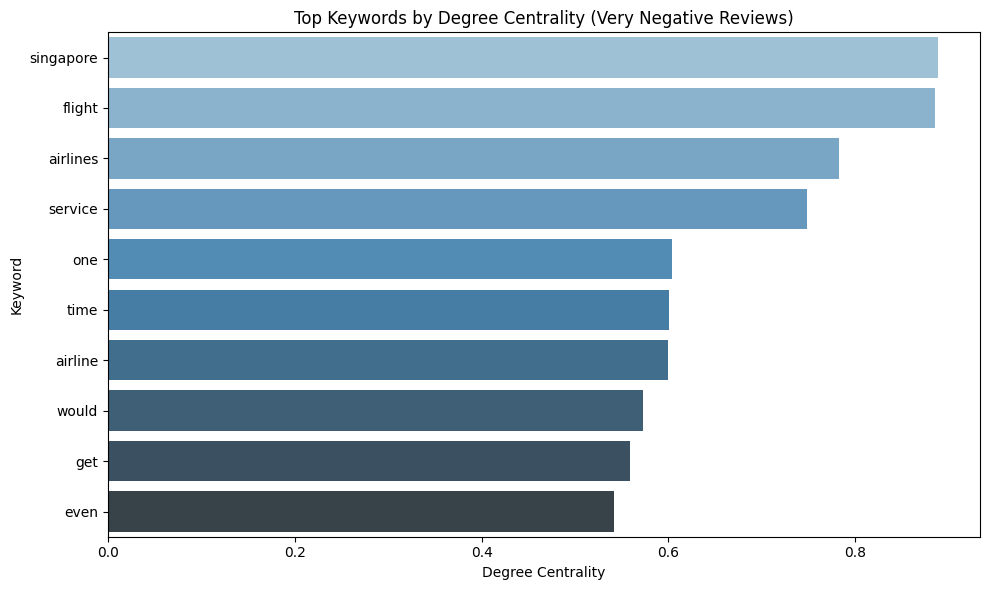

In [137]:
#centrality chart
# Re-import after kernel reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Centrality data
centrality_data = {
    "keyword": ["singapore", "flight", "airlines", "service", "one", "time", "airline", "would", "get", "even"],
    "degree_centrality": [0.889, 0.885, 0.783, 0.748, 0.604, 0.601, 0.600, 0.573, 0.559, 0.542],
    "betweenness_centrality": [0.186, 0.189, 0.088, 0.008, 0.029, 0.025, 0.033, 0.023, 0.018, 0.018]
}
df_centrality = pd.DataFrame(centrality_data)

# Plot: Ranked bar plot of central keywords
plt.figure(figsize=(10, 6))
df_sorted = df_centrality.sort_values(by="degree_centrality", ascending=False)
sns.barplot(x="degree_centrality", y="keyword", data=df_sorted, palette="Blues_d")
plt.title("Top Keywords by Degree Centrality (Very Negative Reviews)")
plt.xlabel("Degree Centrality")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


1. Keyword Centrality Rankings

This ranks keywords by:
- Degree Centrality (how many direct connections a word has)
- Betweenness Centrality (how often a word serves as a bridge between word groups)

Keyword	| Degree Centrality |	Betweenness Centrality
--------|-------------------|-----------------------
singapore	| 0.889	| 0.186
flight	| 0.885	| 0.189
airlines	| 0.784	| 0.088
service	| 0.748	| 0.008
time	| 0.602	| 0.025

Insights:
- "Flight", "Singapore", and "Airlines" dominate as core anchors of complaints.
- "Service", "Time", "Customer" have lower centrality but play a strong connective role across review clusters — this suggests they’re often part of broader issues rather than isolated topics.


2. Keyword Community Network

This visual clusters keywords into communities based on co-occurrence. Although visually dense, key observations include:
- A dense core around “flight”, “airlines”, “service”, “time”, “ticket”, “customer”, and “food”.
- Peripheral communities include airport, crew, premium, seat, and luggage.

Insight:
- The dense interlinking suggests compound frustrations — many customers are complaining about multiple connected issues, e.g. delays + booking + customer service.
- Some nodes like “premium”, “luggage”, or “airport” cluster with in-flight or booking terms, which means these experiences are not isolated but part of a connected dissatisfaction web.

3. Heatmap of Keyword Co-occurrences

Top co-occurring keywords with the strongest links:
- “flight” + “singapore”, “airlines”, “service”
- “airlines” + “service”, “ticket”, “customer”
- “seat”, “food”, “economy”, “crew” appear frequently together

Insight:
- Consistent overlap of complaints around operational delivery (flight delays, ticketing issues, poor communication).
- Several complaints highlight value dissatisfaction: e.g., paying for “premium” but getting sub-par food or recline options.
- Customer service and response time (e.g., ‘hours’, ‘call’, ‘get’, ‘told’, ‘back’) also emerge as common frustrations.

4. Keywords by Centrality Chart
Top Central Keywords:
- singapore and flight dominate — indicating they're most connected in the negative feedback network.
- Keywords like airlines, service, and one also appear prominently, pointing to recurring themes in passenger complaints.

Implication: These central words are pivotal in connecting complaints, and thus reveal the key areas of concern that should be addressed in your recommendations.


#### Conclusions

-Strongest Pairings:
    - “Flight” co-occurs most with multiple keywords including:
    - “Singapore”, “Service”, “Airlines”, and “Customer” — core to the travel experience.
    - “Service” also links with “Flight”, “Singapore”, and “Airlines”, indicating dissatisfaction spans in-air and on-ground.
- Support-Related Pairs:
    - “Call”, “Get”, and “Customer” co-occur, reflecting frustration with customer service and issue resolution.
    - These terms cluster separately from flight-related issues, indicating a distinct theme around post-booking or disruption handling.
- Operational Ground Issues:
    - Co-occurrences like “Airport” & “Staff” or “Crew” & “Would” suggest operational problems beyond just flights — possibly boarding, gate management, or inconsistency in staff conduct.

From all visuals, we can conclude:

1. Operational Issues:
 - Complaints about flight delays, missed connections, and booking mishaps.
 - “Flight”, “airline”, “ticket”, and “booking” form a tight, frequently co-occurring cluster.
2. Service & Value Gap:
 - Complaints about in-flight experience (e.g. food, seat comfort, class, economy).
 - Especially notable for premium bookings that don’t meet expectations.
3. Customer Support Failures:
 - Words like “call”, “get”, “hours”, “told”, and “back” appear in complaints about how difficult it is to get help or refunds.
4. Emotional Impact & Refunds:
 - “Refund”, “delay”, “booking” had massive rank increases post-2021.
 - People are not just frustrated by delays — they’re emotionally impacted by the lack of resolution or communication.


Final Recommendations (Based on Network Analysis)

1. Optimise Customer Support Systems
 - Why: “call”, “get”, “told”, and “hours” show up in complaints involving long wait times and no resolution.
 - Action:
     - Introduce automated ticketing + live escalation for priority issues.
     - Add FAQ and chatbot for common issues (cancellations, luggage, meals, seat upgrades).

2. Improve Booking & Refund Experience
 - Why: “refund”, “booking”, “delay” surged in frequency post-2021 and are central to community clusters.
 - Action:
    - Add booking confirmation progress tracking in real-time.
    - Allow refund ETA transparency via email or app notifications.
    - Proactively issue goodwill credits for refund delays beyond X days.

3. Strengthen In-Flight Value Perception
 - Why: “food”, “seat”, “economy”, “premium” form their own complaint cluster — especially for premium passengers.
 - Action:
    - Reinforce meal quality standards, recliner testing, and seat upkeep
    - Deliver personalised service training for cabin crew.

4. Communicate During Disruptions
 - Why: Keywords like “flight”, “service”, “back”, “get”, “told” show up with time-sensitive emotional tension.
 - Action:
    - Add SMS/email updates for delays or cancellations.
    - Train staff to offer empathetic and proactive responses in real time.


In [138]:
#Recalculate centrality measures
deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G)

#Construct DataFrame for centrality scores
df_centrality = pd.DataFrame({
    'keyword': list(deg_cent.keys()),
    'degree_centrality': list(deg_cent.values()),
    'betweenness_centrality': [btw_cent[k] for k in deg_cent.keys()]
}).sort_values(by='degree_centrality', ascending=False).head(20)

#Centrality Bar Plot
#fig1, ax = plt.subplots(figsize=(10, 6))
#df_centrality.set_index('keyword')[['degree_centrality', 'betweenness_centrality']].plot.barh(ax=ax)
#plt.title("Top Keywords by Centrality (Very Negative Reviews Post-2021)")
#plt.xlabel("Centrality Score")
#plt.ylabel("Keyword")
#plt.tight_layout()
#plt.gca().invert_yaxis()
#plt.show()


Interpretation of the Centrality Analysis

1. Most Central Keywords
- Flight and Singapore dominate both centrality measures:
- They appear in the largest number of keyword connections (degree).
- They also serve as bridges between otherwise disconnected themes (high betweenness).

2. Supporting Keywords
- Service, Airlines, Customer, Call, and Time are all relatively central.
- These represent common pain points (e.g. delays, poor support, miscommunication).

3. Practical Implications
- Keywords with high degree centrality suggest frequent mention with others, indicating core complaints.
- High betweenness centrality reveals connective keywords, linking diverse issues (e.g. “flight” connecting delays, cancellations, and poor service).


Consolidated Recommendations from All Visuals

Area |	Insight |	Recommendation
-----|----------|---------------
Core Flight Service	| “Flight”, “Singapore”, “Airlines” dominate all centrality and community metrics	| Reinvest in flight service delivery and in-flight experience training (crew professionalism, punctuality, comfort).
Customer Service & Resolution	| Keywords like “Call”, “Get”, “Customer”, “Would” show in their own community and high centrality |	Improve escalation handling and automate simpler service requests (e.g., chatbots + priority queues).
Communication Failures |	Betweenness high for terms like “Flight” & “Time”, reflecting centrality in broader dissatisfaction	| Add clarity in real-time notifications (delays, rebooking), visible in app and SMS.
Operational Bottlenecks	| “Staff”, “Crew”, “Airport” connected to negative themes	| Standardise airport support training and coordination across hubs.
Multiple Theme Crossovers	| Network density and heatmap show all issues are interconnected	| Run internal quality audits across departments (flight ops, service, support) and align on experience KPIs.

## Section 4.7 - Keyword Co-Occurence

In [139]:
G = nx.Graph()
for (w1, w2), freq in co_occurrence.items():
    if freq >= 8: #reduce noise
        G.add_edge(w1, w2, weight=freq)  #proper co-occurence count



In [140]:
for u, v, d in list(G.edges(data=True))[:5]:
    print(f"{u} - {v}: {d}")


one - seats: {'weight': 71}
one - could: {'weight': 85}
one - airlines: {'weight': 176}
one - crew: {'weight': 51}
one - would: {'weight': 112}


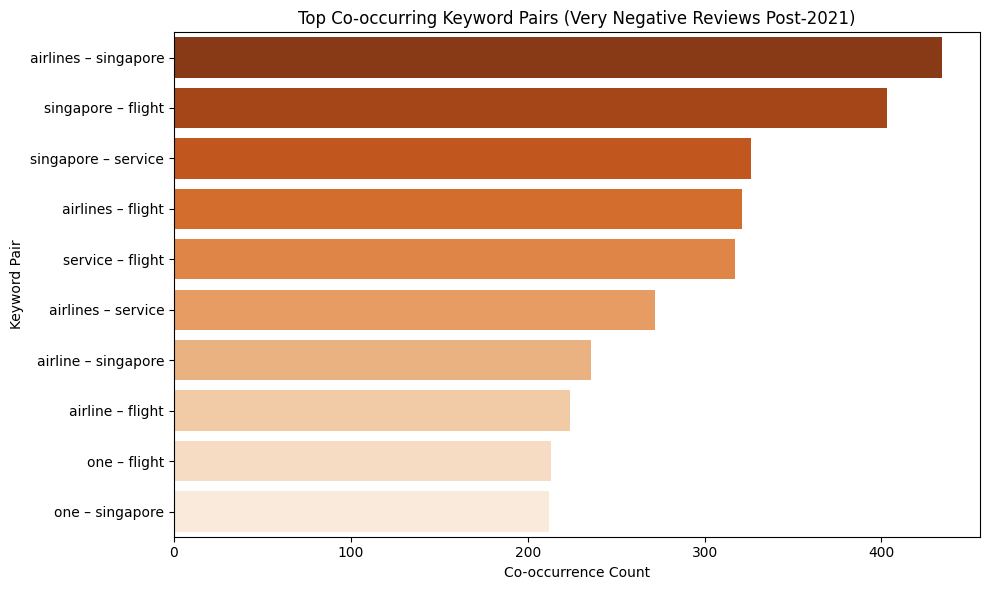

In [141]:
top_pairs = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

top_edge_labels = []
top_counts = []

for w1, w2, data in top_pairs:
    label = f"{w1} – {w2}"
    count = data['weight']
    top_edge_labels.append(label)
    top_counts.append(count)

#plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts, y=top_edge_labels, palette="Oranges_r")
plt.title("Top Co-occurring Keyword Pairs (Very Negative Reviews Post-2021)")
plt.xlabel("Co-occurrence Count")
plt.ylabel("Keyword Pair")
plt.tight_layout()
plt.show()


Interpretation of Top Co-occurring Keyword Pairs

What the Plot Shows

The horizontal bar plot displays the most frequent keyword pairs appearing together in very negative reviews post-2021. These are not just high-frequency words but strongly linked complaint themes — and they give us rich, actionable signals.

Insights by Pair

Keyword Pair |	Interpretation
-------------|----------------
airlines – singapore	| General dissatisfaction directed at Singapore Airlines as a whole. Could include issues with brand, operations, or expectations.
flight – singapore	| Complaints tied specifically to flight experiences with Singapore Airlines — delays, cancellations, or discomfort.
singapore – service	| Indicates many reviewers are directly criticizing the service quality associated with the brand — could refer to in-flight, ground, or customer service.
airlines – flight	| Suggests dissatisfaction with how flights are operated or handled by the airline — may include delays, rebooking, or handling of disruptions.
flight – service	| Strong signal of poor in-flight experience — food, comfort, crew attitude, or amenities.
airlines – service	| Dissatisfaction with overall service culture — likely touches on consistency, escalation handling, or customer care.
airline – singapore	| Reaffirms complaints are brand-specific rather than general industry gripes. Singapore Airlines is the focal point.
airline – flight	| Reinforces operational critiques — cancellations, long layovers, lack of compensation, etc.
one – flight	| Possibly linked to specific incidents (“one flight was…”) or anecdotal escalation.
one – singapore |	May represent emotional tone (“one terrible experience with Singapore”) — points to emotional damage and eroded loyalty.


Supported Recommendations (Aligned with Network + Keyword Data)

Theme	| Recommendation
------|---------------
In-flight Experience & Service	| Reinvest in in-flight training and consistency — ensure crew professionalism, seat comfort, meal standards, and system functionality.
Brand-Specific Trust Rebuilding	| Launch a reputation repair campaign with focus on transparency and recovery — highlight successful customer resolutions, explain improvements, share positive testimonials.
Customer Service Escalation	| Improve customer service workflows — empower frontline agents, introduce callback systems, and enhance complaint tracking.
Flight Operations & Planning	| Strengthen contingency planning for delays and cancellations — automate rebooking and clearly communicate next steps.
Emotional & Loyalty Repair	| Introduce post-incident surveys and loyalty gestures (e.g., apology credits, upgrades) to address emotional impact of complaints like “one flight ruined everything.”

Slide Summary
- Insight: The strongest negative sentiment clusters around flight disruptions, declining service quality, and direct disappointment with Singapore Airlines as a brand.
- Implication: This signals a breakdown in key moments across the customer journey, especially in flight operations, in-flight experience, and post-incident service.
- Action: A cross-functional improvement strategy is needed across service design, crisis handling, and brand perception repair.


## Section 4.8 - Summary of Section 4 - Co-occurrence Network Analysis of Very Negative Reviews (Post-2021)

The co-occurrence network analysis offers a deeper structural view of how passenger complaints are interlinked in post-2021 very negative reviews. Rather than isolated frustrations, these reviews reveal tightly clustered and interdependent issues, indicating a systemic experience gap rather than scattered dissatisfaction.

Key Findings:

  - Core Complaint Hubs:
   -  Keywords like "flight", "Singapore", "airlines", and "service" are the most connected nodes, forming the backbone of negative sentiment.
    - Their centrality suggests that most frustrations stem from core travel touchpoints: the journey itself, brand interaction, and customer-facing service elements.

- Tightly Connected Themes:
  - Service-related complaints (e.g., "customer", "call", "told", "hours", "get") appear closely linked with booking, delay, and refund issues — forming a common "frustration loop."
  - In-flight experience issues (like "food", "seat", "crew", "economy", "premium") cluster tightly, indicating that comfort and quality expectations are often unmet — especially in premium classes.
  - Operational touchpoints such as "airport", "staff", and "ticket" also co-occur, pointing to broader service delivery gaps, especially during disruptions.

- Systemic Nature of Dissatisfaction:
  - Many reviews are not just about one failing, but about cascading breakdowns — e.g., a flight delay followed by poor communication, refund issues, and staff unhelpfulness.
  - This is evidenced by highly interconnected keywords like "service", "flight", "customer", and "ticket", which act as bridges between multiple complaint types.

- Emotional Triggers:
  - High-frequency co-occurrence of words like "told", "call", "wait", "never", and "get" reflects an emotional pattern: long waits, unmet promises, and no resolution.
  - These keywords underpin the emotional fatigue behind many very negative reviews.

Strategic Recommendations (Network-Informed)
1. Fix the Feedback Loop:
- Eliminate dead-end complaint cycles by ensuring quicker escalation, better-trained agents, and smarter ticket-routing (e.g., complaints around refunds, cancellations, or delays).
- Automate responses for FAQs while escalating unresolved issues faster.

2. Reinforce In-Flight Value Proposition:
- Realign service delivery with customer expectations, especially for premium and long-haul passengers.
- Focus areas: catering partnerships, cabin staff responsiveness, and recliner maintenance.

3. Close Operational Gaps at Touchpoints:
- Strengthen ground operations and reduce chaos at high-traffic points like airport check-ins, boarding, and baggage handling.
- Empower frontline staff to act decisively during disruptions.

4. Communicate Proactively, Not Reactively:
- Pre-empt complaints with real-time updates, status tracking, and reassurance — especially during changes to flight plans.
- Reduce co-occurring frustration terms like “told”, “call”, “never”, “wait” by updating customers before they have to chase for answers.

Conclusion:
The network shows us that passenger dissatisfaction post-2021 is not just about isolated incidents, but about compounding issues that escalate due to communication failures, service gaps, and operational strain. Fixing these interlinked areas — not just individual complaints — is essential to rebuild brand trust and service excellence.



#Section 5 - Conclusion

This analysis of customer reviews for Singapore Airlines revealed a clear post-2021 deterioration in passenger sentiment, with a significant shift toward more negative, emotionally charged, and operationally complex complaints. The contrast between the pre-2021 and post-2021 periods highlights the effects of both pandemic-related disruptions and service delivery gaps that remain unresolved.

Across sentiment classification, keyword frequency analysis, clustering, and co-occurrence network modeling, a consistent pattern emerged: customer dissatisfaction is no longer isolated to specific issues — it’s interconnected, systemic, and emotional.

Five major insights define the post-2021 review landscape:

1. Service inconsistencies and system breakdowns (especially during disruptions).
2. In-flight experience declines, particularly in premium classes.
3. Customer support inaccessibility (long wait times, poor escalation).
4. Operational weaknesses at check-in, baggage handling, and airport coordination.
5. Post-cancellation frustration, driven by admin fees, delays in refunds, and lack of empathy.

These issues compound in the minds of passengers, as seen in the clustering of emotionally loaded terms like “told”, “never”, “call”, “wait”, and “refund” — signaling a breakdown in trust and communication.

## Final Recommendations

#### 1. Fix the Complaint Feedback Loop (Top Priority)

Justification: "Call", "told", "get", "hours", and “never” featured heavily in both frequency and co-occurrence networks, representing unresolved customer issues and communication breakdowns.

Action:
- Implement automated ticketing and routing for complaints.
- Escalate unresolved cases faster (especially for priority customers).
- Add real-time visibility (e.g., progress bar for refunds/claims).
- Expand chatbot coverage but with seamless human takeover when needed.

#### 2. Rebuild In-Flight Value — Especially for Premium

Justification: Keywords like “seat”, “food”, “crew”, “economy”, and “premium” clustered consistently in complaints — showing unmet expectations in premium cabins post-2021.

Action:
- Audit in-flight services (food quality, entertainment, recliner function).
- Reinforce cabin crew training, especially in proactive service and premium expectations.
- Consider premium refresh initiatives (new catering partners, new service rituals).

#### 3. Strengthen Ground Operations & Airport Coordination

Justification: Clusters and co-occurrences around “airport”, “staff”, “ticket”, “luggage”, and “check-in” revealed dissatisfaction not just in-air but at major touchpoints.

Action:
- Improve digital queuing and status updates at airports.
- Train ground staff to handle disruptions with clearer protocols.
- Prioritise high-traffic hubs (e.g., Changi) for process improvements.

#### 4. Proactive Disruption Communication
Justification: Sentiment intensity analysis and keyword networks show that emotional tension peaks when customers are left in the dark. Words like "flight", "change", "delay", "cancelled", and "back" dominated emotional clusters.

Action:
- Implement automated SMS/email alerts for schedule changes, delays, and refund timelines.
- Use push notifications for critical updates (e.g., boarding gate changes, upgrade eligibility).
- Empower agents to reach out preemptively during cascading disruptions.

#### 5. Reform Refund and Rebooking Processes
Justification: Despite being a smaller volume cluster, “refund”, “booking”, “change”, and “delay” had among the highest emotional weight and frequency surges post-2021.

Action:
- Add estimated timelines and real-time updates for refunds.
- Remove or reduce rebooking admin fees during operational failures or service disruptions.
- Introduce gesture-based goodwill credits (e.g., for long refund delays or missed connections).

### Strategic Focus Areas Moving Forward:

Focus Area	| Goal
------------|-----
Customer Support	| Faster resolution, fewer “dead-end” loops
In-flight Experience	| Meet (or exceed) premium expectations
Airport Coordination	| Smooth operational delivery at every stage
Communication	| Shift from reactive to proactive engagement
Refund Handling	| Transparent, empathetic, and timely process